In [1]:
%matplotlib notebook

from amsre_averaged_v7 import AMSREaveraged
from quikscat_daily_v4 import QuikScatDaily

import numpy as np
import sys
import netCDF4 as nc4
import matplotlib.pyplot as plt
from pycurrents.data.timetools import ddtime, day_to_dt64, dt64_to_ymdhms

from matplotlib import cm 
from matplotlib.colors import ListedColormap,LinearSegmentedColormap


In [2]:
def getdates(day1, day2):
    '''
    Parameters: First and Last Date in Form yyyy/mm/dd hh:mm:ss'
    
    Return: array containing decimal dates (starting 1-1-1), 
    starting from day1 to day2, spacing is 1
    '''   
    day1 = ddtime(1,day1)
    day2 = ddtime(1,day2)
    time = np.arange(day1, day2+1)
    return time

def timearr(day1,day2): #day1 = '2009/01/01 00:00:00',day2 = '2009/01/31 00:00:00'):   
    '''
    Parameters: First and Last Date in Form yyyy/mm/dd hh:mm:ss'
    
    Return: array containing str dates in form yyyymmd, it includes every
    day from day1 to day2
    '''  
    tarr = getdates(day1,day2)
    t = day_to_dt64(1,tarr)
    t = dt64_to_ymdhms(t)
    ttt = ['','','']
    tttt = np.empty(len(t), dtype=int)   
    for i in range(len(t)):
        tt = t[i] 
        #delete hh,mm, and ss column
        tt = np.delete(tt,5,0)
        tt = np.delete(tt,4,0)
        tt = np.delete(tt,3,0)

        #ensures mm and dd have two didgits (e.g. 1 is 01)
        if tt[1] < 10:
            ttt[1] = ('0' + str(tt[1]))
        else:
            ttt[1] = str(tt[1])          
        if tt[2] < 10:
            ttt[2] = ('0' + str(tt[2]))
        else:
            ttt[2] = str(tt[2])      
    
        ttt[0] = str(tt[0])
        tttt[i] = ''.join(ttt)      
    tttt = list(map(str, tttt))   
    return tttt

In [3]:
def monthly_avg(data, time):
    '''
    Function allows you to average data by each month.

    Paramaters: data to average and time in decimal form
    Returns: (1) data averaged by each month and (2) year and month
    '''

    t = day_to_dt64(1,time)
    ymdhms = dt64_to_ymdhms(t)
    
    ym = ymdhms[:,0:2]
    y = ymdhms[:,0]
    m = ymdhms[:,1]
    
    #get unique values of [year, month]
    ym_uniq, idx = np.unique(ym,return_index=True,axis=0)
    
    #divide data where the months changee
    idx = np.append(idx, len(ym)+1)
    mmean = [np.nanmean(data[idx[i]:idx[i+1]-1,:,:]) for i in range(len(idx)-1)]
    
    #split data based on where the month changes
    split = np.split(data, idx, axis = 0)
    
    #makes string mm/yyyy for plotting purposes
    m_str = [str(ym_uniq[i,0]) + '/' + str(ym_uniq[i,1]) for i in range(len(ym_uniq[:,0]))] 
     
    return mmean, ym, m_str

In [4]:
def seasonal_avg(data,ym):
    '''
    Takes seasonal average of the entire data set, combining the years together to 
    produce a 4 separate data arrays that have a spatial represention for each season. 
    '''
    data_DJF = data[(ym[:,1] == 12) | (ym[:,1] == 1) | (ym[:,1] == 2),:,:]

    data_MAM = data[(ym[:,1] == 3) | (ym[:,1] == 4) | (ym[:,1] == 5),:,:]

    data_JJA = data[(ym[:,1] == 6) | (ym[:,1] == 7) | (ym[:,1] == 8),:,:]

    data_SON = data[(ym[:,1] == 9) | (ym[:,1] == 10) | (ym[:,1] == 11),:,:]

    DJF_avg = np.nanmean(data_DJF,axis=0)
    MAM_avg = np.nanmean(data_MAM,axis=0)
    JJA_avg = np.nanmean(data_JJA,axis=0)
    SON_avg = np.nanmean(data_SON,axis=0)
    
    return DJF_avg, MAM_avg, JJA_avg, SON_avg

In [5]:
def seasonal_avg2(data,ym,dimension=None):
    '''
    Takes seasonal average for each year. Does not combine the years together.
    Winter season includes december from the previous year. 
    Ex: DJF could be 12/2002, 1/2003, and 2/2003
    
    ym = [year, month] [year, month] ... shaped arrays that are the same 
    length as the first indice of the data array. Can obtain in monthly_avg function.
    
    '''
    
    #create indexing that isolates years from December of previous year to November
    #finds the index of where the year changes and creates array of the years
    y,idx = np.unique(ym[:,0],return_index=True,axis=0)
    #add on the last index to idx for ease when indexing in loop
    idx = np.append(idx,len(ym[:,0])-1)
    #subtract by 31 to include December from the previous year
    idx = idx-31
    #turn first index into 0 so it doesnt pull december from a different year
    idx[0]=0
    
    #get number of years for appending purposes in loop
    ylen = y[-1]-y[0]+1
    ylen = np.int(ylen)

    
    #initialize
    size = [ylen,data.shape[1],data.shape[2]]
    DJF_avg2D = np.empty(size)
    MAM_avg2D = np.empty(size)
    JJA_avg2D = np.empty(size)
    SON_avg2D = np.empty(size)
    
    DJF_avg = np.empty(ylen)
    MAM_avg = np.empty(ylen)
    JJA_avg = np.empty(ylen)
    SON_avg = np.empty(ylen)    
    
    for i in range(ylen):
        #isolates time array and data by each year
        ymtemp = ym[idx[i]:idx[i+1],1]
        datatemp = data[idx[i]:idx[i+1],:,:]
        
        #isolates data by seasons, still in 3D arrays
        data_DJF = datatemp[(ymtemp == 12) | (ymtemp == 1) | (ymtemp == 2),:,:]
        data_MAM = datatemp[(ymtemp == 3) | (ymtemp == 4) | (ymtemp == 5),:,:]
        data_JJA = datatemp[(ymtemp == 6) | (ymtemp == 7) | (ymtemp == 8),:,:]
        data_SON = datatemp[(ymtemp == 9) | (ymtemp == 10) | (ymtemp == 11),:,:]
        
        if dimension == "2D":
            
            DJF_avg2D[i,:,:] = np.nanmean(data_DJF,axis=0)
            MAM_avg2D[i,:,:] = np.nanmean(data_MAM,axis=0)
            JJA_avg2D[i,:,:] = np.nanmean(data_JJA,axis=0)
            SON_avg2D[i,:,:] = np.nanmean(data_SON,axis=0)
            
        elif dimension == "1D":
            DJF_avg[i] = np.nanmean(data_DJF)
            MAM_avg[i] = np.nanmean(data_MAM)
            JJA_avg[i] = np.nanmean(data_JJA)
            SON_avg[i] = np.nanmean(data_SON)
         
        else:
            print("Select a dimension to average over. Choose either '1D' or '2D'")
        
    print("December of", y[0]-1,"is not included in DJF for",y[0])
    
    if dimension == "2D":
        return DJF_avg2D, MAM_avg2D, JJA_avg2D, SON_avg2D, y
    elif dimension == "1D":
        return DJF_avg, MAM_avg, JJA_avg, SON_avg, y

In [6]:
def annual_avg(data,ym,dimension=None):
    
    #finds the index of where the year changes and creates array of the years
    y,idx = np.unique(ym[:,0],return_index=True,axis=0)

    #add on the last index to idx for ease when indexing in loop
    idx = np.append(idx,len(ym[:,0]))
    
    ylen = y[-1]-y[0]+1
    ylen = np.int(ylen)
    
    data_avg1D = np.empty(ylen)
    data_avg2D = np.empty([ylen,data.shape[1],data.shape[2]])

    
    for i in range(ylen):
        if dimension == "1D":
            data_avg1D[i] = np.nanmean(data[idx[i]:idx[i+1]]) 
        elif dimension == "2D":
            data_avg2D[i,:,:] = np.nanmean(data[idx[i]:idx[i+1]],axis=0)

    if dimension == "1D":
        return data_avg1D,y
        
    elif dimension == "2D":
        return data_avg2D,y

In [7]:
def custom_div_cmap(numcolors=11, name='custom_div_cmap',
                    mincol='blue', midcol='white', maxcol='red'):
    """ Create a custom diverging colormap with three colors
    
    Default is blue to white to red with 11 colors.  Colors can be specified
    in any way understandable by matplotlib.colors.ColorConverter.to_rgb()
    """

    from matplotlib.colors import LinearSegmentedColormap 
    
    cmap = LinearSegmentedColormap.from_list(name=name, 
                                             colors =[mincol, midcol, maxcol],
                                             N=numcolors)
    return cmap



In [8]:
def data_slice(latpt,lonpt,data,lat,lon):

    indi = find_nearest(lat, latpt[0])
    indf = find_nearest(lat, latpt[1])
    sl = np.arange(indi, indf)
    latsl = lat[sl]

    indi2 = find_nearest(lon,lonpt[0])
    indf2 = find_nearest(lon, lonpt[1])
    sl = np.arange(indi2, indf2)
    lonsl = lon[sl]
    
    if data.ndim == 2:
        datasl = data[indi:indf, indi2:indf2]
    elif data.ndim == 3:
        datasl = data[:,indi:indf, indi2:indf2]
    
    return latsl, lonsl, datasl

In [9]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx#, array[idx]

## Read in Data

In [10]:
t_str = timearr('2003/01/01 00:00:00','2008/12/31 00:00:00')
day = getdates('2003/01/01 00:00:00','2008/12/31 00:00:00')
dt64 = day_to_dt64(1,day)
ymdhms = dt64_to_ymdhms(dt64)

In [11]:
f = nc4.Dataset('/Users/baileydonaldson/python/plot_heat_flux/KuroshioN29_QS.nc','r')
grp = f.groups['Regional_data']

lon_K = grp.variables['Longitude'][43:180]
lat_K = grp.variables['Latitude'][47:79]
time = grp.variables['Time'][:]

wspd_K = grp.variables['Wind Speed'][:,47:79,43:180]
wspdsm_K =grp.variables['Wind Speed Smooth'][:,47:79,43:180]
wdir_K = grp.variables['Wind Direction'][:,47:79,43:180]
wdirsm_K = grp.variables['Wind Direction Smooth'][:,47:79,43:180]
sst_K = grp.variables['Sea Surface Temperature'][:,47:79,43:180]
sstsm_K = grp.variables['Sea Surface Temperature Smooth'][:,47:79,43:180]
ta_K = grp.variables['Air Temperature'][:,47:79,43:180]
tasm_K =grp.variables['Air Temperature Smooth'][:,47:79,43:180]

Q_K = grp.variables['Latent Heat Flux Observational (Q)'][:,47:79,43:180]
Q1_K = grp.variables['Latent Heat Flux Large Scale (Q1)'][:,47:79,43:180]
Qtsu_K = grp.variables['Covariability of SST and U'][:,47:79,43:180]
Qtau_K = grp.variables['Covariability of TA and U'][:,47:79,43:180]

SSTstd_K = grp.variables['Standard Deviation of SST'][:,47:79,43:180]
TAstd_K = grp.variables['Standard Deviation of Air Temperature'][:,47:79,43:180]
Ustd_K = grp.variables['Standard Deviation of Wind Speed'][:,47:79,43:180]

UTS_K = grp.variables["U'TS' Low Pass"][:,47:79,43:180]
UTA_K = grp.variables["U'TA' Low Pass"][:,47:79,43:180]
TATS_K = grp.variables["TA'TS' Low Pass"][:,47:79,43:180]

f.close()


In [12]:
f = nc4.Dataset('/Users/baileydonaldson/python/plot_heat_flux/AgulhasN29_QS.nc','r')
grp = f.groups['Regional_data']

lon_A = grp.variables['Longitude'][25:213]
lat_A = grp.variables['Latitude'][26:50]
time = grp.variables['Time'][:]

wspd_A = grp.variables['Wind Speed'][:,26:50,25:213]
wspdsm_A =grp.variables['Wind Speed Smooth'][:,26:50,25:213]
wdir_A = grp.variables['Wind Direction'][:,26:50,25:213]
wdirsm_A = grp.variables['Wind Direction Smooth'][:,26:50,25:213]
sst_A = grp.variables['Sea Surface Temperature'][:,26:50,25:213]
sstsm_A = grp.variables['Sea Surface Temperature Smooth'][:,26:50,25:213]
ta_A = grp.variables['Air Temperature'][:,26:50,25:213]
tasm_A =grp.variables['Air Temperature Smooth'][:,26:50,25:213]

Q_A = grp.variables['Latent Heat Flux Observational (Q)'][:,26:50,25:213]
Q1_A = grp.variables['Latent Heat Flux Large Scale (Q1)'][:,26:50,25:213]
Qtsu_A = grp.variables['Covariability of SST and U'][:,26:50,25:213]
Qtau_A = grp.variables['Covariability of TA and U'][:,26:50,25:213]

SSTstd_A = grp.variables['Standard Deviation of SST'][:,26:50,25:213]
TAstd_A = grp.variables['Standard Deviation of Air Temperature'][:,26:50,25:213]
Ustd_A = grp.variables['Standard Deviation of Wind Speed'][:,26:50,25:213]

UTS_A = grp.variables["U'TS' Low Pass"][:,26:50,25:213]
UTA_A = grp.variables["U'TA' Low Pass"][:,26:50,25:213]
TATS_A = grp.variables["TA'TS' Low Pass"][:,26:50,25:213]

f.close()


In [13]:
f = nc4.Dataset('/Users/baileydonaldson/python/plot_heat_flux/GulfStreamN29_QS.nc','r')
grp = f.groups['Regional_data']

lon_GS = grp.variables['Longitude'][:]
lat_GS = grp.variables['Latitude'][:]
time = grp.variables['Time'][:]

wspd_GS = grp.variables['Wind Speed'][:,:,:]
wspdsm_GS =grp.variables['Wind Speed Smooth'][:,:,:]
wdir_GS = grp.variables['Wind Direction'][:,:,:]
wdirsm_GS = grp.variables['Wind Direction Smooth'][:,:,:]
sst_GS = grp.variables['Sea Surface Temperature'][:,:,:]
sstsm_GS = grp.variables['Sea Surface Temperature Smooth'][:,:,:]
ta_GS = grp.variables['Air Temperature'][:,:,:]
tasm_GS =grp.variables['Air Temperature Smooth'][:,:,:]

Q_GS = grp.variables['Latent Heat Flux Observational (Q)'][:,:,:]
Q1_GS = grp.variables['Latent Heat Flux Large Scale (Q1)'][:,:,:]
Qtsu_GS = grp.variables['Covariability of SST and U'][:,:,:]
Qtau_GS = grp.variables['Covariability of TA and U'][:,:,:]

SSTstd_GS = grp.variables['Standard Deviation of SST'][:,:,:]
TAstd_GS = grp.variables['Standard Deviation of Air Temperature'][:,:,:]
Ustd_GS = grp.variables['Standard Deviation of Wind Speed'][:,:,:]

UTS_GS = grp.variables["U'TS' Low Pass"][:,:,:]
UTA_GS = grp.variables["U'TA' Low Pass"][:,:,:]
TATS_GS = grp.variables["TA'TS' Low Pass"][:,:,:]

f.close()

In [14]:
print(lat_GS[0])
print(lat_GS[-1])
print(lon_GS[0])
print(lon_GS[-1])

print(lat_K[0])
print(lat_K[-1])
print(lon_K[0])
print(lon_K[-1])

print(lat_A[0])
print(lat_A[-1])
print(lon_A[0])
print(lon_A[-1])


36.0
47.75
289.0
323.75
35.75
43.5
145.75
179.75
-44.5
-38.75
11.25
58.0


## Read in LHF ERA (Skip)

In [15]:
f = nc4.Dataset('/Users/baileydonaldson/python/plot_heat_flux/KuroshioN29Qa_corr.nc','r')
grp = f.groups['Regional_data']
sphsm_K = grp.variables['Specific Humidity Smooth'][:,47:79,43:180]
QL_K = grp.variables['Latent Heat Flux Observational (Q)'][:,47:79,43:180]
Q1L_K = grp.variables['Latent Heat Flux Large Scale (Q1)'][:,47:79,43:180]
Q4_K = grp.variables['Clausius Clapeyron (Q4)'][:,47:79,43:180]
Q5_K = grp.variables['Covariability of SST and U (Q5)'][:,47:79,43:180]
Q6_K = grp.variables['Covariability of U and SPH (Q6)'][:,47:79,43:180]
f.close()


f = nc4.Dataset('/Users/baileydonaldson/python/plot_heat_flux/AgulhasN29Qa_corr.nc','r')
grp = f.groups['Regional_data']
sphsm_A = grp.variables['Specific Humidity Smooth'][:,26:50,25:213]
QL_A = grp.variables['Latent Heat Flux Observational (Q)'][:,26:50,25:213]
Q1L_A = grp.variables['Latent Heat Flux Large Scale (Q1)'][:,26:50,25:213]
Q4_A = grp.variables['Clausius Clapeyron (Q4)'][:,26:50,25:213]
Q5_A = grp.variables['Covariability of SST and U (Q5)'][:,26:50,25:213]
Q6_A = grp.variables['Covariability of U and SPH (Q6)'][:,26:50,25:213]
f.close()


f = nc4.Dataset('/Users/baileydonaldson/python/plot_heat_flux/GulfStreamN29Qa_corr.nc','r')
grp = f.groups['Regional_data']
sphsm_GS = grp.variables['Specific Humidity Smooth'][:,:,:]
QL_GS = grp.variables['Latent Heat Flux Observational (Q)'][:,:,:]
Q1L_GS = grp.variables['Latent Heat Flux Large Scale (Q1)'][:,:,:]
Q4_GS = grp.variables['Clausius Clapeyron (Q4)'][:,:,:]
Q5_GS = grp.variables['Covariability of SST and U (Q5)'][:,:,:]
Q6_GS = grp.variables['Covariability of U and SPH (Q6)'][:,:,:]
f.close()


In [16]:
nonlinS_GS = np.add(Qtsu_GS,Qtau_GS)
Q4Q5 = np.add(Q4_GS,Q5_GS)
nonlinL_GS = np.add(Q4Q5,Q6_GS)
LSsum_GS = np.add(nonlinL_GS,nonlinS_GS)

nonlinS_K = np.add(Qtsu_K,Qtau_K)
Q4Q5 = np.add(Q4_K,Q5_K)
nonlinL_K = np.add(Q4Q5,Q6_K)
LSsum_K = np.add(nonlinL_K,nonlinS_K)

nonlinS_A = np.add(Qtsu_A,Qtau_A)
Q4Q5 = np.add(Q4_A,Q5_A)
nonlinL_A = np.add(Q4Q5,Q6_A)
LSsum_A = np.add(nonlinL_A,nonlinS_A)


In [22]:
print('GS: Total Rect (SHF+LHF) mean',np.nanmean(LSsum_GS))
print('GS: Total Rect (SHF+LHF) max',np.nanmax(LSsum_GS))
print('GS: 99% Total Rect (SHF+LHF)',np.nanpercentile(LSsum_GS,99))
print('GS: Total Rect (SHF+LHF) min',np.nanmin(LSsum_GS))
print('GS: 1% Total Rect (SHF+LHF)',np.nanpercentile(LSsum_GS,1))

print('K: Total Rect (SHF+LHF) mean',np.nanmean(LSsum_K))
print('K: Total Rect (SHF+LHF) max',np.nanmax(LSsum_K))
print('K: 99% Total Rect (SHF+LHF)',np.nanpercentile(LSsum_K,99))
print('K: Total Rect (SHF+LHF) min',np.nanmin(LSsum_K))
print('K: 1% Total Rect (SHF+LHF)',np.nanpercentile(LSsum_K,1))

print('A: Total Rect (SHF+LHF) mean',np.nanmean(LSsum_A))
print('A: Total Rect (SHF+LHF) max',np.nanmax(LSsum_A))
print('A: 99% Total Rect (SHF+LHF)',np.nanpercentile(LSsum_A,99))
print('A: Total Rect (SHF+LHF) min',np.nanmin(LSsum_A))
print('A: 1% Total Rect (SHF+LHF)',np.nanpercentile(LSsum_A,1))


GS: Total Rect (SHF+LHF) mean 5.115882
GS: Total Rect (SHF+LHF) max 99.98686
GS: 99% Total Rect (SHF+LHF) 38.31301136016844
GS: Total Rect (SHF+LHF) min -47.900543
GS: 1% Total Rect (SHF+LHF) -14.245181131362916
K: Total Rect (SHF+LHF) mean 2.9417245
K: Total Rect (SHF+LHF) max 62.609024
K: 99% Total Rect (SHF+LHF) 24.06324230194089
K: Total Rect (SHF+LHF) min -37.867958
K: 1% Total Rect (SHF+LHF) -14.798774881362913
A: Total Rect (SHF+LHF) mean 2.5667233
A: Total Rect (SHF+LHF) max 63.34504
A: 99% Total Rect (SHF+LHF) 25.40822589874268
A: Total Rect (SHF+LHF) min -51.23678
A: 1% Total Rect (SHF+LHF) -20.1791139793396


In [31]:
C = np.count_nonzero(LSsum_K > 10)
W = LSsum_K.shape[0]*LSsum_K.shape[1]*LSsum_K.shape[2]
print(C)
print(W)
print(C/W)

1162470
9609728
0.12096804404869732


/Users/baileydonaldson/Python/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in greater
  """Entry point for launching an IPython kernel.


## Calculate Averages, Max, Min

In [14]:
print('Q mean',np.nanmean(Q_A))
print('Q max',np.nanmax(Q_A))
print('99% Q Agulhas: ',np.nanpercentile(Q_A,99))
print('Q min',np.nanmin(Q_A))
print('1% Q Agulhas: ',np.nanpercentile(Q_A,1))

print('Q tsu mean',np.nanmean(Qtsu_A))
print('Q tsu max',np.nanmax(Qtsu_A))
print('99% Q tsu Agulhas: ',np.nanpercentile(Qtsu_A,99))
print('Q tsu min',np.nanmin(Qtsu_A))
print('1% Q tsu Agulhas: ',np.nanpercentile(Qtsu_A,1))

print('Q tau mean',np.nanmean(Qtau_A))
print('Q tau max',np.nanmax(Qtau_A))
print('99% Q tau Agulhas: ',np.nanpercentile(Qtau_A,99))
print('Q tau min',np.nanmin(Qtau_A))
print('1% Q tau Agulhas: ',np.nanpercentile(Qtau_A,1))


Q mean 2.6559708
Q max 160.89578
99% Q Agulhas:  63.35202793121346
Q min -140.72128
1% Q Agulhas:  -57.49388877868652
Q tsu mean -1.693891
Q tsu max 27.664112
99% Q tsu Agulhas:  12.257456407547005
Q tsu min -23.737053
1% Q tsu Agulhas:  -13.082940454483031
Q tau mean 0.7638301
Q tau max 10.099242
99% Q tau Agulhas:  5.3963750791549705
Q tau min -14.348869
1% Q tau Agulhas:  -4.338725075721741


In [15]:
print('Q mean Gulf Stream',np.nanmean(Q_GS))
print('Q max Gulf Stream',np.nanmax(Q_GS))
print('99% Q : Gulf Stream',np.nanpercentile(Q_GS,99))
print('Q min',np.nanmin(Q_GS))
print('1% Q : Gulf Stream',np.nanpercentile(Q_GS,1))

print('Q tsu mean Gulf Stream',np.nanmean(Qtsu_GS))
print('Q tsu max Gulf Stream',np.nanmax(Qtsu_GS))
print('99% Q tsu : Gulf Stream',np.nanpercentile(Qtsu_GS,99))
print('Q tsu min Gulf Stream',np.nanmin(Qtsu_GS))
print('1% Q tsu : Gulf Stream',np.nanpercentile(Qtsu_GS,1))

print('Q tau mean Gulf Stream',np.nanmean(Qtau_GS))
print('Q tau max Gulf Stream',np.nanmax(Qtau_GS))
print('99% Q tau : Gulf Stream',np.nanpercentile(Qtau_GS,99))
print('Q tau min Gulf Stream',np.nanmin(Qtau_GS))
print('1% Q tau : Gulf Stream',np.nanpercentile(Qtau_GS,1))


Q mean Gulf Stream 86.492004
Q max Gulf Stream 641.28467
99% Q : Gulf Stream 368.3437860107405
Q min -235.58585
1% Q : Gulf Stream -47.346085166931154
Q tsu mean Gulf Stream 0.46572182
Q tsu max Gulf Stream 45.606537
99% Q tsu : Gulf Stream 15.40743429183956
Q tsu min Gulf Stream -30.315802
1% Q tsu : Gulf Stream -9.976310501098633
Q tau mean Gulf Stream 0.2896501
Q tau max Gulf Stream 41.784946
99% Q tau : Gulf Stream 13.441607246398874
Q tau min Gulf Stream -46.765923
1% Q tau : Gulf Stream -14.371597299575805


In [17]:
print('Q mean Kuroshio',np.nanmean(Q_K))
print('Q max Kuroshio',np.nanmax(Q_K))
print('99% Q : Kuroshio',np.nanpercentile(Q_K,99))
print('Q min Kuroshio',np.nanmin(Q_K))
print('1% Q : Kuroshio',np.nanpercentile(Q_K,1))

print('Q tsu mean Kuroshio',np.nanmean(Qtsu_K))
print('Q tsu max Kuroshio',np.nanmax(Qtsu_K))
print('99% Q tsu : Kuroshio',np.nanpercentile(Qtsu_K,99))
print('Q tsu min Kuroshio',np.nanmin(Qtsu_K))
print('1% Q tsu : Kuroshio',np.nanpercentile(Qtsu_K,1))

print('Q tau mean Kuroshio',np.nanmean(Qtau_K))
print('Q tau max Kuroshio',np.nanmax(Qtau_K))
print('99% Q tau : Kuroshio',np.nanpercentile(Qtau_K,99))
print('Q tau min Kuroshio',np.nanmin(Qtau_K))
print('1% Q tau : Kuroshio',np.nanpercentile(Qtau_K,1))


Q mean Kuroshio -16.263536
Q max Kuroshio 229.31767
99% Q : Kuroshio 83.86895401000976
Q min Kuroshio -225.33385
1% Q : Kuroshio -111.6950611114502
Q tsu mean Kuroshio -0.015865786
Q tsu max Kuroshio 24.71642
99% Q tsu : Kuroshio 10.837028398513791
Q tsu min Kuroshio -21.127367
1% Q tsu : Kuroshio -9.470342016220094
Q tau mean Kuroshio 0.09177812
Q tau max Kuroshio 20.46927
99% Q tau : Kuroshio 6.326224236488342
Q tau min Kuroshio -22.713129
1% Q tau : Kuroshio -6.047740840911865


## Epsilon

In [63]:
nonlin = np.add(Qtsu_A,Qtau_A)
QQ1 = np.subtract(Q_A,Q1_A)
epsilon_A = np.subtract(QQ1,nonlin)
print('mean A: ',np.nanmean(epsilon_A))
print('max A: ',np.nanmax(epsilon_A))
print('95% epsilon Agulhas: ',np.nanpercentile(epsilon_A,95))
print('min A: ',np.nanmin(epsilon_A))
print('5% epsilon Agulhas: ',np.nanpercentile(epsilon_A,5))

nonlin = np.add(Qtsu_K,Qtau_K)
QQ1 = np.subtract(Q_K,Q1_K)
epsilon_K = np.subtract(QQ1,nonlin)
print('mean K: ',np.nanmean(epsilon_K))
print('max K: ',np.nanmax(epsilon_K))
print('95% epsilon Kuroshio: ',np.nanpercentile(epsilon_K,95))
print('min K: ',np.nanmin(epsilon_K))
print('5% epsilon K: ',np.nanpercentile(epsilon_K,5))

nonlin = np.add(Qtsu_GS,Qtau_GS)
QQ1 = np.subtract(Q_GS,Q1_GS)
epsilon_GS = np.subtract(QQ1,nonlin)
print('mean GS: ',np.nanmean(epsilon_GS))
print('max GS: ',np.nanmax(epsilon_GS))
print('95% epsilon GS: ',np.nanpercentile(epsilon_GS,95))
print('min GS: ',np.nanmin(epsilon_GS))
print('5% epsilon GS: ',np.nanpercentile(epsilon_GS,5))


mean A:  -5.3148558e-08
max A:  1.9550323e-05
95% epsilon Agulhas:  1.5497207641601562e-06
min A:  -1.7642975e-05
5% epsilon Agulhas:  -1.8477439880371094e-06
mean K:  5.965422e-07
max K:  2.5629997e-05
95% epsilon Kuroshio:  4.291534423828125e-06
min K:  -2.5719404e-05
5% epsilon K:  -1.9073486328125e-06
mean GS:  -3.2023268e-06
max GS:  5.364418e-05
95% epsilon GS:  1.9073486328125e-06
min GS:  -7.247925e-05
5% epsilon GS:  -1.4901161193847656e-05


In [64]:
nonlin = np.add(Qtsu_A,Qtau_A)
print('mean A: ',np.nanmean(nonlin))
print('max A: ',np.nanmax(nonlin))
print('99% Agulhas: ',np.nanpercentile(nonlin,99))
print('min A: ',np.nanmin(nonlin))
print('1% Agulhas: ',np.nanpercentile(nonlin,1))

nonlin = np.add(Qtsu_K,Qtau_K)
print('mean K: ',np.nanmean(nonlin))
print('max K: ',np.nanmax(nonlin))
print('99% K: ',np.nanpercentile(nonlin,99))
print('min K: ',np.nanmin(nonlin))
print('1% K: ',np.nanpercentile(nonlin,1))

nonlin = np.add(Qtsu_GS,Qtau_GS)
print('mean GS: ',np.nanmean(nonlin))
print('max GS: ',np.nanmax(nonlin))
print('99% GS: ',np.nanpercentile(nonlin,99))
print('min GS: ',np.nanmin(nonlin))
print('1% GS: ',np.nanpercentile(nonlin,1))


mean A:  -0.930062
max A:  21.570414
99% Agulhas:  8.770150918960598
min A:  -17.978683
1% Agulhas:  -9.339103584289552
mean K:  0.07591223
max K:  30.428806
99% K:  9.436471138000485
min K:  -27.800503
1% K:  -8.212802438735963
mean GS:  0.7553719
max GS:  48.810314
99% GS:  12.673353843688957
min GS:  -36.50179
1% GS:  -9.5947895526886


<IPython.core.display.Javascript object>


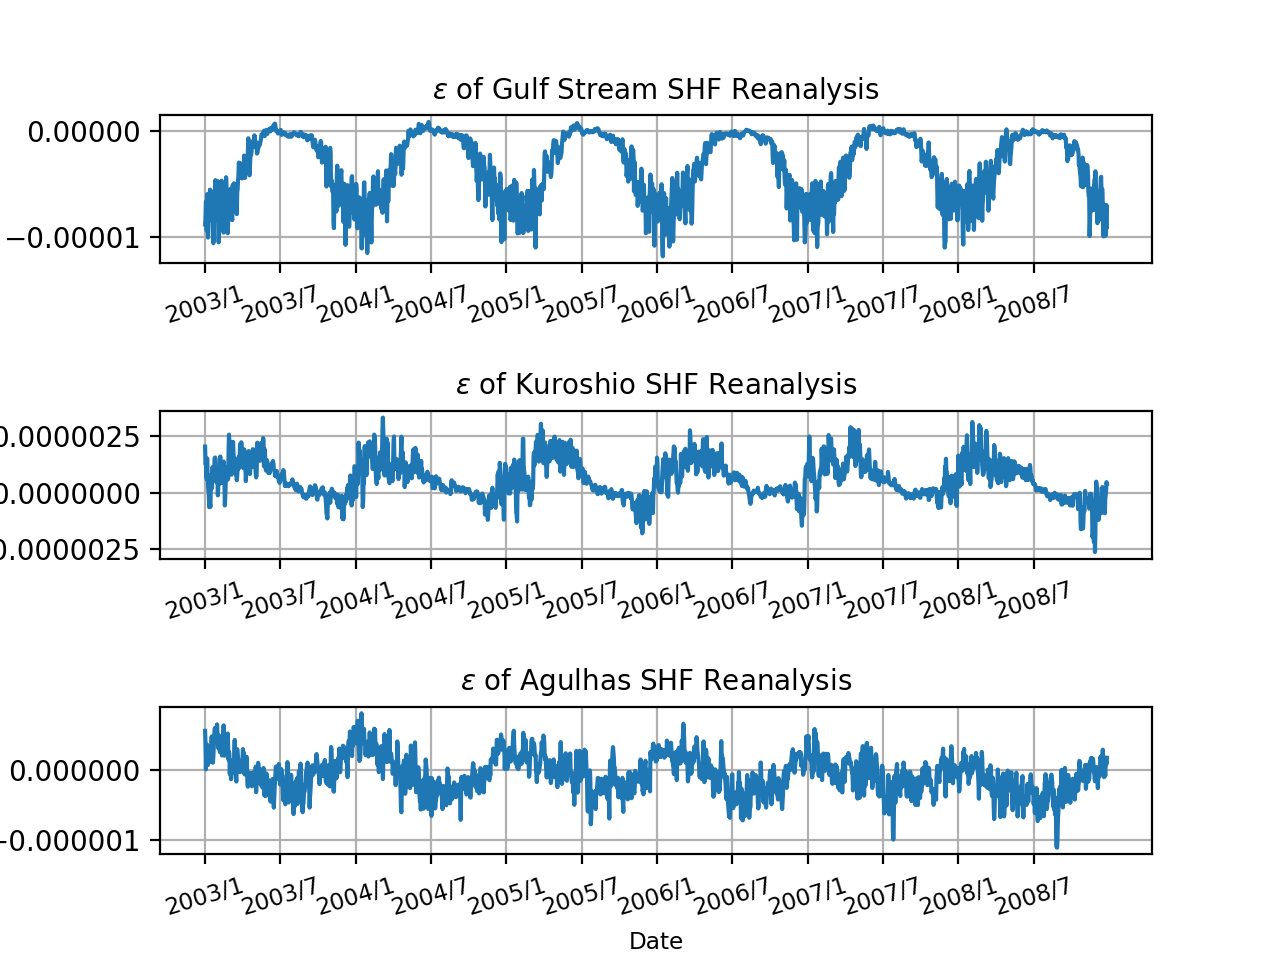

In [65]:
fig, axs = plt.subplots(nrows=3)
fig.subplots_adjust(hspace=1)

zero = np.zeros(len(time))

i = np.arange(0, len(time)+1, 183)
temp = np.array(t_str)
temp = temp[i]
yyyymm_str = ['2003/1','2003/7','2004/1','2004/7','2005/1','2005/7','2006/1','2006/7','2007/1','2007/7','2008/1','2008/7']


ax = axs[0]
ax.plot(t_str,np.nanmean(epsilon_GS,axis=(1,2)))
#ax.plot(t_str,zero)
ax.set_ylabel('W/m$^2$',fontsize='small')
ax.set_title('$\epsilon$ of Gulf Stream SHF Reanalysis',fontsize='medium')
#ax.set_xlabel('Date',fontsize='small')
ax.set_xticks(i)
ax.set_xticklabels(yyyymm_str, rotation=17,fontsize='small')
#ax.set_ylim([.5,8])
ax.grid()

ax = axs[1]
ax.plot(t_str,np.nanmean(epsilon_K,axis=(1,2)))
#ax.plot(t_str,zero)
ax.set_title('$\epsilon$ of Kuroshio SHF Reanalysis',fontsize='medium')
ax.set_ylabel('W/m$^2$',fontsize='small')
#ax.set_xlabel('Date',fontsize='small')
ax.set_xticks(i)
ax.set_xticklabels(yyyymm_str, rotation=17,fontsize='small')
#ax.set_ylim([.5,8])
ax.grid()

ax = axs[2]
ax.plot(t_str,np.nanmean(epsilon_A,axis=(1,2)))
#ax.plot(t_str,zero)
ax.set_title('$\epsilon$ of Agulhas SHF Reanalysis',fontsize='medium')
ax.set_ylabel('W/m$^2$',fontsize='small')
ax.set_xlabel('Date',fontsize='small')
ax.set_xticks(i)
ax.set_xticklabels(yyyymm_str, rotation=17,fontsize='small')
#ax.set_ylim([.5,8])
ax.grid()


In [ ]:
plt.savefig('PAPER_SHF_epsilon.png', dpi=300, bbox_inches='tight')


<IPython.core.display.Javascript object>


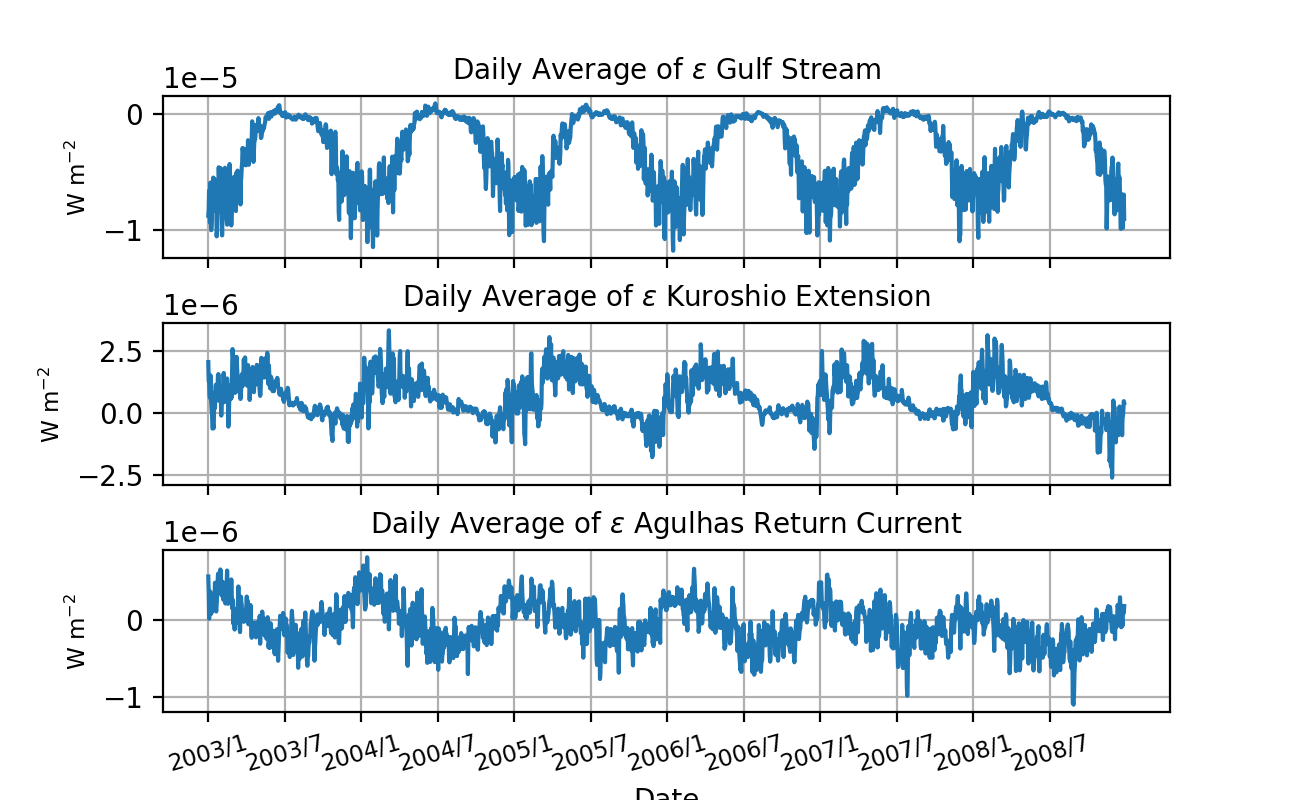

In [66]:
fig, axs = plt.subplots(nrows=3,figsize=(6.5,4))
fig.subplots_adjust(hspace=.4)

zero = np.zeros(len(time))

i = np.arange(0, len(time)+1, 183)
temp = np.array(t_str)
temp = temp[i]
yyyymm_str = ['2003/1','2003/7','2004/1','2004/7','2005/1','2005/7','2006/1','2006/7','2007/1','2007/7','2008/1','2008/7']

ax = axs[0]
ax.plot(t_str,np.nanmean(epsilon_GS,axis=(1,2)),linewidth=1.5)
ax.set_ylabel('W m$^{-2}$',fontsize='small')
ax.set_title('Daily Average of $\epsilon$ Gulf Stream',fontsize='medium')
ax.ticklabel_format(axis='y', style='sci', scilimits=(-4,4))
ax.set_xticks(i)
ax.set_xticklabels(yyyymm_str, rotation=16,fontsize='small')
plt.setp(ax.get_xticklabels(), visible=False)
ax.grid()

ax = axs[1]
ax.plot(t_str,np.nanmean(epsilon_K,axis=(1,2)),linewidth=1.5)
ax.set_title('Daily Average of $\epsilon$ Kuroshio Extension',fontsize='medium')
ax.set_ylabel('W m$^{-2}$',fontsize='small')
ax.ticklabel_format(axis='y', style='sci', scilimits=(-4,4))
ax.set_xticks(i)
ax.set_xticklabels(yyyymm_str, rotation=16,fontsize='small')
plt.setp(ax.get_xticklabels(), visible=False)
ax.grid()

ax = axs[2]
ax.plot(t_str,np.nanmean(epsilon_A,axis=(1,2)),linewidth=1.5)
ax.set_title('Daily Average of $\epsilon$ Agulhas Return Current',fontsize='medium')
ax.set_ylabel('W m$^{-2}$',fontsize='small')
ax.ticklabel_format(axis='y', style='sci', scilimits=(-4,4))
ax.set_xlabel('Date',fontsize='medium')
ax.set_xticks(i)
ax.set_xticklabels(yyyymm_str, rotation=16,fontsize='small')
ax.grid()


In [67]:
plt.savefig('PAPER_SHF_epsilonv4.png', dpi=300, bbox_inches='tight')

In [ ]:
fig, axs = plt.subplots(nrows=3)
fig.subplots_adjust(hspace=1)

i = np.arange(0, len(time)+1, 183)
temp = np.array(t_str)
temp = temp[i]
yyyymm_str = ['2003/1','2003/7','2004/1','2004/7','2005/1','2005/7','2006/1','2006/7','2007/1','2007/7','2008/1','2008/7']


ax = axs[0]
ax.plot(t_str,np.nanmean(wspd_GS,axis=(1,2)),label='U',linewidth=1.3)
ax.plot(t_str,np.nanmean(sst_GS,axis=(1,2)),label='SST',linewidth=1.3)
ax.plot(t_str,np.nanmean(ta_GS,axis=(1,2)),label='TA',linewidth=1)
ax.legend(bbox_to_anchor=(1.01, 1.5),fontsize='x-small', loc='upper right', ncol=2)
ax.set_ylabel('m/s or ºC',fontsize='small')
ax.set_title('Wind Speed, TA, & SST in Gulf Stream',fontsize='medium')
#ax.set_xlabel('Date',fontsize='small')
ax.set_xticks(i)
ax.set_xticklabels(yyyymm_str, rotation=17,fontsize='small')
#ax.set_ylim([-26,26])
ax.grid()

ax = axs[1]
ax.plot(t_str,np.nanmean(wspd_K,axis=(1,2)),label='U',linewidth=1.3)
ax.plot(t_str,np.nanmean(sst_K,axis=(1,2)),label='SST',linewidth=1.3)
ax.plot(t_str,np.nanmean(ta_K,axis=(1,2)),label='TA',linewidth=1)
ax.set_title('Wind Speed, TA, & SST in Kuroshio',fontsize='medium')
ax.set_ylabel('m/s or ºC',fontsize='small')
#ax.set_xlabel('Date',fontsize='small')
ax.set_xticks(i)
ax.set_xticklabels(yyyymm_str, rotation=17,fontsize='small')
#ax.set_ylim([2,25])
ax.grid()

ax = axs[2]
ax.plot(t_str,np.nanmean(wspd_A,axis=(1,2)),label='U',linewidth=1.3)
ax.plot(t_str,np.nanmean(sst_A,axis=(1,2)),label='SST',linewidth=1.3)
ax.plot(t_str,np.nanmean(ta_A,axis=(1,2)),label='TA',linewidth=1)
ax.set_title('Wind Speed, TA, & SST in Agulhas',fontsize='medium')
ax.set_ylabel('m/s or ºC',fontsize='small')
ax.set_xlabel('Date',fontsize='small')
ax.set_xticks(i)
ax.set_xticklabels(yyyymm_str, rotation=17,fontsize='small')
#ax.set_ylim([-1,25])
ax.grid()

In [ ]:
plt.savefig('QS_sst&u&ta_daily_era.png', dpi=300, bbox_inches='tight')

## Daily Plots of Taylor Expansion

In [ ]:
fig, axs = plt.subplots(nrows=3)
fig.subplots_adjust(hspace=1)

i = np.arange(0, len(time)+1, 183)
temp = np.array(t_str)
temp = temp[i]
yyyymm_str = ['2003/1','2003/7','2004/1','2004/7','2005/1','2005/7','2006/1','2006/7','2007/1','2007/7','2008/1','2008/7']


ax = axs[0]
ax.plot(t_str,np.nanmean(Q_GS,axis=(1,2)))
ax.set_ylabel('W/m$^2$',fontsize='small')
ax.set_title('Large Scale SHF $Q_0$ in Gulf Stream',fontsize='medium')
#ax.set_xlabel('Date',fontsize='small')
ax.set_xticks(i)
ax.set_xticklabels(yyyymm_str, rotation=17,fontsize='small')
#ax.set_ylim([-50,320])
ax.grid()

ax = axs[1]
ax.plot(t_str,np.nanmean(Q_K,axis=(1,2)))
ax.set_title('Large Scale SHF $Q_0$ in Kuroshio',fontsize='medium')
ax.set_ylabel('W/m$^2$',fontsize='small')
#ax.set_xlabel('Date',fontsize='small')
ax.set_xticks(i)
ax.set_xticklabels(yyyymm_str, rotation=17,fontsize='small')
#ax.set_ylim([-50,320])
ax.grid()

ax = axs[2]
ax.plot(t_str,np.nanmean(Q_A,axis=(1,2)))
ax.set_title('Large Scale SHF $Q_0$ in Agulhas',fontsize='medium')
ax.set_ylabel('W/m$^2$',fontsize='small')
ax.set_xlabel('Date',fontsize='small')
ax.set_xticks(i)
ax.set_xticklabels(yyyymm_str, rotation=17,fontsize='small')
#ax.set_ylim([-50,320])
ax.grid()


In [ ]:
plt.savefig('QS_q0_daily_era.png', dpi=300, bbox_inches='tight')

In [ ]:
fig, axs = plt.subplots(nrows=3,figsize=(7,6))
fig.subplots_adjust(hspace=.9)

i = np.arange(0, len(time)+1, 183)
temp = np.array(t_str)
temp = temp[i]
yyyymm_str = ['2003/1','2003/7','2004/1','2004/7','2005/1','2005/7','2006/1','2006/7','2007/1','2007/7','2008/1','2008/7']


ax = axs[0]
ax.plot(t_str,np.nanmean(Qtau_GS,axis=(1,2)),label='$Q_{TaU}$',linewidth=1,alpha=0.7,zorder=3)
ax.plot(t_str,np.nanmean(Qtsu_GS,axis=(1,2)),label='$Q_{TsU}$',linewidth=1,alpha=0.85,zorder=2)
ax.set_ylabel('W/m$^2$',fontsize='small')
ax.set_title('$Q_{TsU}$ and $Q_{TaU}$ in Gulf Stream',fontsize='medium')
#ax.set_xlabel('Date',fontsize='small')
ax.set_xticks(i)
ax.set_xticklabels(yyyymm_str, rotation=16,fontsize='small')
ax.legend(loc='upper right', fontsize='x-small', ncol=2,bbox_to_anchor=(1.01, 1.26))
#ax.set_ylim([-15,17])
ax.grid()

ax = axs[1]
ax.plot(t_str,np.nanmean(Qtau_K,axis=(1,2)),label='$Q_{TaU}$',linewidth=1,alpha=0.8,zorder=3)
ax.plot(t_str,np.nanmean(Qtsu_K,axis=(1,2)),label='$Q_{TsU}$',linewidth=1,alpha=0.8,zorder=2)
ax.set_title('$Q_{TsU}$ and $Q_{TaU}$ in Kuroshio',fontsize='medium')
ax.set_ylabel('W/m$^2$',fontsize='small')
#ax.set_xlabel('Date',fontsize='small')
ax.set_xticks(i)
ax.set_xticklabels(yyyymm_str, rotation=16,fontsize='small')
#ax.legend(loc='upper right', fontsize='x-small', ncol=2,bbox_to_anchor=(1.01, 1.5))
#ax.set_ylim([-15,17])
ax.grid()

ax = axs[2]
ax.plot(t_str,np.nanmean(Qtau_A,axis=(1,2)),label='$Q_{TaU}$',linewidth=1,alpha=0.8,zorder=3)
ax.plot(t_str,np.nanmean(Qtsu_A,axis=(1,2)),label='$Q_{TsU}$',linewidth=1,alpha=0.8,zorder=2)
ax.set_title('$Q_{TsU}$ and $Q_{TaU}$ in Agulhas',fontsize='medium')
ax.set_ylabel('W/m$^2$',fontsize='small')
ax.set_xlabel('Date',fontsize='medium')
ax.set_xticks(i)
ax.set_xticklabels(yyyymm_str, rotation=16,fontsize='small')
#ax.legend(loc='upper right', fontsize='x-small', ncol=2,bbox_to_anchor=(1.01, 1.5))
#ax.set_ylim([-17,15])
ax.grid()


In [ ]:
plt.savefig('QS_nonlinear_daily_era.png', dpi=300, bbox_inches='tight')


<IPython.core.display.Javascript object>


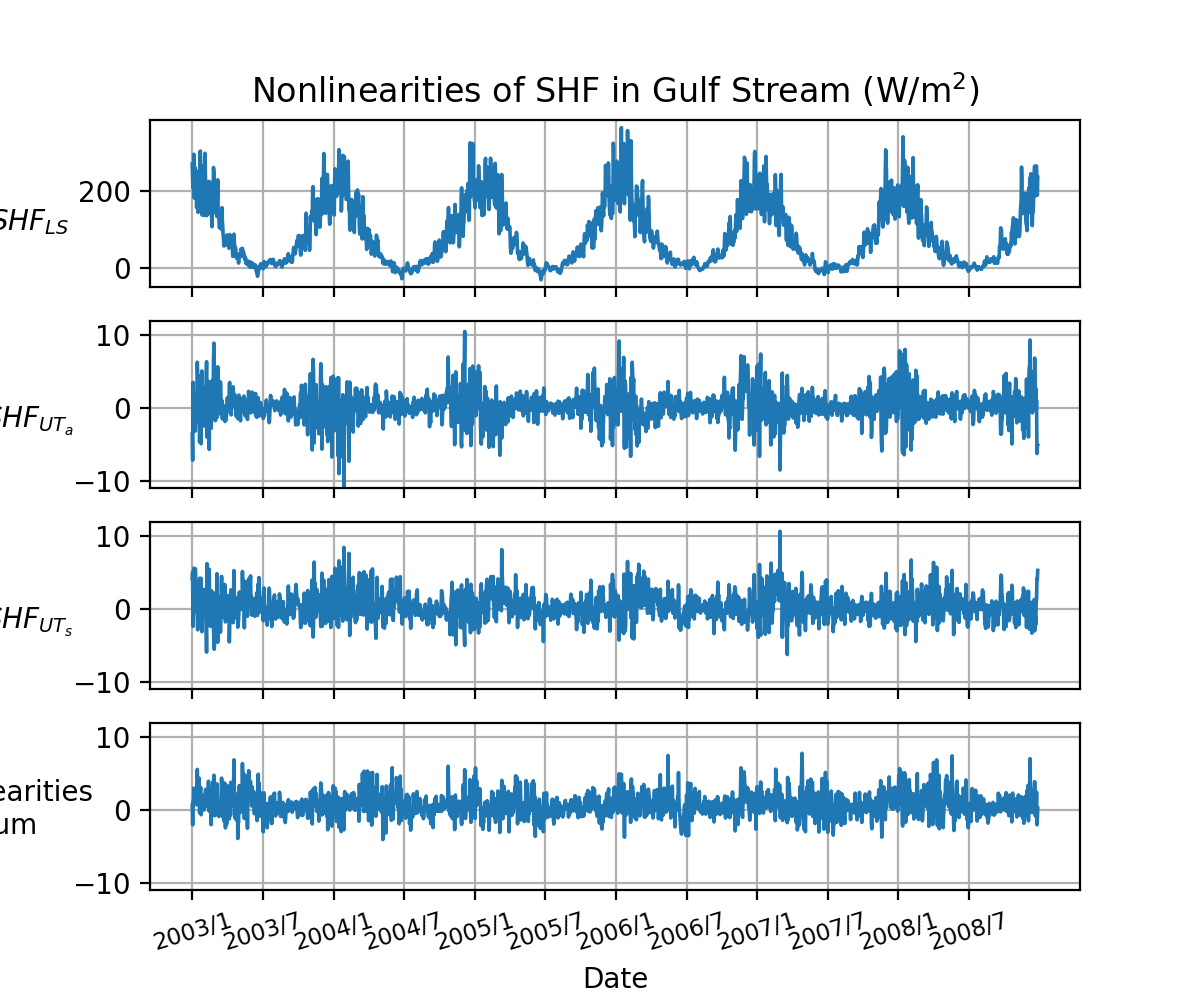

In [18]:
fig, axs = plt.subplots(nrows=4,figsize=(6,5))
fig.subplots_adjust(hspace=.2)

i = np.arange(0, len(time)+1, 183)
temp = np.array(t_str)
temp = temp[i]
yyyymm_str = ['2003/1','2003/7','2004/1','2004/7','2005/1','2005/7','2006/1','2006/7','2007/1','2007/7','2008/1','2008/7']


ax = axs[0]
ax.plot(t_str,np.nanmean(Q_GS,axis=(1,2)),linewidth=1.3)
ax.set_title('Nonlinearities of SHF in Gulf Stream (W/m$^2$)',fontsize='large')
ax.set_ylabel('$SHF_{LS}$',fontsize='medium',rotation=0)
ax.set_xticks(i)
ax.yaxis.set_label_coords(-.13, .3)
ax.set_xticklabels(yyyymm_str, rotation=17,fontsize='small')
plt.setp(ax.get_xticklabels(), visible=False)
#ax.set_ylim([-15,17])
ax.grid()

ax = axs[1]
ax.plot(t_str,np.nanmean(Qtau_GS,axis=(1,2)),linewidth=1.3)
ax.set_ylabel('$SHF_{UT_a}$',fontsize='medium',rotation=0)
ax.set_xticks(i)
ax.yaxis.set_label_coords(-.13, .3)
ax.set_xticklabels(yyyymm_str, rotation=17,fontsize='small')
plt.setp(ax.get_xticklabels(), visible=False)
ax.set_ylim([-11,12])
ax.grid()

ax = axs[2]
ax.plot(t_str,np.nanmean(Qtsu_GS,axis=(1,2)),linewidth=1.3)
ax.set_ylabel('$SHF_{UT_s}$',fontsize='medium',rotation=0)
ax.set_xticks(i)
ax.yaxis.set_label_coords(-.13, .3)
ax.set_xticklabels(yyyymm_str, rotation=17,fontsize='small')
plt.setp(ax.get_xticklabels(), visible=False)
ax.set_ylim([-11,12])
ax.grid()

ax = axs[3]
ax.plot(t_str,np.nanmean(Qtau_GS+Qtsu_GS,axis=(1,2)),linewidth=1.3)
ax.set_ylabel('Nonlinearities \n Sum',fontsize='medium',rotation=0)
ax.set_xlabel('Date',fontsize='medium')
ax.set_xticks(i)
ax.yaxis.set_label_coords(-.16, .3)
ax.set_xticklabels(yyyymm_str, rotation=17,fontsize='small')
ax.set_ylim([-11,12])
ax.grid()


In [ ]:
plt.savefig('PAPER_SHF_nonlinear_GS.png', dpi=300, bbox_inches='tight')


<IPython.core.display.Javascript object>


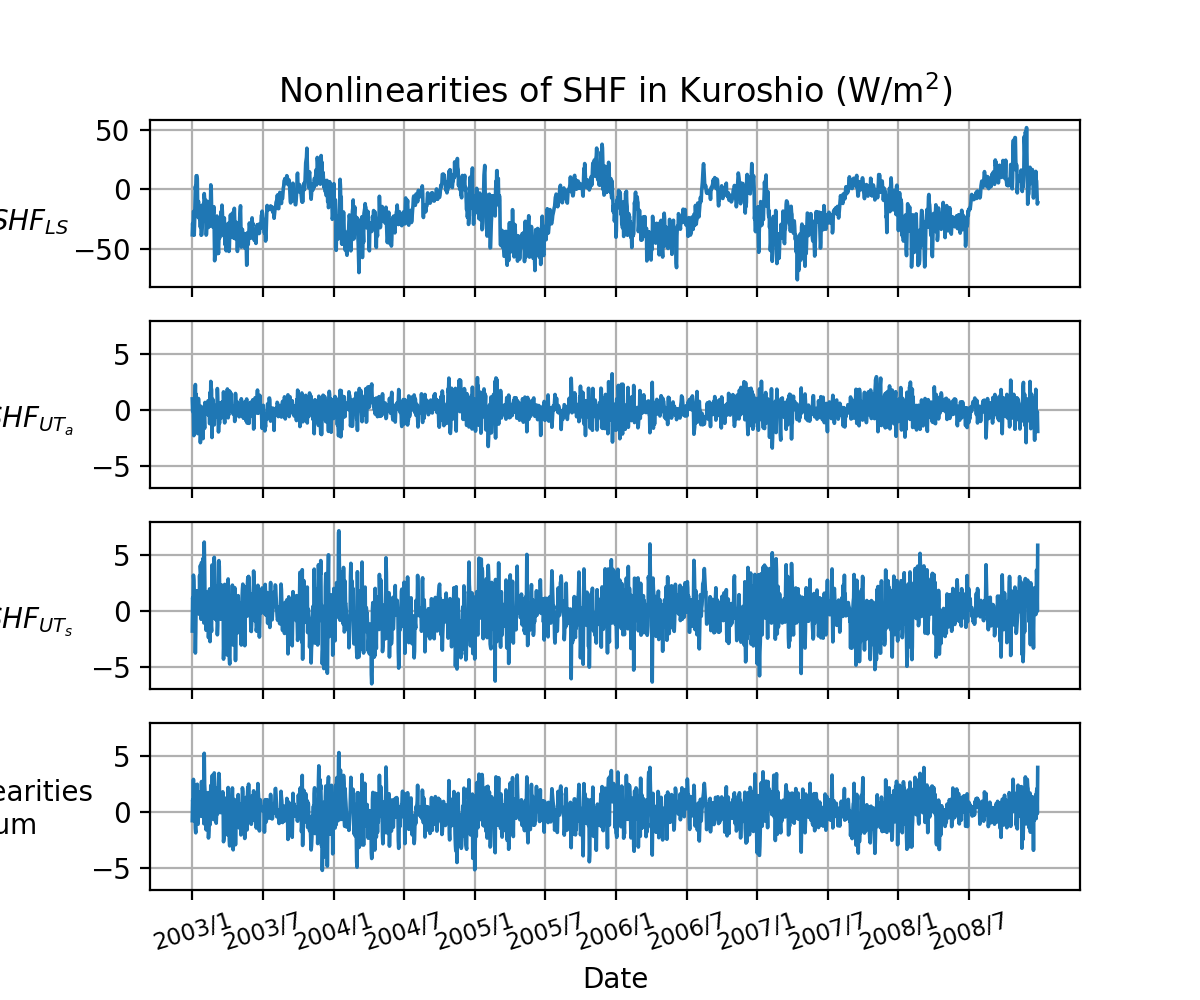

In [19]:
fig, axs = plt.subplots(nrows=4,figsize=(6,5))
fig.subplots_adjust(hspace=.2)

i = np.arange(0, len(time)+1, 183)
temp = np.array(t_str)
temp = temp[i]
yyyymm_str = ['2003/1','2003/7','2004/1','2004/7','2005/1','2005/7','2006/1','2006/7','2007/1','2007/7','2008/1','2008/7']


ax = axs[0]
ax.plot(t_str,np.nanmean(Q_K,axis=(1,2)),linewidth=1.3)
ax.set_title('Nonlinearities of SHF in Kuroshio (W/m$^2$)',fontsize='large')
ax.set_ylabel('$SHF_{LS}$',fontsize='medium',rotation=0)
ax.set_xticks(i)
ax.yaxis.set_label_coords(-.13, .3)
ax.set_xticklabels(yyyymm_str, rotation=17,fontsize='small')
plt.setp(ax.get_xticklabels(), visible=False)
ax.grid()

ax = axs[1]
ax.plot(t_str,np.nanmean(Qtau_K,axis=(1,2)),linewidth=1.3)
ax.set_ylabel('$SHF_{UT_a}$',fontsize='medium',rotation=0)
ax.set_xticks(i)
ax.yaxis.set_label_coords(-.13, .3)
ax.set_xticklabels(yyyymm_str, rotation=17,fontsize='small')
plt.setp(ax.get_xticklabels(), visible=False)
ax.set_ylim([-7,8])
ax.grid()

ax = axs[2]
ax.plot(t_str,np.nanmean(Qtsu_K,axis=(1,2)),linewidth=1.3)
ax.set_ylabel('$SHF_{UT_s}$',fontsize='medium',rotation=0)
ax.set_xticks(i)
ax.yaxis.set_label_coords(-.13, .3)
ax.set_xticklabels(yyyymm_str, rotation=17,fontsize='small')
plt.setp(ax.get_xticklabels(), visible=False)
ax.set_ylim([-7,8])
ax.grid()

ax = axs[3]
ax.plot(t_str,np.nanmean(Qtau_K+Qtsu_K,axis=(1,2)),linewidth=1.3)
ax.set_ylabel('Nonlinearities \n Sum',fontsize='medium',rotation=0)
ax.set_xlabel('Date',fontsize='medium')
ax.set_xticks(i)
ax.yaxis.set_label_coords(-.16, .3)
ax.set_xticklabels(yyyymm_str, rotation=17,fontsize='small')
ax.set_ylim([-7,8])
ax.grid()


In [ ]:
plt.savefig('PAPER_SHF_nonlinear_K.png', dpi=300, bbox_inches='tight')


<IPython.core.display.Javascript object>


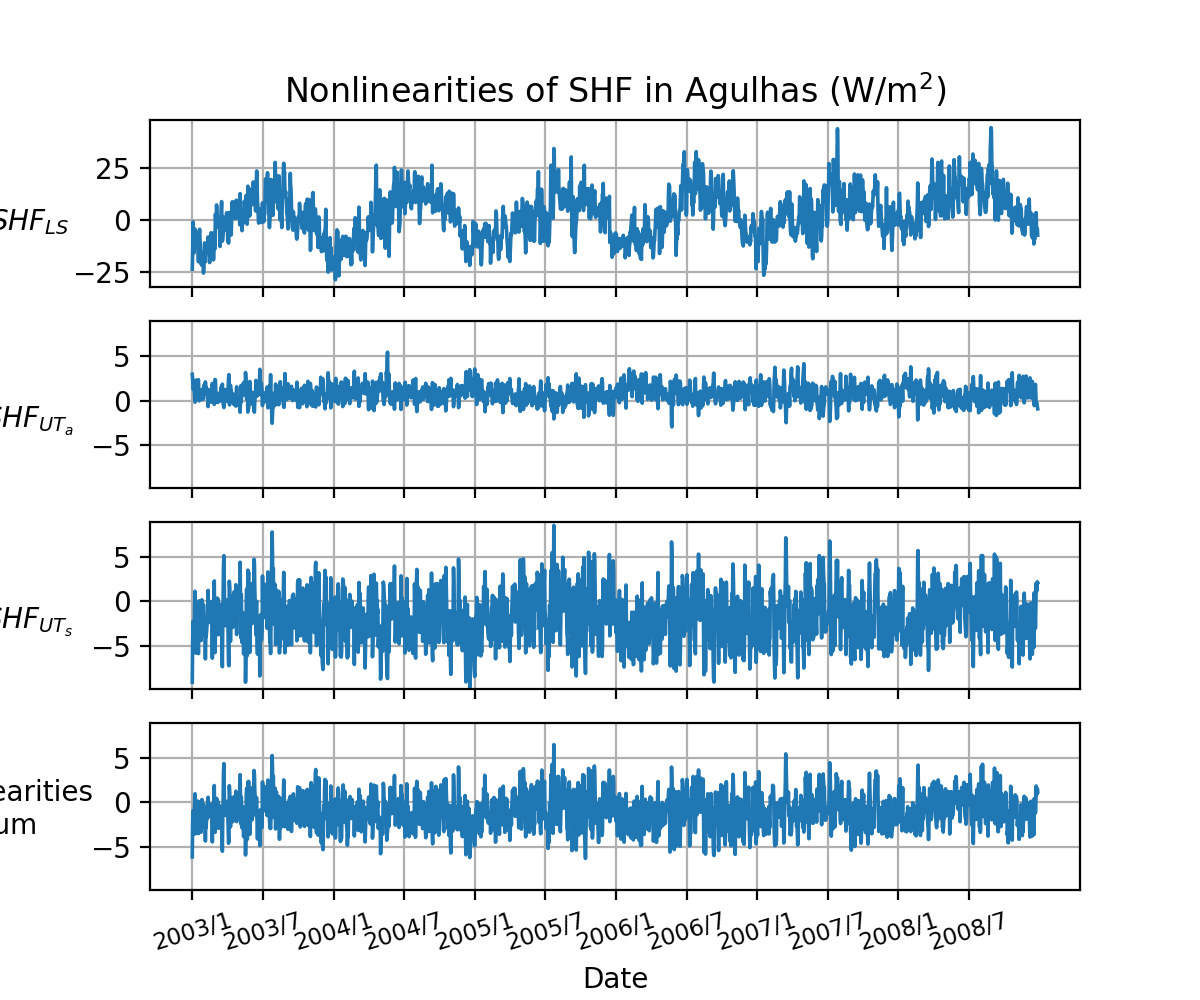

In [25]:
fig, axs = plt.subplots(nrows=4,figsize=(6,5))
fig.subplots_adjust(hspace=.2)

i = np.arange(0, len(time)+1, 183)
temp = np.array(t_str)
temp = temp[i]
yyyymm_str = ['2003/1','2003/7','2004/1','2004/7','2005/1','2005/7','2006/1','2006/7','2007/1','2007/7','2008/1','2008/7']


ax = axs[0]
ax.plot(t_str,np.nanmean(Q_A,axis=(1,2)),linewidth=1.3)
ax.set_title('Nonlinearities of SHF in Agulhas (W/m$^2$)',fontsize='large')
ax.set_ylabel('$SHF_{LS}$',fontsize='medium',rotation=0)
ax.set_xticks(i)
ax.yaxis.set_label_coords(-.13, .3)
ax.set_xticklabels(yyyymm_str, rotation=17,fontsize='small')
plt.setp(ax.get_xticklabels(), visible=False)
ax.grid()

ax = axs[1]
ax.plot(t_str,np.nanmean(Qtau_A,axis=(1,2)),linewidth=1.3)
ax.set_ylabel('$SHF_{UT_a}$',fontsize='medium',rotation=0)
ax.set_xticks(i)
ax.yaxis.set_label_coords(-.13, .3)
ax.set_xticklabels(yyyymm_str, rotation=17,fontsize='small')
plt.setp(ax.get_xticklabels(), visible=False)
ax.set_ylim([-9.9,9])
ax.grid()

ax = axs[2]
ax.plot(t_str,np.nanmean(Qtsu_A,axis=(1,2)),linewidth=1.3)
ax.set_ylabel('$SHF_{UT_s}$',fontsize='medium',rotation=0)
ax.set_xticks(i)
ax.yaxis.set_label_coords(-.13, .3)
ax.set_xticklabels(yyyymm_str, rotation=17,fontsize='small')
plt.setp(ax.get_xticklabels(), visible=False)
ax.set_ylim([-9.9,9])
ax.grid()

ax = axs[3]
ax.plot(t_str,np.nanmean(Qtau_A+Qtsu_A,axis=(1,2)),linewidth=1.3)
ax.set_ylabel('Nonlinearities \n Sum',fontsize='medium',rotation=0)
ax.set_xlabel('Date',fontsize='medium')
ax.set_xticks(i)
ax.yaxis.set_label_coords(-.16, .3)
ax.set_xticklabels(yyyymm_str, rotation=17,fontsize='small')
ax.set_ylim([-9.9,9])
ax.grid()


In [26]:
plt.savefig('PAPER_SHF_nonlinear_A.png', dpi=300, bbox_inches='tight')


<IPython.core.display.Javascript object>


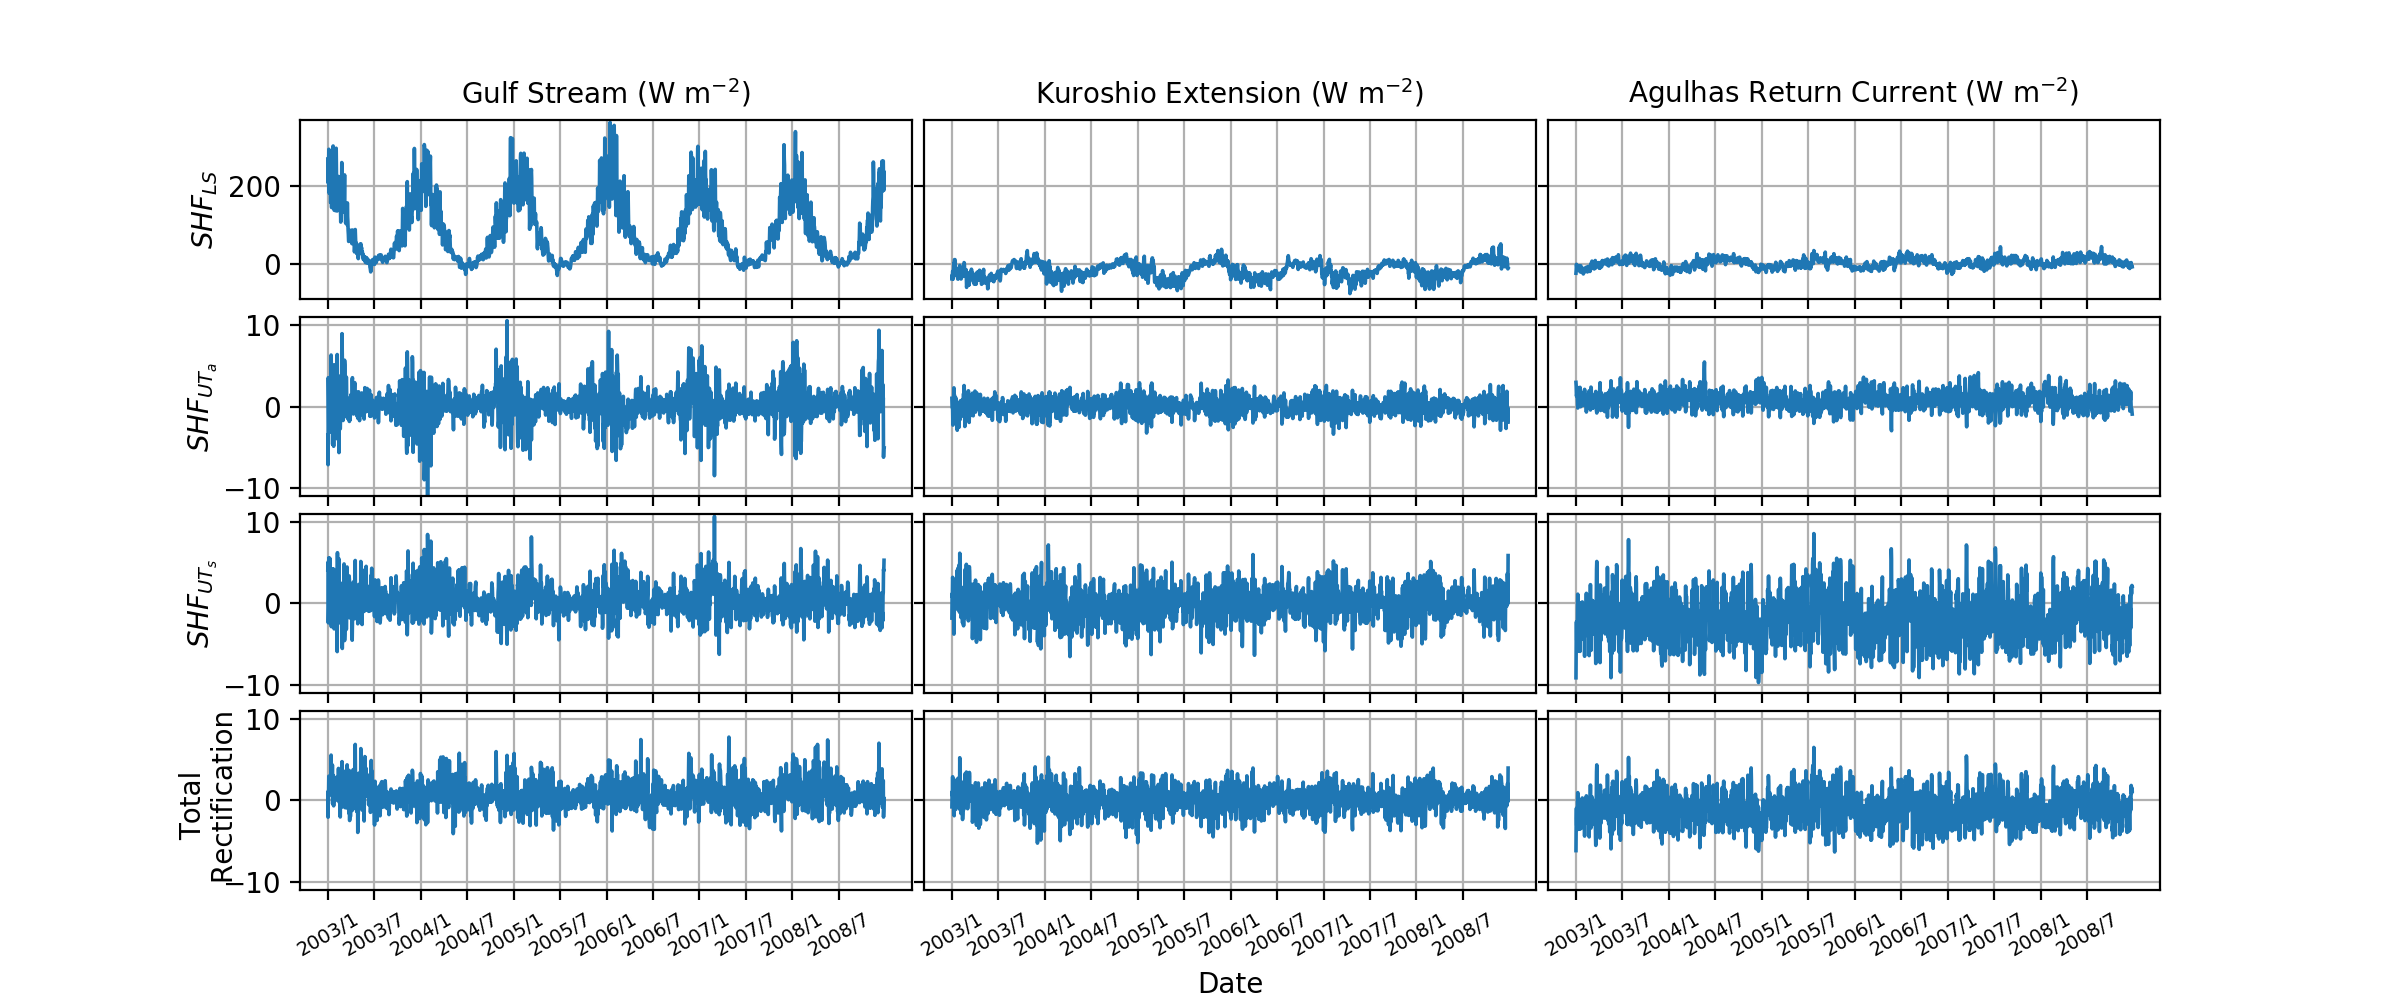

In [60]:
fig, axs = plt.subplots(4,3,figsize=(12,5))
fig.subplots_adjust(hspace=0.1,wspace=0.02)


i = np.arange(0, len(time)+1, 183)
temp = np.array(t_str)
temp = temp[i]
yyyymm_str = ['2003/1','2003/7','2004/1','2004/7','2005/1','2005/7','2006/1','2006/7','2007/1','2007/7','2008/1','2008/7']

ax = axs[0,0]
ax.plot(t_str,np.nanmean(Q_GS,axis=(1,2)),linewidth=1.3)
ax.set_title('Gulf Stream (W m$^{-2}$)',fontsize='medium')
ax.set_ylabel('$SHF_{LS}$',fontsize='medium')
ax.set_xticks(i)
ax.yaxis.set_label_coords(-.13, .5)
ax.set_xticklabels(yyyymm_str, rotation=25,fontsize='small')
plt.setp(ax.get_xticklabels(), visible=False)
ax.set_ylim([-90,370])
ax.grid()

ax = axs[1,0]
ax.plot(t_str,np.nanmean(Qtau_GS,axis=(1,2)),linewidth=1.3)
ax.set_ylabel('$SHF_{UT_a}$',fontsize='medium')
ax.set_xticks(i)
ax.yaxis.set_label_coords(-.13, .5)
ax.set_xticklabels(yyyymm_str, rotation=25,fontsize='small')
plt.setp(ax.get_xticklabels(), visible=False)
ax.set_ylim([-11,11])
ax.grid()

ax = axs[2,0]
ax.plot(t_str,np.nanmean(Qtsu_GS,axis=(1,2)),linewidth=1.3)
ax.set_ylabel('$SHF_{UT_s}$',fontsize='medium')
ax.set_xticks(i)
ax.yaxis.set_label_coords(-.13, .5)
ax.set_xticklabels(yyyymm_str, rotation=25,fontsize='small')
plt.setp(ax.get_xticklabels(), visible=False)
ax.set_ylim([-11,11])
ax.grid()

ax = axs[3,0]
ax.plot(t_str,np.nanmean(Qtau_GS+Qtsu_GS,axis=(1,2)),linewidth=1.3)
ax.set_ylabel('Total \n Rectification',fontsize='medium')
ax.set_xticks(i)
ax.yaxis.set_label_coords(-.099, .5)
ax.set_xticklabels(yyyymm_str, rotation=30,fontsize='x-small')
ax.set_ylim([-11,11])
ax.grid()

###########

ax = axs[0,1]
ax.plot(t_str,np.nanmean(Q_K,axis=(1,2)),linewidth=1.3)
ax.set_title('Kuroshio Extension (W m$^{-2}$)',fontsize='medium')
ax.set_xticks(i)
ax.set_xticklabels(yyyymm_str, rotation=25,fontsize='small')
plt.setp(ax.get_xticklabels(), visible=False)
plt.setp(ax.get_yticklabels(), visible=False)
ax.set_ylim([-90,370])
ax.grid()

ax = axs[1,1]
ax.plot(t_str,np.nanmean(Qtau_K,axis=(1,2)),linewidth=1.3)
ax.set_xticks(i)
ax.set_xticklabels(yyyymm_str, rotation=25,fontsize='small')
plt.setp(ax.get_xticklabels(), visible=False)
plt.setp(ax.get_yticklabels(), visible=False)
ax.set_ylim([-11,11])
ax.grid()

ax = axs[2,1]
ax.plot(t_str,np.nanmean(Qtsu_K,axis=(1,2)),linewidth=1.3)
ax.set_xticks(i)
ax.set_xticklabels(yyyymm_str, rotation=25,fontsize='small')
plt.setp(ax.get_xticklabels(), visible=False)
plt.setp(ax.get_yticklabels(), visible=False)
ax.set_ylim([-11,11])
ax.grid()

ax = axs[3,1]
ax.plot(t_str,np.nanmean(Qtau_K+Qtsu_K,axis=(1,2)),linewidth=1.3)
ax.set_xlabel('Date',fontsize='medium')
ax.set_xticks(i)
ax.set_xticklabels(yyyymm_str, rotation=30,fontsize='x-small')
plt.setp(ax.get_yticklabels(), visible=False)
ax.set_ylim([-11,11])
ax.grid()

########

ax = axs[0,2]
ax.plot(t_str,np.nanmean(Q_A,axis=(1,2)),linewidth=1.3)
ax.set_title('Agulhas Return Current (W m$^{-2}$)',fontsize='medium')
ax.set_xticks(i)
ax.set_xticklabels(yyyymm_str, rotation=25,fontsize='small')
plt.setp(ax.get_xticklabels(), visible=False)
plt.setp(ax.get_yticklabels(), visible=False)
ax.set_ylim([-90,370])
ax.grid()

ax = axs[1,2]
ax.plot(t_str,np.nanmean(Qtau_A,axis=(1,2)),linewidth=1.3)
ax.set_xticks(i)
ax.set_xticklabels(yyyymm_str, rotation=25,fontsize='small')
plt.setp(ax.get_xticklabels(), visible=False)
plt.setp(ax.get_yticklabels(), visible=False)
ax.set_ylim([-11,11])
ax.grid()

ax = axs[2,2]
ax.plot(t_str,np.nanmean(Qtsu_A,axis=(1,2)),linewidth=1.3)
ax.set_xticks(i)
ax.set_xticklabels(yyyymm_str, rotation=25,fontsize='small')
plt.setp(ax.get_xticklabels(), visible=False)
plt.setp(ax.get_yticklabels(), visible=False)
ax.set_ylim([-11,11])
ax.grid()

ax = axs[3,2]
ax.plot(t_str,np.nanmean(Qtau_A+Qtsu_A,axis=(1,2)),linewidth=1.3)
ax.set_xticks(i)
ax.set_xticklabels(yyyymm_str, rotation=30,fontsize='x-small')
plt.setp(ax.get_yticklabels(), visible=False)
ax.set_ylim([-11,11])
ax.grid()



In [61]:
plt.savefig('PAPER_SHF_nonlinear.png', dpi=300, bbox_inches='tight')


In [ ]:
Qtauprct_GS = np.nanmean(Qtau_GS/Q_GS,axis=(1,2))*100
Qtsuprct_GS = np.nanmean(Qtsu_GS/Q_GS,axis=(1,2))*100

Qtauprct_K = np.nanmean(Qtau_K/Q_K,axis=(1,2))*100
Qtsuprct_K = np.nanmean(Qtsu_K/Q_K,axis=(1,2))*100

Qtauprct_A = np.nanmean(Qtau_A/Q_A,axis=(1,2))*100
Qtsuprct_A = np.nanmean(Qtsu_A/Q_A,axis=(1,2))*100


In [ ]:
fig, axs = plt.subplots(nrows=3)
fig.subplots_adjust(hspace=.9)

i = np.arange(0, len(time)+1, 183)
temp = np.array(t_str)
temp = temp[i]
yyyymm_str = ['2003/1','2003/7','2004/1','2004/7','2005/1','2005/7','2006/1','2006/7','2007/1','2007/7','2008/1','2008/7']


ax = axs[0]
ax.plot(t_str,Qtauprct_GS,label='$Q_{TaU}$',linewidth=1)
ax.plot(t_str,Qtsuprct_GS,label='$Q_{TsU}$',linewidth=1,alpha=0.65)
ax.set_ylabel('%',fontsize='small')
ax.set_title('$Q_{TaU}$% and $Q_{TsU}$% of $Q_0$ in Gulf Stream',fontsize='medium')
#ax.set_xlabel('Date',fontsize='small')
ax.set_xticks(i)
ax.set_xticklabels(yyyymm_str, rotation=16,fontsize='small')
ax.legend(loc='upper right', fontsize='x-small', ncol=1,bbox_to_anchor=(1.01, 1.5))
#ax.set_ylim([-60,60])
ax.grid()

ax = axs[1]
ax.plot(t_str,Qtauprct_K,label='$Q_{TaU}$',linewidth=1)
ax.plot(t_str,Qtsuprct_K,label='$Q_{TsU}$',linewidth=1,alpha=0.65)
ax.set_title('$Q_{TaU}$% and $Q_{TsU}$% of $Q_0$ in Kuroshio',fontsize='medium')
ax.set_ylabel('%',fontsize='small')
#ax.set_xlabel('Date',fontsize='small')
ax.set_xticks(i)
ax.set_xticklabels(yyyymm_str, rotation=16,fontsize='small')
#ax.set_ylim([-60,60])
ax.grid()

ax = axs[2]
ax.plot(t_str,Qtauprct_A,label='$Q_{TaU}$',linewidth=1)
ax.plot(t_str,Qtsuprct_A,label='$Q_{TsU}$',linewidth=1,alpha=0.65)
ax.set_title('$Q_{TaU}$% and $Q_{TsU}$% of $Q_0$ in Agulhas',fontsize='medium')
ax.set_ylabel('%',fontsize='small')
ax.set_xlabel('Date',fontsize='medium')
ax.set_xticks(i)
ax.set_xticklabels(yyyymm_str, rotation=16,fontsize='small')
#ax.set_ylim([-60,60])
ax.grid()


In [ ]:
plt.savefig('QS_nonlinprct_dailyera.png', dpi=300, bbox_inches='tight')


In [ ]:
fig, axs = plt.subplots(nrows=3)
fig.subplots_adjust(hspace=1)

i = np.arange(0, len(time)+1, 183)
temp = np.array(t_str)
temp = temp[i]
yyyymm_str = ['2003/1','2003/7','2004/1','2004/7','2005/1','2005/7','2006/1','2006/7','2007/1','2007/7','2008/1','2008/7']


ax = axs[0]
ax.plot(t_str,np.nanmean(SSTstd_GS,axis=(1,2)),label='Gulf Stream',linewidth=1.5)
ax.plot(t_str,np.nanmean(SSTstd_A,axis=(1,2)),label='Kuroshio',linewidth=1.5)
ax.plot(t_str,np.nanmean(SSTstd_K,axis=(1,2)),label='Agulhas',linewidth=1.5)
ax.set_ylabel('W/m^2',fontsize='small')
ax.set_title('Standard Deviation of SST',fontsize='medium')
ax.set_xticks(i)
ax.set_xticklabels(yyyymm_str, rotation=17,fontsize='small')
ax.legend(loc='upper right', fontsize='x-small', ncol=1,bbox_to_anchor=(1.01, 1.7))
#ax.set_ylim([-50,320])
ax.grid()

ax = axs[1]
ax.plot(t_str,np.nanmean(TAstd_GS,axis=(1,2)),label='Gulf Stream',linewidth=1.5)
ax.plot(t_str,np.nanmean(TAstd_A,axis=(1,2)),label='Kuroshio',linewidth=1.5)
ax.plot(t_str,np.nanmean(TAstd_K,axis=(1,2)),label='Agulhas',linewidth=1.5)
ax.set_title('Standard Deviation of Air Temperature',fontsize='medium')
ax.set_ylabel('W/m^2',fontsize='small')
ax.set_xticks(i)
ax.set_xticklabels(yyyymm_str, rotation=17,fontsize='small')
#ax.set_ylim([-50,320])
ax.grid()

#NOTE, I MADE AN ERROR MAKING THE U STD
ax = axs[2]
ax.plot(t_str,np.nanmean(Ustd_GS,axis=(1,2)),label='Gulf Stream',linewidth=1.5)
ax.plot(t_str,np.nanmean(Ustd_A,axis=(1,2)),label='Kuroshio',linewidth=1.5)
ax.plot(t_str,np.nanmean(Ustd_K,axis=(1,2)),label='Agulhas',linewidth=1.5)
ax.set_title('Standard Deviation of Wind Speed',fontsize='medium')
ax.set_ylabel('W/m^2',fontsize='small')
ax.set_xlabel('Date',fontsize='medium')
ax.set_xticks(i)
ax.set_xticklabels(yyyymm_str, rotation=17,fontsize='small')
#ax.set_ylim([-50,320])
ax.grid()


In [ ]:
fig, axs = plt.subplots(nrows=3)
fig.subplots_adjust(hspace=1)

i = np.arange(0, len(time)+1, 183)
temp = np.array(t_str)
temp = temp[i]
yyyymm_str = ['2003/1','2003/7','2004/1','2004/7','2005/1','2005/7','2006/1','2006/7','2007/1','2007/7','2008/1','2008/7']


ax = axs[0]
ax.plot(t_str,np.nanmean(UTS_GS,axis=(1,2)),label='UTS',linewidth=1.5)
ax.plot(t_str,np.nanmean(UTA_GS,axis=(1,2)),label='UTA',linewidth=1.5)
ax.plot(t_str,np.nanmean(TATS_GS,axis=(1,2)),label='TATS',linewidth=1.5)
ax.set_ylabel('????',fontsize='small')
ax.set_title('Covariance in Gulf Stream',fontsize='medium')
ax.set_xticks(i)
ax.set_xticklabels(yyyymm_str, rotation=17,fontsize='small')
ax.legend(loc='upper right', fontsize='x-small', ncol=1,bbox_to_anchor=(1.01, 1.7))
#ax.set_ylim([-50,320])
ax.grid()

ax = axs[1]
ax.plot(t_str,np.nanmean(UTS_A,axis=(1,2)),label='UTS',linewidth=1.5)
ax.plot(t_str,np.nanmean(UTA_A,axis=(1,2)),label='UTA',linewidth=1.5)
ax.plot(t_str,np.nanmean(TATS_A,axis=(1,2)),label='TATS',linewidth=1.5)
ax.set_title('Covariance in Agulhas',fontsize='medium')
ax.set_ylabel('?????',fontsize='small')
ax.set_xticks(i)
ax.set_xticklabels(yyyymm_str, rotation=17,fontsize='small')
#ax.set_ylim([-50,320])
ax.grid()

#NOTE, I MADE AN ERROR MAKING THE U STD
ax = axs[2]
ax.plot(t_str,np.nanmean(UTS_K,axis=(1,2)),label='UTS',linewidth=1.5)
ax.plot(t_str,np.nanmean(UTA_K,axis=(1,2)),label='UTA',linewidth=1.5)
ax.plot(t_str,np.nanmean(TATS_K,axis=(1,2)),label='TATS',linewidth=1.5)
ax.set_title('Covariance in Kuroshio',fontsize='medium')
ax.set_ylabel('?????',fontsize='small')
ax.set_xlabel('Date',fontsize='medium')
ax.set_xticks(i)
ax.set_xticklabels(yyyymm_str, rotation=17,fontsize='small')
#ax.set_ylim([-50,320])
ax.grid()


In [ ]:
fig, axs = plt.subplots(nrows=3)
fig.subplots_adjust(hspace=1)

i = np.arange(0, len(time)+1, 183)
temp = np.array(t_str)
temp = temp[i]
yyyymm_str = ['2003/1','2003/7','2004/1','2004/7','2005/1','2005/7','2006/1','2006/7','2007/1','2007/7','2008/1','2008/7']


ax = axs[0]
ax.plot(t_str,np.nanmean(UTS_GS,axis=(1,2)),label='Gulf Stream',linewidth=1.5)
ax.plot(t_str,np.nanmean(UTS_A,axis=(1,2)),label='Agulhas',linewidth=1.5)
ax.plot(t_str,np.nanmean(UTS_K,axis=(1,2)),label='Kuroshio',linewidth=1.5)
ax.set_ylabel('????',fontsize='small')
ax.set_title('Covariance of Wind Speed and SST',fontsize='medium')
ax.set_xticks(i)
ax.set_xticklabels(yyyymm_str, rotation=17,fontsize='small')
ax.legend(loc='upper right', fontsize='x-small', ncol=1,bbox_to_anchor=(1.01, 1.7))
#ax.set_ylim([-50,320])
ax.grid()

ax = axs[1]
ax.plot(t_str,np.nanmean(UTA_GS,axis=(1,2)),label='Gulf Stream',linewidth=1.5)
ax.plot(t_str,np.nanmean(UTA_A,axis=(1,2)),label='Agulhas',linewidth=1.5)
ax.plot(t_str,np.nanmean(UTA_K,axis=(1,2)),label='Kuroshio',linewidth=1.5)
ax.set_title('Covariance of Wind Speed and Air Temperature',fontsize='medium')
ax.set_ylabel('?????',fontsize='small')
ax.set_xticks(i)
ax.set_xticklabels(yyyymm_str, rotation=17,fontsize='small')
#ax.set_ylim([-50,320])
ax.grid()

#NOTE, I MADE AN ERROR MAKING THE U STD
ax = axs[2]
ax.plot(t_str,np.nanmean(TATS_GS,axis=(1,2)),label='Gulf Stream',linewidth=1.5)
ax.plot(t_str,np.nanmean(TATS_A,axis=(1,2)),label='Agulhas',linewidth=1.5)
ax.plot(t_str,np.nanmean(TATS_K,axis=(1,2)),label='Kuroshio',linewidth=1.5)
ax.set_title('Covariance of Air Temperature and SST',fontsize='medium')
ax.set_ylabel('?????',fontsize='small')
ax.set_xlabel('Date',fontsize='medium')
ax.set_xticks(i)
ax.set_xticklabels(yyyymm_str, rotation=17,fontsize='small')
#ax.set_ylim([-50,320])
ax.grid()


## Maps

In [25]:
nonlin_GS_mean = np.nanmean(np.add(Qtsu_GS,Qtau_GS),axis=0)
Qtsu_GS_mean = np.nanmean(Qtsu_GS,axis=0)
Qtau_GS_mean = np.nanmean(Qtau_GS,axis=0)
sststd_GS_mean = np.nanmean(SSTstd_GS,axis=0)
nonlin_GS_std = np.nanstd(np.add(Qtsu_GS,Qtau_GS),axis=0)
Qtsu_GS_std= np.nanstd(Qtsu_GS,axis=0)
Qtau_GS_std= np.nanstd(Qtau_GS,axis=0)

nonlin_K_mean = np.nanmean(np.add(Qtsu_K,Qtau_K),axis=0)
Qtsu_K_mean = np.nanmean(Qtsu_K,axis=0)
Qtau_K_mean = np.nanmean(Qtau_K,axis=0)
sststd_K_mean = np.nanmean(SSTstd_K,axis=0)
nonlin_K_std = np.nanstd(np.add(Qtsu_K,Qtau_K),axis=0)
Qtsu_K_std = np.nanstd(Qtsu_K,axis=0)
Qtau_K_std = np.nanstd(Qtau_K,axis=0)

nonlin_A_mean = np.nanmean(np.add(Qtsu_A,Qtau_A),axis=0)
Qtsu_A_mean = np.nanmean(Qtsu_A,axis=0)
Qtau_A_mean = np.nanmean(Qtau_A,axis=0)
sststd_A_mean = np.nanmean(SSTstd_A,axis=0)
nonlin_A_std = np.nanstd(np.add(Qtsu_A,Qtau_A),axis=0)
Qtsu_A_std = np.nanstd(Qtsu_A,axis=0)
Qtau_A_std = np.nanstd(Qtau_A,axis=0)


/Users/baileydonaldson/Python/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: Mean of empty slice
  """Entry point for launching an IPython kernel.
/Users/baileydonaldson/Python/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: Mean of empty slice
  
/Users/baileydonaldson/Python/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: Mean of empty slice
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/baileydonaldson/Python/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: Mean of empty slice
  after removing the cwd from sys.path.
/Users/baileydonaldson/Python/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: Mean of empty slice
  if __name__ == '__main__':
/Users/baileydonaldson/Python/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launche

<IPython.core.display.Javascript object>


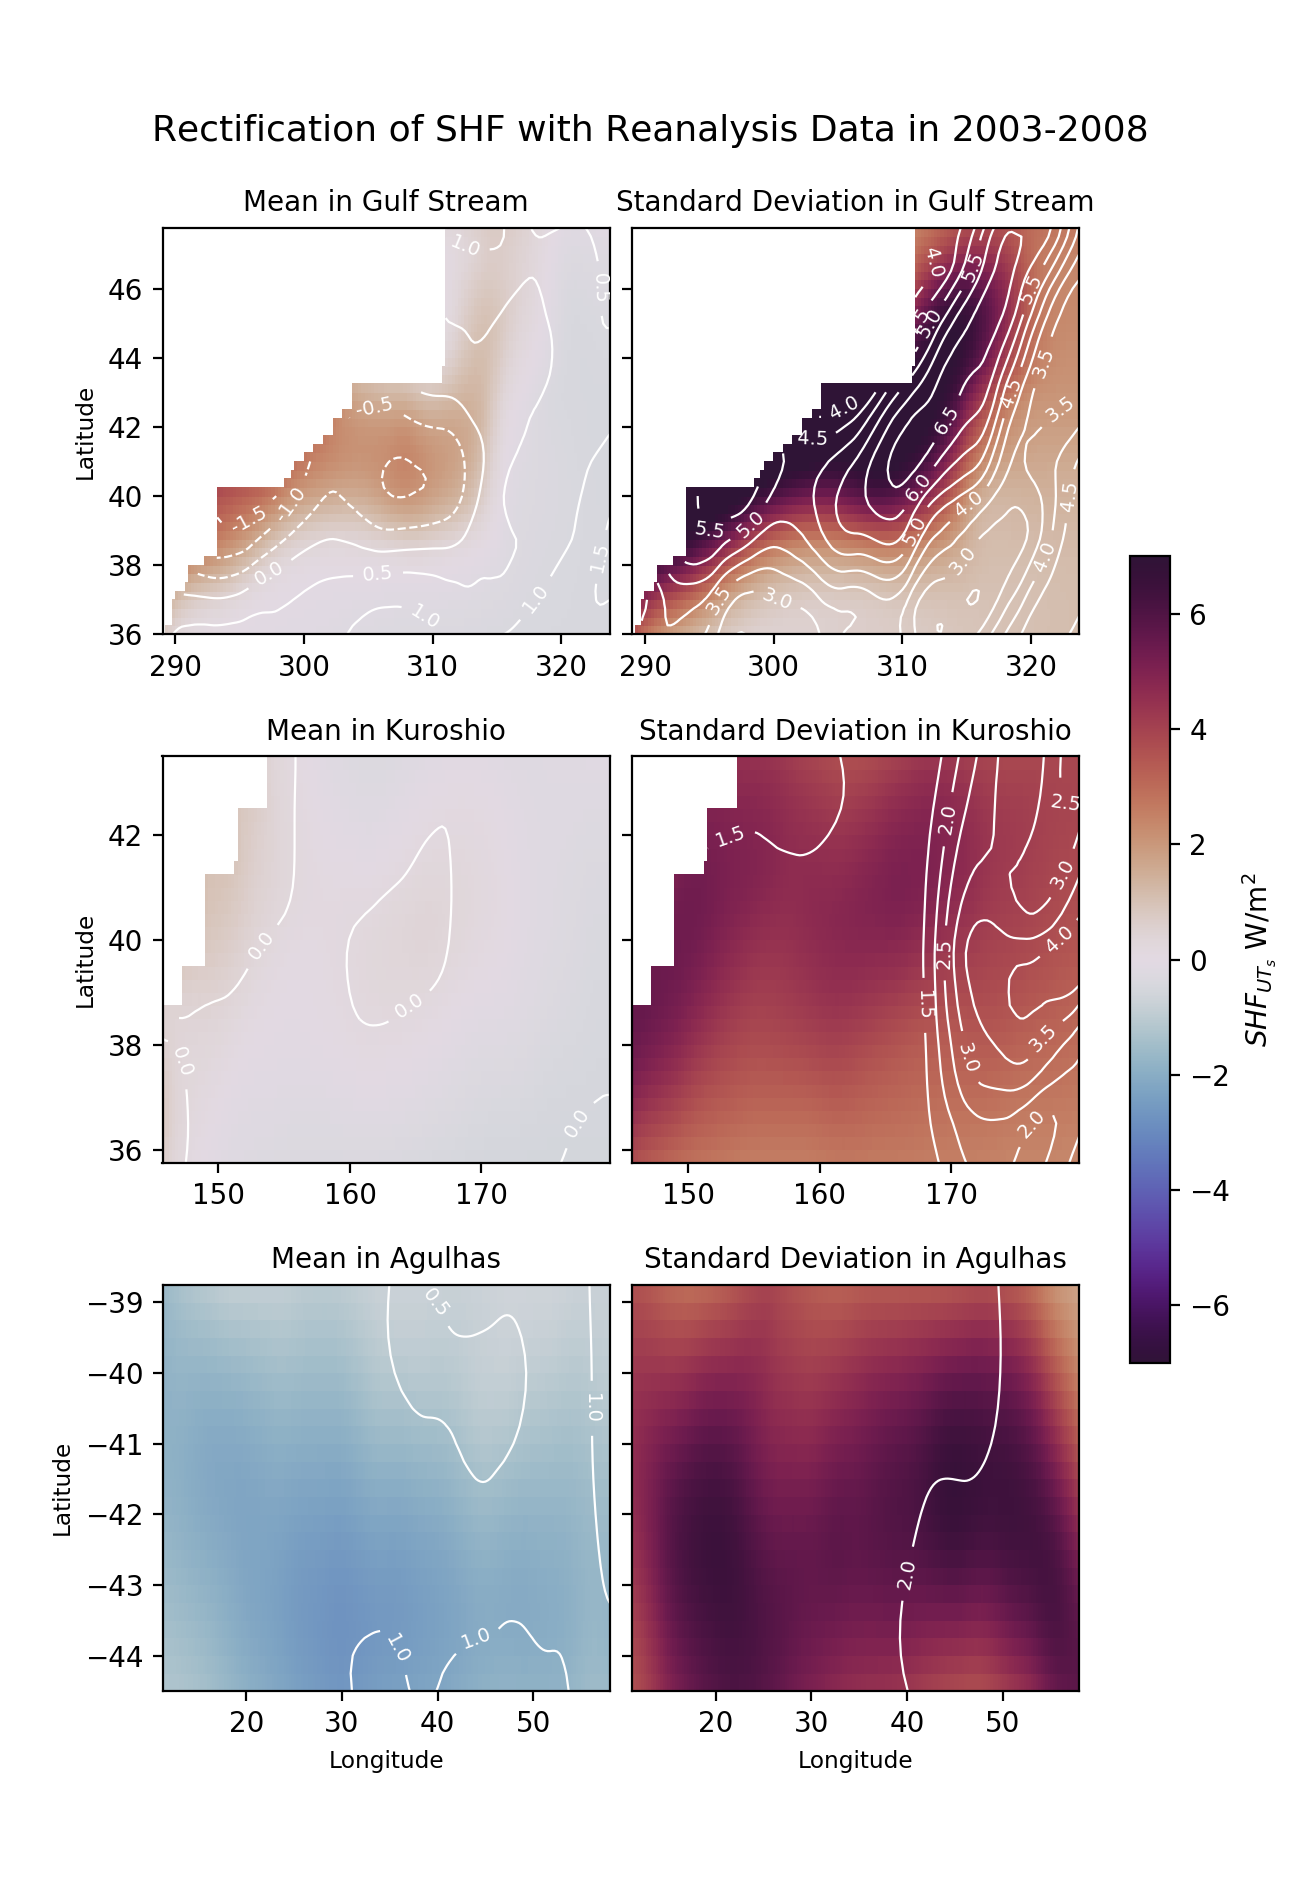

Text(0.5, 0, 'Longitude')

In [49]:
fig, axs = plt.subplots(3,2,figsize=(6.5,9.5))
fig.subplots_adjust(hspace=0.3,wspace=0.05)
fig.suptitle('Rectification of SHF with Reanalysis Data in 2003-2008',fontsize=13,x=0.5, y=.94)

#lvl=[-2,-1,0,1,2,3,4,5,6,7,8]
lvl=[-2,-1.5,-1,-.5,0,.5,1,1.5,2,2.5,3,3.5,4,4.5,5,5.5,6,6.5,7,7.5]

ax = axs[0,0]
pc = ax.pcolormesh(lon_GS,lat_GS,Qtsu_GS_mean,cmap='twilight_shifted',vmin=-7,vmax=7)
pc = ax.contour(lon_GS,lat_GS,Qtau_GS_mean,colors='white',linewidths=.8,levels=lvl)
ax.clabel(pc,inline=1, fontsize=7,fmt='%1.1f')
ax.set_title('Mean in Gulf Stream',fontsize='medium')
ax.set_ylabel('Latitude',fontsize='small')
#ax.set_xlabel('Longitude',fontsize='small')

ax = axs[0,1]
pc = ax.pcolormesh(lon_GS,lat_GS,Qtsu_GS_std,cmap='twilight_shifted',vmin=-7,vmax=7)
pc = ax.contour(lon_GS,lat_GS,Qtau_GS_std,colors='white',linewidths=.8,levels=lvl)
ax.clabel(pc,inline=1, fontsize=7,fmt='%1.1f')
ax.set_title('Standard Deviation in Gulf Stream',fontsize='medium')
plt.setp(ax.get_yticklabels(), visible=False)
#ax.set_xlabel('Longitude',fontsize='small')

ax = axs[1,0]
pc = ax.pcolormesh(lon_K,lat_K,Qtsu_K_mean,cmap='twilight_shifted',vmin=-7,vmax=7)
pc = ax.contour(lon_K,lat_K,Qtau_K_mean,colors='white',linewidths=.8,levels=lvl)
ax.clabel(pc,inline=1, fontsize=7,fmt='%1.1f')
ax.set_title('Mean in Kuroshio',fontsize='medium')
ax.set_ylabel('Latitude',fontsize='small')
#ax.set_xlabel('Longitude',fontsize='small')

ax = axs[1,1]
pc = ax.pcolormesh(lon_K,lat_K,Qtsu_K_std,cmap='twilight_shifted',vmin=-7,vmax=7)
pc = ax.contour(lon_K,lat_K,Qtau_K_std,colors='white',linewidths=.8,levels=lvl)
ax.clabel(pc,inline=1, fontsize=7,fmt='%1.1f')
ax.set_title('Standard Deviation in Kuroshio',fontsize='medium')
plt.setp(ax.get_yticklabels(), visible=False)
#ax.set_xlabel('Longitude',fontsize='small')

ax = axs[2,0]
pc = ax.pcolormesh(lon_A,lat_A,Qtsu_A_mean,cmap='twilight_shifted',vmin=-7,vmax=7)
pc = ax.contour(lon_A,lat_A,Qtau_A_mean,colors='white',linewidths=.8,levels=lvl)
ax.clabel(pc,inline=1, fontsize=7,fmt='%1.1f')
ax.set_title('Mean in Agulhas',fontsize='medium')
ax.set_xlabel('Longitude',fontsize='small')
ax.set_ylabel('Latitude',fontsize='small')

ax = axs[2,1]
pc = ax.pcolormesh(lon_A,lat_A,Qtsu_A_std,cmap='twilight_shifted',vmin=-7,vmax=7)
fig.colorbar(pc, ax=axs,fraction=0.04,label='$SHF_{UT_s}$ W/m$^2$')
pc = ax.contour(lon_A,lat_A,Qtau_A_std,colors='white',linewidths=.8,levels=lvl)
ax.clabel(pc,inline=1, fontsize=7,fmt='%1.1f')
ax.set_title('Standard Deviation in Agulhas',fontsize='medium')
plt.setp(ax.get_yticklabels(), visible=False)
ax.set_xlabel('Longitude',fontsize='small')


In [50]:
plt.savefig('PAPER_eramap_SHF.png', dpi=300, bbox_inches='tight')

<IPython.core.display.Javascript object>


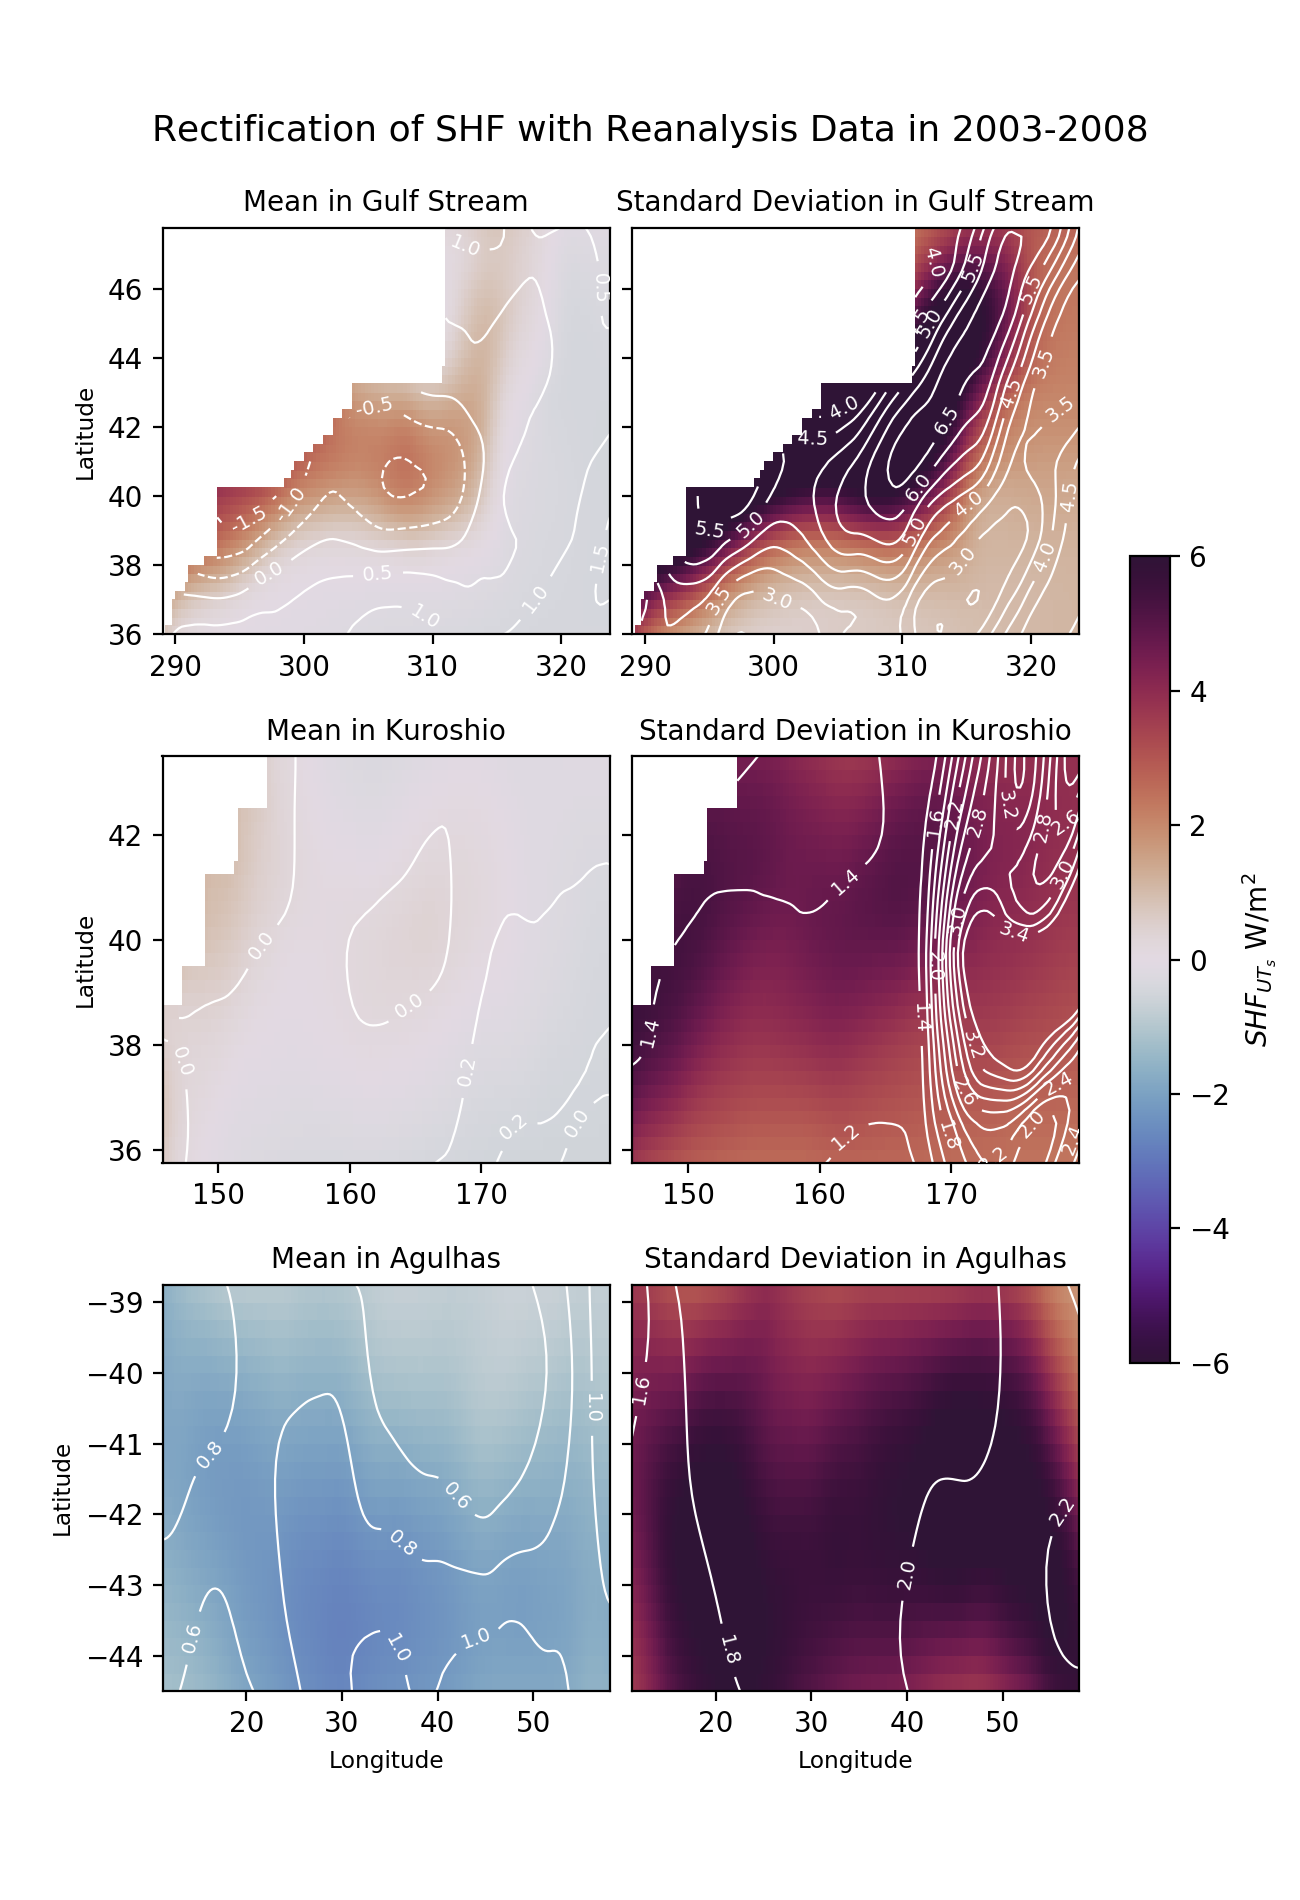

Text(0.5, 0, 'Longitude')

In [58]:
fig, axs = plt.subplots(3,2,figsize=(6.5,9.5))
fig.subplots_adjust(hspace=0.3,wspace=0.05)
fig.suptitle('Rectification of SHF with Reanalysis Data in 2003-2008',fontsize=13,x=0.5, y=.94)

#lvl=[-2,-1,0,1,2,3,4,5,6,7,8]
lvl1=[-2,-1.5,-1,-.5,0,.5,1,1.5,2,2.5,3,3.5,4,4.5,5,5.5,6,6.5,7,7.5]
lvl=[-2,-1.8,-1.6,-1.4,-1.2,-1,-.8,-.6,-.4,-.2,0,.2,.4,.6,.8,1,1.2,1.4,1.6,1.8,2,2.2,2.4,2.6,2.8,3,3.2,3.4]


ax = axs[0,0]
pc = ax.pcolormesh(lon_GS,lat_GS,Qtsu_GS_mean,cmap='twilight_shifted',vmin=-6,vmax=6)
pc = ax.contour(lon_GS,lat_GS,Qtau_GS_mean,colors='white',linewidths=.8,levels=lvl1)
ax.clabel(pc,inline=1, fontsize=7,fmt='%1.1f')
ax.set_title('Mean in Gulf Stream',fontsize='medium')
ax.set_ylabel('Latitude',fontsize='small')
#ax.set_xlabel('Longitude',fontsize='small')

ax = axs[0,1]
pc = ax.pcolormesh(lon_GS,lat_GS,Qtsu_GS_std,cmap='twilight_shifted',vmin=-6,vmax=6)
pc = ax.contour(lon_GS,lat_GS,Qtau_GS_std,colors='white',linewidths=.8,levels=lvl1)
ax.clabel(pc,inline=1, fontsize=7,fmt='%1.1f')
ax.set_title('Standard Deviation in Gulf Stream',fontsize='medium')
plt.setp(ax.get_yticklabels(), visible=False)
#ax.set_xlabel('Longitude',fontsize='small')

ax = axs[1,0]
pc = ax.pcolormesh(lon_K,lat_K,Qtsu_K_mean,cmap='twilight_shifted',vmin=-6,vmax=6)
pc = ax.contour(lon_K,lat_K,Qtau_K_mean,colors='white',linewidths=.8,levels=lvl)
ax.clabel(pc,inline=1, fontsize=7,fmt='%1.1f')
ax.set_title('Mean in Kuroshio',fontsize='medium')
ax.set_ylabel('Latitude',fontsize='small')
#ax.set_xlabel('Longitude',fontsize='small')

ax = axs[1,1]
pc = ax.pcolormesh(lon_K,lat_K,Qtsu_K_std,cmap='twilight_shifted',vmin=-6,vmax=6)
pc = ax.contour(lon_K,lat_K,Qtau_K_std,colors='white',linewidths=.8,levels=lvl)
ax.clabel(pc,inline=1, fontsize=7,fmt='%1.1f')
ax.set_title('Standard Deviation in Kuroshio',fontsize='medium')
plt.setp(ax.get_yticklabels(), visible=False)
#ax.set_xlabel('Longitude',fontsize='small')

ax = axs[2,0]
pc = ax.pcolormesh(lon_A,lat_A,Qtsu_A_mean,cmap='twilight_shifted',vmin=-6,vmax=6)
pc = ax.contour(lon_A,lat_A,Qtau_A_mean,colors='white',linewidths=.8,levels=lvl)
ax.clabel(pc,inline=1, fontsize=7,fmt='%1.1f')
ax.set_title('Mean in Agulhas',fontsize='medium')
ax.set_xlabel('Longitude',fontsize='small')
ax.set_ylabel('Latitude',fontsize='small')

ax = axs[2,1]
pc = ax.pcolormesh(lon_A,lat_A,Qtsu_A_std,cmap='twilight_shifted',vmin=-6,vmax=6)
fig.colorbar(pc, ax=axs,fraction=0.04,label='$SHF_{UT_s}$ W/m$^2$')
pc = ax.contour(lon_A,lat_A,Qtau_A_std,colors='white',linewidths=.8,levels=lvl)
ax.clabel(pc,inline=1, fontsize=7,fmt='%1.1f')
ax.set_title('Standard Deviation in Agulhas',fontsize='medium')
plt.setp(ax.get_yticklabels(), visible=False)
ax.set_xlabel('Longitude',fontsize='small')


<IPython.core.display.Javascript object>


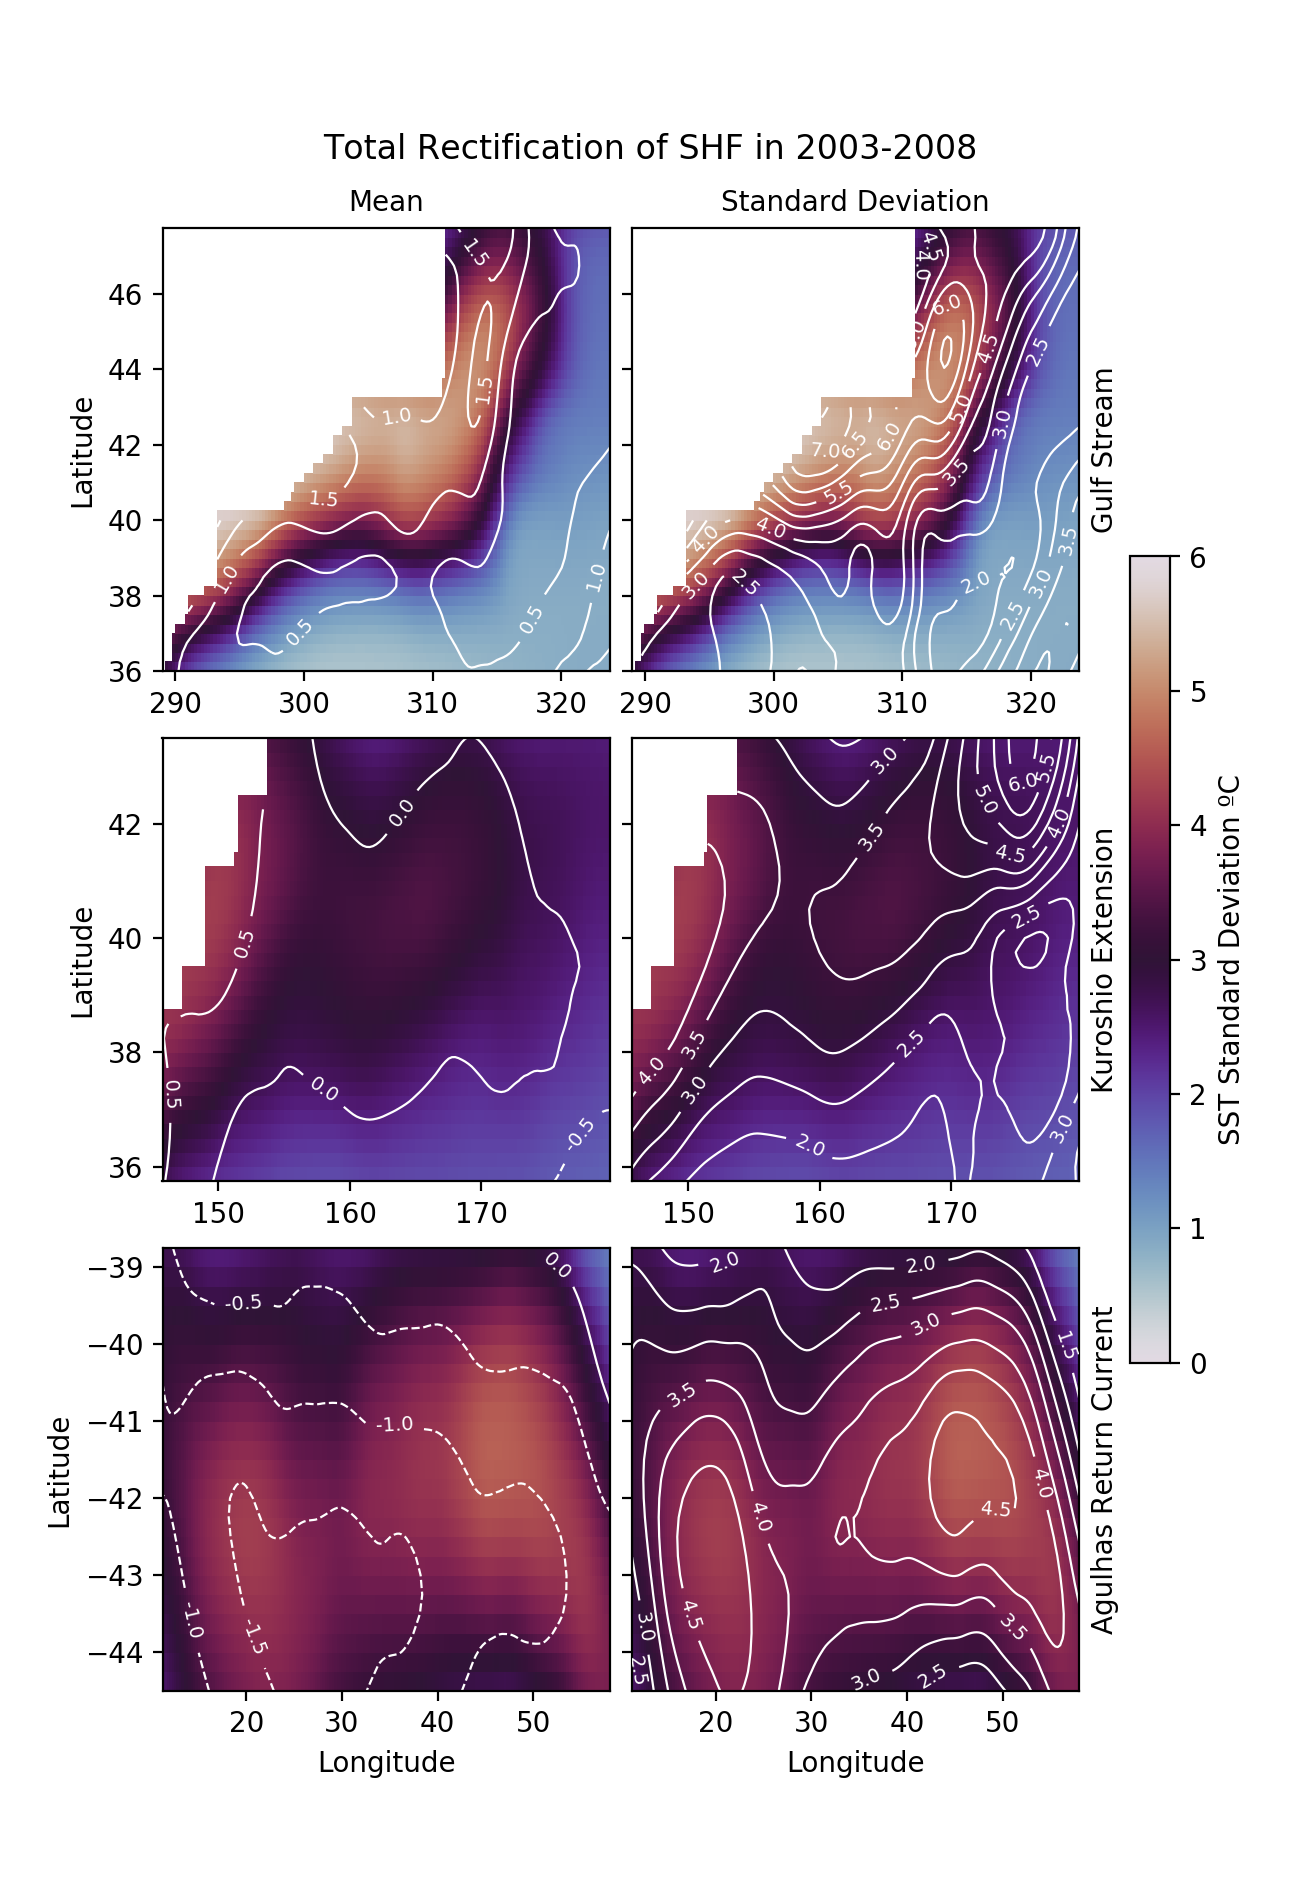

Text(1.025, 0.5, 'Agulhas Return Current')

In [57]:
fig, axs = plt.subplots(3,2,figsize=(6.5,9.5))
fig.subplots_adjust(hspace=0.15,wspace=0.05)
fig.suptitle('Total Rectification of SHF in 2003-2008',fontsize=12,x=0.5, y=.93)

lvl=[-4,-3.5,-3,-2.5,-2,-1.5,-1,-.5,0,.5,1,1.5,2,2.5,3,3.55,4,4.5,5,5.5,6,6.5,7,7.5,8]

ax = axs[0,0]
pc = ax.pcolormesh(lon_GS,lat_GS,sststd_GS_mean,cmap='twilight',vmin=0,vmax=6)
pc = ax.contour(lon_GS,lat_GS,nonlin_GS_mean,colors='white',linewidths=.8,levels=lvl)
ax.clabel(pc,inline=1, fontsize=7,fmt='%1.1f')
ax.set_title('Mean',fontsize='medium')
ax.set_ylabel('Latitude',fontsize='medium')

ax = axs[0,1]
pc = ax.pcolormesh(lon_GS,lat_GS,sststd_GS_mean,cmap='twilight',vmin=0,vmax=6)
pc = ax.contour(lon_GS,lat_GS,nonlin_GS_std,colors='white',linewidths=.8,levels=lvl)
ax.clabel(pc,inline=1, fontsize=7,fmt='%1.1f')
ax.set_title('Standard Deviation',fontsize='medium')
plt.setp(ax.get_yticklabels(), visible=False)
ax.text(1.025,0.5,"Gulf Stream", size=10, verticalalignment='center', rotation=90,transform=ax.transAxes)

ax = axs[1,0]
pc = ax.pcolormesh(lon_K,lat_K,sststd_K_mean,cmap='twilight',vmin=0,vmax=6)
pc = ax.contour(lon_K,lat_K,nonlin_K_mean,colors='white',linewidths=.8,levels=lvl)
ax.clabel(pc,inline=1, fontsize=7,fmt='%1.1f')
ax.set_ylabel('Latitude',fontsize='medium')

ax = axs[1,1]
pc = ax.pcolormesh(lon_K,lat_K,sststd_K_mean,cmap='twilight',vmin=0,vmax=6)
pc = ax.contour(lon_K,lat_K,nonlin_K_std,colors='white',linewidths=.8,levels=lvl)
ax.clabel(pc,inline=1, fontsize=7,fmt='%1.1f')
plt.setp(ax.get_yticklabels(), visible=False)
ax.text(1.025,0.5,"Kuroshio Extension", size=10, verticalalignment='center', rotation=90,transform=ax.transAxes)

ax = axs[2,0]
pc = ax.pcolormesh(lon_A,lat_A,sststd_A_mean,cmap='twilight',vmin=0,vmax=6)
pc = ax.contour(lon_A,lat_A,nonlin_A_mean,colors='white',linewidths=.8,levels=lvl)
ax.clabel(pc,inline=1, fontsize=7,fmt='%1.1f')
ax.set_xlabel('Longitude',fontsize='medium')
ax.set_ylabel('Latitude',fontsize='medium')

ax = axs[2,1]
pc = ax.pcolormesh(lon_A,lat_A,sststd_A_mean,cmap='twilight',vmin=0,vmax=6)
fig.colorbar(pc, ax=axs,fraction=0.04,label='SST Standard Deviation ºC')
pc = ax.contour(lon_A,lat_A,nonlin_A_std,colors='white',linewidths=.8,levels=lvl)
ax.clabel(pc,inline=1, fontsize=7,fmt='%1.1f')
plt.setp(ax.get_yticklabels(), visible=False)
ax.set_xlabel('Longitude',fontsize='medium')
ax.text(1.025,0.5,"Agulhas Return Current", size=10, verticalalignment='center', rotation=90,transform=ax.transAxes)



In [58]:
plt.savefig('PAPER_SHFmap.png', dpi=300, bbox_inches='tight')

## Monthly Average

In [ ]:
Qtsu_mmeanGS, ym, m_str = monthly_avg(Qtsu_GS, day)
Qtau_mmeanGS, _, _ = monthly_avg(Qtau_GS, day)

Qtsu_mmeanK, _, _ = monthly_avg(Qtsu_K, day)
Qtau_mmeanK, _, _ = monthly_avg(Qtau_K, day)

Qtsu_mmeanA, _, _ = monthly_avg(Qtsu_A, day)
Qtau_mmeanA, _, _ = monthly_avg(Qtau_A, day)


In [ ]:
fig, axs = plt.subplots(nrows=3)
fig.subplots_adjust(hspace=1)

j = np.arange(0, len(m_str)+1, 6)
j[-1] = j[-1]-1
m_str_short = [m_str[j[a]] for a in range(len(j))]
i = np.arange(0, len(m_str)+1, 6)

ax = axs[0]
ax.plot(m_str,Qtau_mmeanGS,label='$Q_{TaU}$')
ax.plot(m_str,Qtsu_mmeanGS,label='$Q_{TsU}$')
ax.legend(loc='upper right', fontsize='x-small',ncol=1,bbox_to_anchor=(1.009, 1.55))
ax.set_title('Monthly Averaged $Q_{TaU}$ and $Q_{TsU}$ in Gulf Stream',fontsize='medium')
ax.set_ylabel('$W/m^2$',fontsize='small')
ax.set_xticks(i)
ax.set_xticklabels(m_str_short, rotation=17,fontsize='small')
ax.set_ylim([-2.5,4])
ax.grid()

ax = axs[1]
ax.plot(m_str,Qtau_mmeanK,label='$Q_{TaU}$')
ax.plot(m_str,Qtsu_mmeanK,label='$Q_{TsU}$')
#ax.legend(loc='upper right', fontsize='x-small',ncol=1,bbox_to_anchor=(1.009, 1.4))
ax.set_title('Monthly Averaged $Q_{TaU}$ and $Q_{TsU}$ in Kuroshio',fontsize='medium')
ax.set_ylabel('$W/m^2$',fontsize='small')
ax.set_xticks(i)
ax.set_xticklabels(m_str_short, rotation=17,fontsize='small')
ax.set_ylim([-2.5,4])
ax.grid()

ax = axs[2]
ax.plot(m_str,Qtau_mmeanA,label='$Q_{TaU}$')
ax.plot(m_str,Qtsu_mmeanA,label='$Q_{TsU}$')
#ax.legend(loc='upper right', fontsize='x-small',ncol=1,bbox_to_anchor=(1.009, 1.4))
ax.set_title('Monthly Averaged $Q_{TaU}$ and $Q_{TsU}$ in Agulhas',fontsize='medium')
ax.set_ylabel('$W/m^2$',fontsize='small')
ax.set_xlabel('Date',fontsize='small')
ax.set_xticks(i)
ax.set_xticklabels(m_str_short, rotation=17,fontsize='small')
ax.set_ylim([-2.5,4])
ax.grid()


In [ ]:
plt.savefig('QS_monthlynonlinearities_era.png', dpi=300, bbox_inches='tight')


## "Histograms" 

In [68]:
def makehistcount(varr,varh,br,bh):
    '''
    r will be y-axis and h will be x-axis
    br and bh is the box size of the histogram
    result counts the instances that data exists within the boxes
    '''

    
    #create "boxes" that sort our histogram and will be the x and y axis when we plot
    #r = np.arange(np.floor(np.nanmin(varr)),np.floor(np.nanmax(varr)),dr)
    r = np.linspace(np.nanmin(varr),np.nanmax(varr),br)
    dr = (np.nanmax(varr)-np.nanmin(varr))/br
    h = np.linspace(np.nanmin(varh),np.nanmax(varh),bh)
    dh = (np.nanmax(varh)-np.nanmin(varh))/bh
    
    #create resulting histogram matrix that will be plotted
    hist = np.zeros([len(r),len(h)],dtype=float)

    i = 0
    j = 0
    for i in range(len(r)):
        
        temp = varh[np.where((r[i] <= varr) & (r[i] + dr > varr))]
        
        for j in range(len(h)):
            
            hist[i,j] = np.count_nonzero((h[j] <= temp) & (h[j] + dh > temp))

    return r, h, hist

In [69]:
def makehistavg(varr,varh,varavg,br,bh):
    '''
    r will be y-axis and h will be x-axis
    br and bh is the box size of the histogram
    results average the varavg 
    '''

    
    #create "boxes" that sort our histogram and will be the x and y axis when we plot
    #r = np.arange(np.floor(np.nanmin(varr)),np.floor(np.nanmax(varr)),dr)
    r = np.linspace(np.nanmin(varr),np.nanmax(varr),br)
    dr = (np.nanmax(varr)-np.nanmin(varr))/br
    h = np.linspace(np.nanmin(varh),np.nanmax(varh),bh)
    dh = (np.nanmax(varh)-np.nanmin(varh))/bh
    
    #create resulting histogram matrix that will be plotted
    hist = np.zeros([len(r),len(h)],dtype=float)

    i = 0
    j = 0
    for i in range(len(r)):
        
        idxr = np.where((r[i] <= varr) & (r[i] + dr > varr))
        temp_varh = varh[idxr]
        temp_varavg = varavg[idxr]        
        
        for j in range(len(h)):
            
            idxh = np.where((h[j] <= temp_varh) & (h[j] + dh > temp_varh))
            hist[i,j] = np.nanmean(temp_varavg[idxh])

    return r, h, hist


In [70]:
def makehiststd(varr,varh,varavg,br,bh):
    '''
    r will be y-axis and h will be x-axis
    br and bh is the box size of the histogram
    results average the varavg 
    '''

    
    #create "boxes" that sort our histogram and will be the x and y axis when we plot
    #r = np.arange(np.floor(np.nanmin(varr)),np.floor(np.nanmax(varr)),dr)
    r = np.linspace(np.nanmin(varr),np.nanmax(varr),br)
    dr = (np.nanmax(varr)-np.nanmin(varr))/br
    h = np.linspace(np.nanmin(varh),np.nanmax(varh),bh)
    dh = (np.nanmax(varh)-np.nanmin(varh))/bh
    
    #create resulting histogram matrix that will be plotted
    hist = np.zeros([len(r),len(h)],dtype=float)

    i = 0
    j = 0
    for i in range(len(r)):
        
        idxr = np.where((r[i] <= varr) & (r[i] + dr > varr))
        temp_varh = varh[idxr]
        temp_varavg = varavg[idxr]        
        
        for j in range(len(h)):
            
            idxh = np.where((h[j] <= temp_varh) & (h[j] + dh > temp_varh))
            hist[i,j] = np.nanstd(temp_varavg[idxh])

    return r, h, hist


In [71]:
def makehistcount3x(varr1,varr2,varr3,varh1,varh2,varh3,br,bh):
    '''
    r will be y-axis and h will be x-axis
    br and bh is the box size of the histogram
    result counts the instances that data exists within the boxes
    '''

    #create "boxes" that sort our histogram and will be the x and y axis when we plot
    rmin = [np.nanmin(varr1),np.nanmin(varr2),np.nanmin(varr3)]
    rmax = [np.nanmax(varr1),np.nanmax(varr2),np.nanmax(varr3)]
    r = np.linspace(np.nanmin(rmin),np.nanmax(rmax),br) 
    dr = (np.nanmax(rmax)-np.nanmin(rmin))/br    
    
    hmin = [np.nanmin(varh1),np.nanmin(varh2),np.nanmin(varh3)]
    hmax = [np.nanmax(varh1),np.nanmax(varh2),np.nanmax(varh3)]
    h = np.linspace(np.nanmin(hmin),np.nanmax(hmax),bh)
    dh = (np.nanmax(hmax)-np.nanmin(hmin))/bh  
    
    #create resulting histogram matrix that will be plotted
    hist1 = np.zeros([len(r),len(h)],dtype=float)
    hist2 = np.zeros([len(r),len(h)],dtype=float)
    hist3 = np.zeros([len(r),len(h)],dtype=float)
    
    i = 0
    j = 0
    for i in range(len(r)):
        
        temp1 = varh1[np.where((r[i] <= varr1) & (r[i] + dr > varr1))]
        temp2 = varh2[np.where((r[i] <= varr2) & (r[i] + dr > varr2))]
        temp3 = varh3[np.where((r[i] <= varr3) & (r[i] + dr > varr3))]
        
        for j in range(len(h)):
            
            hist1[i,j] = np.count_nonzero((h[j] <= temp1) & (h[j] + dh > temp1))
            hist2[i,j] = np.count_nonzero((h[j] <= temp2) & (h[j] + dh > temp2))
            hist3[i,j] = np.count_nonzero((h[j] <= temp3) & (h[j] + dh > temp3))
            
    return r, h, hist1, hist2, hist3


In [72]:
def makehistavg3x(varr1,varr2,varr3,varh1,varh2,varh3,varavg1,varavg2,varavg3,br,bh):
    '''
    r will be y-axis and h will be x-axis
    br and bh is the box size of the histogram
    results average the varavg 
    '''

    
    #create "boxes" that sort our histogram and will be the x and y axis when we plot
    rmin = [np.nanmin(varr1),np.nanmin(varr2),np.nanmin(varr3)]
    rmax = [np.nanmax(varr1),np.nanmax(varr2),np.nanmax(varr3)]
    r = np.linspace(np.nanmin(rmin),np.nanmax(rmax),br) 
    dr = (np.nanmax(rmax)-np.nanmin(rmin))/br
    
    hmin = [np.nanmin(varh1),np.nanmin(varh2),np.nanmin(varh3)]
    hmax = [np.nanmax(varh1),np.nanmax(varh2),np.nanmax(varh3)]
    h = np.linspace(np.nanmin(hmin),np.nanmax(hmax),bh)
    dh = (np.nanmax(hmax)-np.nanmin(hmin))/bh   
    
    #create resulting histogram matrix that will be plotted
    hist1 = np.zeros([len(r),len(h)],dtype=float)
    hist2 = np.zeros([len(r),len(h)],dtype=float)
    hist3 = np.zeros([len(r),len(h)],dtype=float)

    i = 0
    j = 0
    for i in range(len(r)):
        
        idxr1 = np.where((r[i] <= varr1) & (r[i] + dr > varr1))
        temp_varh1 = varh1[idxr1]
        temp_varavg1 = varavg1[idxr1] 
        
        idxr2 = np.where((r[i] <= varr2) & (r[i] + dr > varr2))
        temp_varh2 = varh2[idxr2]
        temp_varavg2 = varavg2[idxr2] 
        
        idxr3 = np.where((r[i] <= varr3) & (r[i] + dr > varr3))
        temp_varh3 = varh3[idxr3]
        temp_varavg3 = varavg3[idxr3] 
        
        for j in range(len(h)):
            
            idxh1 = np.where((h[j] <= temp_varh1) & (h[j] + dh > temp_varh1))
            hist1[i,j] = np.nanmean(temp_varavg1[idxh1])

            idxh2 = np.where((h[j] <= temp_varh2) & (h[j] + dh > temp_varh2))
            hist2[i,j] = np.nanmean(temp_varavg2[idxh2])
            
            idxh3 = np.where((h[j] <= temp_varh3) & (h[j] + dh > temp_varh3))
            hist3[i,j] = np.nanmean(temp_varavg3[idxh3])
            
    return r, h, hist1, hist2, hist3


In [73]:
def makehiststd3x(varr1,varr2,varr3,varh1,varh2,varh3,varavg1,varavg2,varavg3,br,bh):
    '''
    r will be y-axis and h will be x-axis
    br and bh is the box size of the histogram
    results average the varavg 
    '''

    
    #create "boxes" that sort our histogram and will be the x and y axis when we plot
    rmin = [np.nanmin(varr1),np.nanmin(varr2),np.nanmin(varr3)]
    rmax = [np.nanmax(varr1),np.nanmax(varr2),np.nanmax(varr3)]
    r = np.linspace(np.nanmin(rmin),np.nanmax(rmax),br) 
    dr = (np.nanmax(rmax)-np.nanmin(rmin))/br
    
    hmin = [np.nanmin(varh1),np.nanmin(varh2),np.nanmin(varh3)]
    hmax = [np.nanmax(varh1),np.nanmax(varh2),np.nanmax(varh3)]
    h = np.linspace(np.nanmin(hmin),np.nanmax(hmax),bh)
    dh = (np.nanmax(hmax)-np.nanmin(hmin))/bh   
    
    #create resulting histogram matrix that will be plotted
    hist1 = np.zeros([len(r),len(h)],dtype=float)
    hist2 = np.zeros([len(r),len(h)],dtype=float)
    hist3 = np.zeros([len(r),len(h)],dtype=float)

    i = 0
    j = 0
    for i in range(len(r)):
        
        idxr1 = np.where((r[i] <= varr1) & (r[i] + dr > varr1))
        temp_varh1 = varh1[idxr1]
        temp_varavg1 = varavg1[idxr1] 
        
        idxr2 = np.where((r[i] <= varr2) & (r[i] + dr > varr2))
        temp_varh2 = varh2[idxr2]
        temp_varavg2 = varavg2[idxr2] 
        
        idxr3 = np.where((r[i] <= varr3) & (r[i] + dr > varr3))
        temp_varh3 = varh3[idxr3]
        temp_varavg3 = varavg3[idxr3] 
        
        for j in range(len(h)):
            
            idxh1 = np.where((h[j] <= temp_varh1) & (h[j] + dh > temp_varh1))
            hist1[i,j] = np.nanstd(temp_varavg1[idxh1])

            idxh2 = np.where((h[j] <= temp_varh2) & (h[j] + dh > temp_varh2))
            hist2[i,j] = np.nanstd(temp_varavg2[idxh2])
            
            idxh3 = np.where((h[j] <= temp_varh3) & (h[j] + dh > temp_varh3))
            hist3[i,j] = np.nanstd(temp_varavg3[idxh3])
            
    return r, h, hist1, hist2, hist3


In [74]:
import matplotlib as mpl
from matplotlib.colors import LinearSegmentedColormap

cdict3 = {'red':  ((0.0, 0.0, 0.0),
                   (0.25, 0.0, 0.0),
                   (0.5, 0.8, 1.0),
                   (0.75, 1.0, 1.0),
                   (1.0, 0.4, 1.0)),

          'green': ((0.0, 0.0, 0.0),
                    (0.25, 0.0, 0.0),
                    (0.5, 0.9, 0.9),
                    (0.75, 0.0, 0.0),
                    (1.0, 0.0, 0.0)),

          'blue':  ((0.0, 0.0, 0.4),
                    (0.25, 1.0, 1.0),
                    (0.5, 1.0, 0.8),
                    (0.75, 0.0, 0.0),
                    (1.0, 0.0, 0.0))
          }

mpl.cm.register_cmap('BlueRed3',LinearSegmentedColormap('BlueRed3', cdict3))


## Total Rectification PDFs

In [75]:
nonlin_GS = np.add(Qtsu_GS,Qtau_GS)
nonlin_K = np.add(Qtsu_K,Qtau_K)
nonlin_A = np.add(Qtsu_A,Qtau_A)


In [76]:
wGS=np.empty(wdirsm_GS.shape)
wGS[np.where(wdirsm_GS <= 180)]=wdirsm_GS[np.where(wdirsm_GS <= 180)]+180
wGS[np.where(wdirsm_GS > 180)]=wdirsm_GS[np.where(wdirsm_GS > 180)]-180

wK=np.empty(wdirsm_K.shape)
wK[np.where(wdirsm_K <= 180)]=wdirsm_K[np.where(wdirsm_K <= 180)]+180
wK[np.where(wdirsm_K > 180)]=wdirsm_K[np.where(wdirsm_K > 180)]-180

wA=np.empty(wdirsm_A.shape)
wA[np.where(wdirsm_A <= 180)]=wdirsm_A[np.where(wdirsm_A <= 180)]+180
wA[np.where(wdirsm_A > 180)]=wdirsm_A[np.where(wdirsm_A > 180)]-180


In [78]:
r, h, hist_GS, hist_K, hist_A = makehistavg3x(wspdsm_GS,wspdsm_K,wspdsm_A,wGS,wK,wA,nonlin_GS,nonlin_K,nonlin_A,100,100)
r, h, histstd_GS, histstd_K, histstd_A = makehiststd3x(wspdsm_GS,wspdsm_K,wspdsm_A,wGS,wK,wA,nonlin_GS,nonlin_K,nonlin_A,100,100)

hist_GS[np.where(hist_GS  == 0.0)] = None
hist_K[np.where(hist_K == 0.0)] = None
hist_A[np.where(hist_A == 0.0)] = None

histstd_GS[np.where(histstd_GS == 0.0)] = None
histstd_K[np.where(histstd_K == 0.0)] = None
histstd_A[np.where(histstd_A == 0.0)] = None

#####

r2, h2, hist_GS2, hist_K2, hist_A2 = makehistavg3x(tasm_GS,tasm_K,tasm_A,sstsm_GS,sstsm_K,sstsm_A,nonlin_GS,nonlin_K,nonlin_A,100,100)
r2, h2, histstd_GS2, histstd_K2, histstd_A2 = makehiststd3x(tasm_GS,tasm_K,tasm_A,sstsm_GS,sstsm_K,sstsm_A,nonlin_GS,nonlin_K,nonlin_A,100,100)

hist_GS2[np.where(hist_GS2 == 0.0)] = None
hist_K2[np.where(hist_K2== 0.0)] = None
hist_A2[np.where(hist_A2== 0.0)] = None

histstd_GS2[np.where(histstd_GS2 == 0.0)] = None
histstd_K2[np.where(histstd_K2 == 0.0)] = None
histstd_A2[np.where(histstd_A2 == 0.0)] = None



/Users/baileydonaldson/Python/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: Mean of empty slice
/Users/baileydonaldson/Python/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: Mean of empty slice
/Users/baileydonaldson/Python/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1666: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/Users/baileydonaldson/Python/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/Users/baileydonaldson/Python/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less


<IPython.core.display.Javascript object>


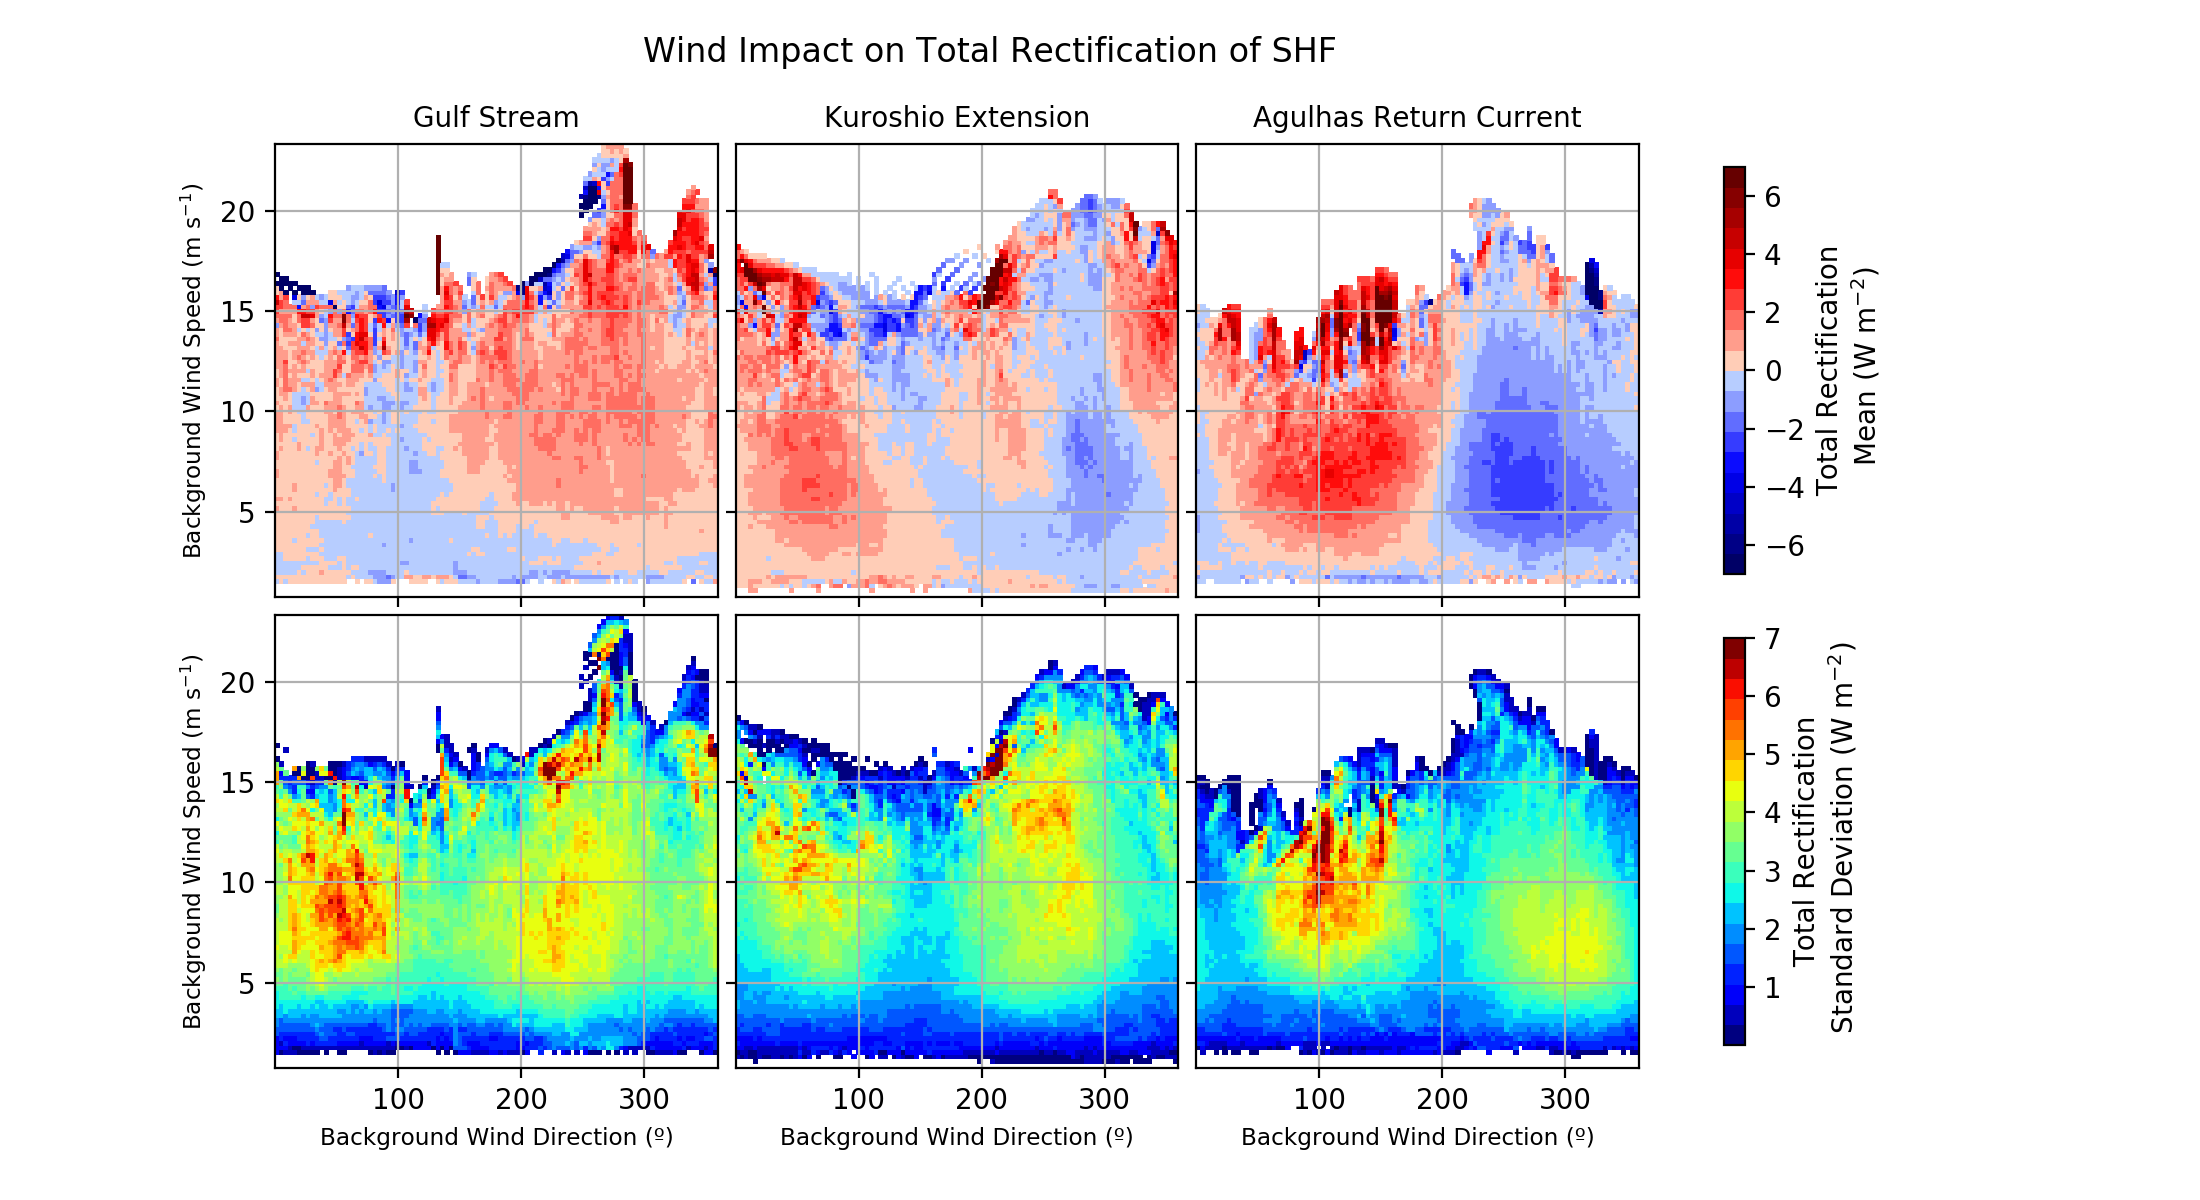

In [79]:
fig, axs = plt.subplots(2,3,figsize=(11,6))
fig.subplots_adjust(wspace=.04,hspace=0.04)
fig.suptitle('Wind Impact on Total Rectification of SHF', fontsize=12,x=0.45, y=.97)

ax = axs[0,0]
pc = ax.pcolormesh(h,r,hist_GS,cmap=cm.get_cmap('BlueRed3', 20),vmin=-7,vmax=7)
ax.set_title("Gulf Stream",fontsize='medium')
ax.set_ylabel("Background Wind Speed (m s$^{-1}$)",fontsize='small')
plt.setp(ax.get_xticklabels(), visible=False)
ax.grid()

ax = axs[0,1]
pc = ax.pcolormesh(h,r,hist_K,cmap=cm.get_cmap('BlueRed3', 20),vmin=-7,vmax=7)
ax.set_title("Kuroshio Extension",fontsize='medium')
plt.setp(ax.get_xticklabels(), visible=False)
plt.setp(ax.get_yticklabels(), visible=False)
ax.grid()

ax = axs[0,2]
pc = ax.pcolormesh(h,r,hist_A,cmap=cm.get_cmap('BlueRed3', 20),vmin=-7,vmax=7)
ax.set_title("Agulhas Return Current",fontsize='medium')
fig.colorbar(pc,ax=axs[0],label="Total Rectification\n Mean (W m$^{-2}$)",shrink=.9)
plt.setp(ax.get_xticklabels(), visible=False)
plt.setp(ax.get_yticklabels(), visible=False)
ax.grid()

######

ax = axs[1,0]
pc = ax.pcolormesh(h,r,histstd_GS,cmap=cm.get_cmap('jet', 20),vmax=7)
ax.set_ylabel("Background Wind Speed (m s$^{-1}$)",fontsize='small')
ax.set_xlabel("Background Wind Direction (º)",fontsize='small')
ax.grid()

ax = axs[1,1]
pc = ax.pcolormesh(h,r,histstd_K,cmap=cm.get_cmap('jet', 20),vmax=7)
plt.setp(ax.get_yticklabels(), visible=False)
ax.set_xlabel("Background Wind Direction (º)",fontsize='small')
ax.grid()

ax = axs[1,2]
pc = ax.pcolormesh(h,r,histstd_A,cmap=cm.get_cmap('jet', 20),vmax=7)
fig.colorbar(pc,ax=axs[1],label="Total Rectification\n Standard Deviation (W m$^{-2}$)",shrink=.9)
ax.set_xlabel("Background Wind Direction (º)",fontsize='small')
plt.setp(ax.get_yticklabels(), visible=False)
ax.grid()



In [80]:
plt.savefig('PAPER_PDFU_SHF.png', dpi=300, bbox_inches='tight')


<IPython.core.display.Javascript object>


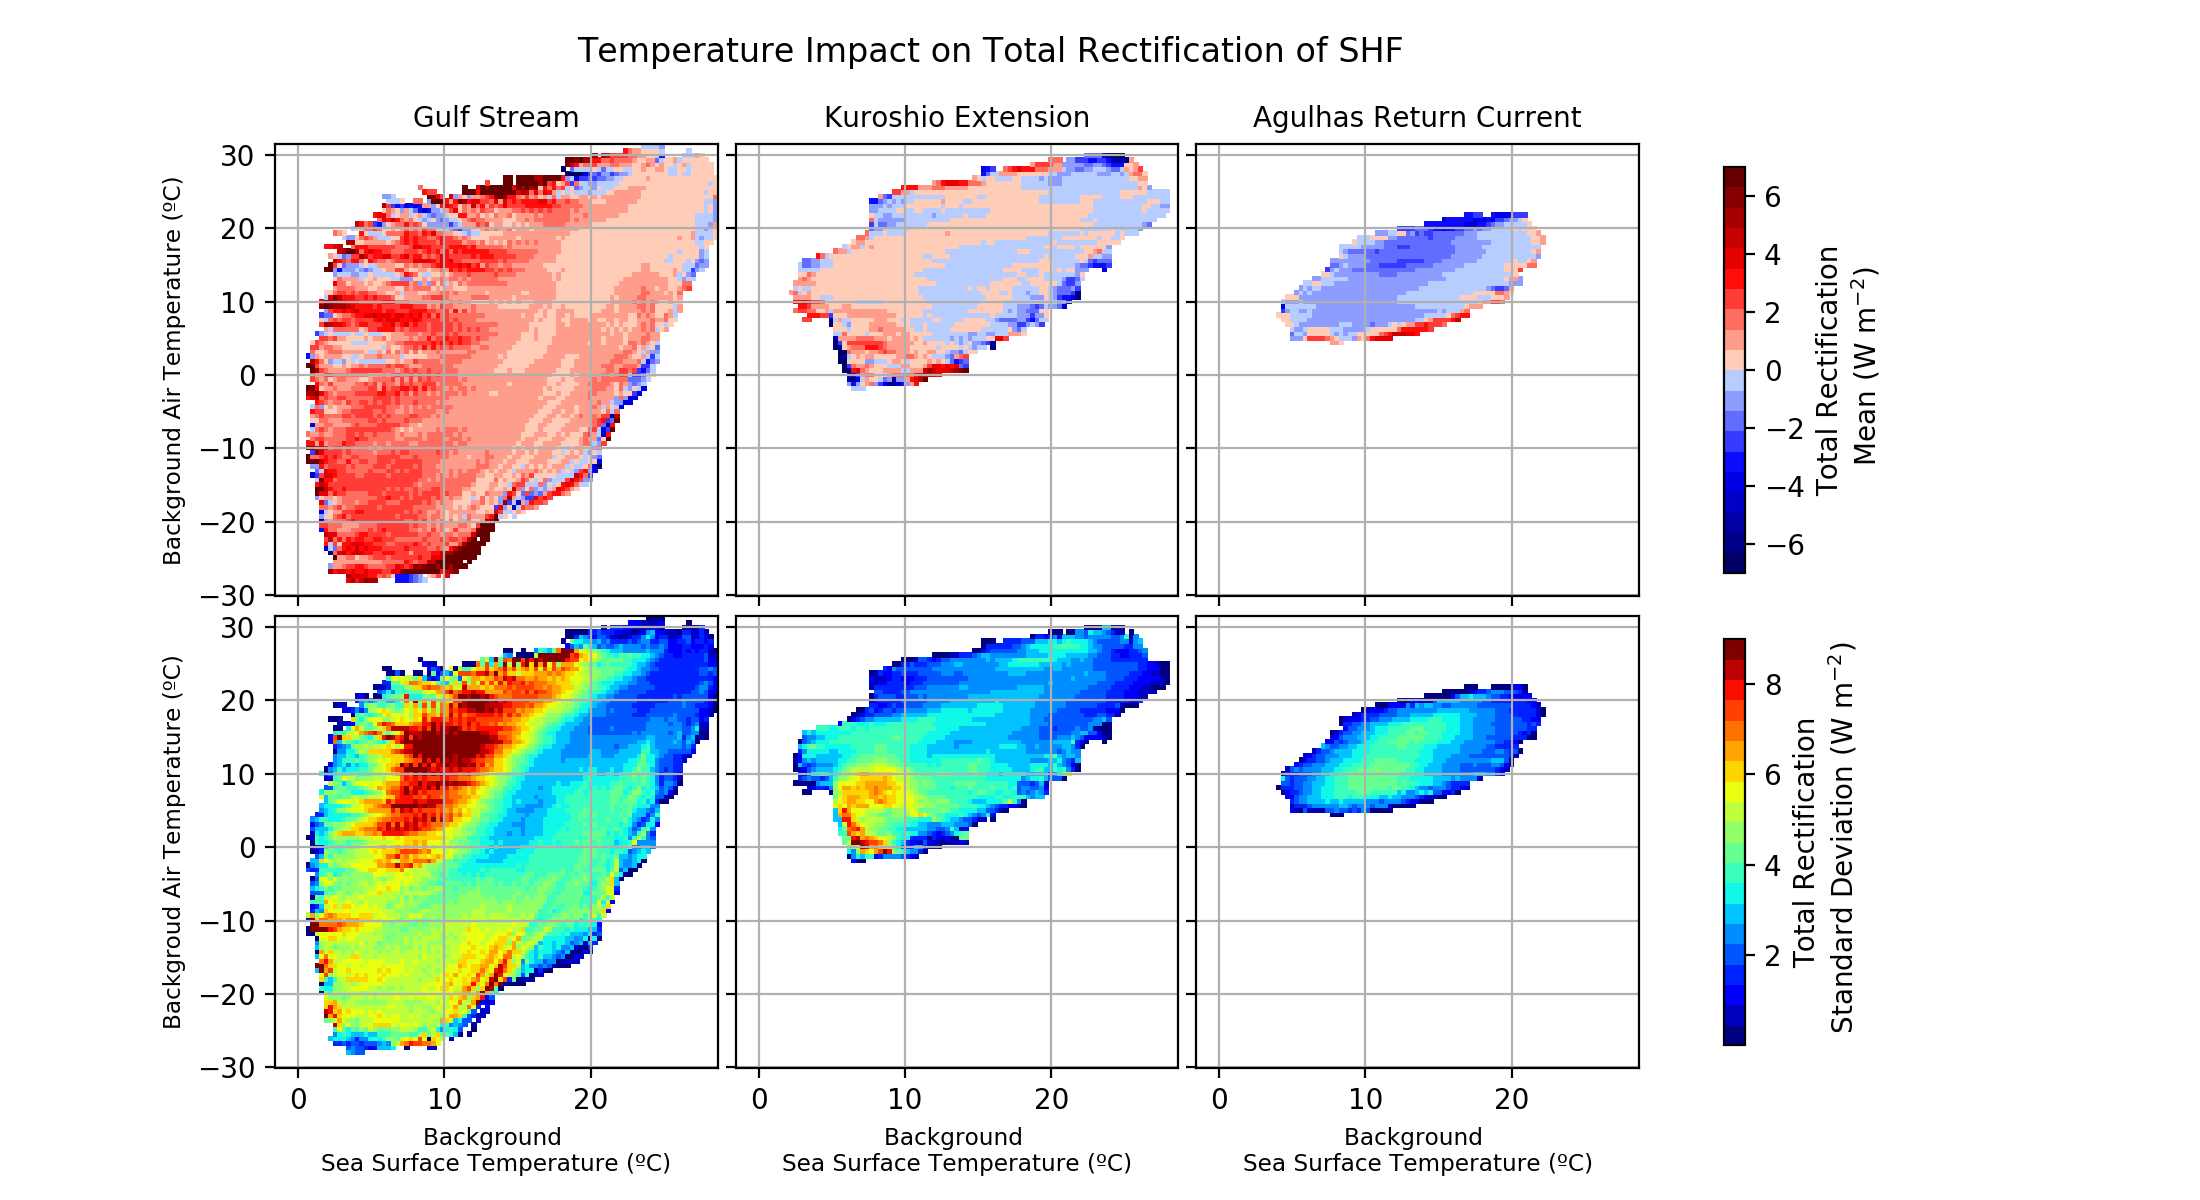

In [82]:
fig, axs = plt.subplots(2,3,figsize=(11,6))
fig.subplots_adjust(wspace=.04,hspace=0.045)
fig.suptitle('Temperature Impact on Total Rectification of SHF', fontsize=12,x=0.45, y=.97)

ax = axs[0,0]
pc = ax.pcolormesh(h2,r2,hist_GS2,cmap=cm.get_cmap('BlueRed3', 20),vmin=-7,vmax=7)
ax.set_title("Gulf Stream",fontsize='medium')
ax.set_ylabel("Background Air Temperature (ºC)",fontsize='small')
plt.setp(ax.get_xticklabels(), visible=False)
ax.grid()

ax = axs[0,1]
pc = ax.pcolormesh(h2,r2,hist_K2,cmap=cm.get_cmap('BlueRed3', 20),vmin=-7,vmax=7)
ax.set_title("Kuroshio Extension",fontsize='medium')
plt.setp(ax.get_xticklabels(), visible=False)
plt.setp(ax.get_yticklabels(), visible=False)
ax.grid()

ax = axs[0,2]
pc = ax.pcolormesh(h2,r2,hist_A2,cmap=cm.get_cmap('BlueRed3', 20),vmin=-7,vmax=7)
ax.set_title("Agulhas Return Current",fontsize='medium')
fig.colorbar(pc,ax=axs[0],label="Total Rectification\n Mean (W m$^{-2}$)",shrink=.9)
plt.setp(ax.get_xticklabels(), visible=False)
plt.setp(ax.get_yticklabels(), visible=False)
ax.grid()

######

ax = axs[1,0]
pc = ax.pcolormesh(h2,r2,histstd_GS2,cmap=cm.get_cmap('jet', 20),vmax=9)
ax.set_ylabel("Backgroud Air Temperature (ºC)",fontsize='small')
ax.set_xlabel("Background \nSea Surface Temperature (ºC)",fontsize='small')
ax.grid()

ax = axs[1,1]
pc = ax.pcolormesh(h2,r2,histstd_K2,cmap=cm.get_cmap('jet', 20),vmax=9)
plt.setp(ax.get_yticklabels(), visible=False)
ax.set_xlabel("Background \nSea Surface Temperature (ºC)",fontsize='small')
ax.grid()

ax = axs[1,2]
pc = ax.pcolormesh(h2,r2,histstd_A2,cmap=cm.get_cmap('jet', 20),vmax=9)
fig.colorbar(pc,ax=axs[1],label="Total Rectification\n Standard Deviation (W m$^{-2}$)",shrink=.9)
ax.set_xlabel("Background \nSea Surface Temperature (ºC)",fontsize='small')
plt.setp(ax.get_yticklabels(), visible=False)
ax.grid()


In [83]:
plt.savefig('PAPER_PDFT_SHF.png', dpi=300, bbox_inches='tight')


In [24]:
r, h, hist_GS, hist_K, hist_A = makehistavg3x(wspdsm_GS,wspdsm_K,wspdsm_A,SSTstd_GS,SSTstd_K,SSTstd_A,LSsum_GS,LSsum_K,LSsum_A,100,100)
r, h, histstd_GS, histstd_K, histstd_A = makehiststd3x(wspdsm_GS,wspdsm_K,wspdsm_A,SSTstd_GS,SSTstd_K,SSTstd_A,LSsum_GS,LSsum_K,LSsum_A,100,100)

hist_GS[np.where(hist_GS  == 0.0)] = None
hist_K[np.where(hist_K == 0.0)] = None
hist_A[np.where(hist_A == 0.0)] = None

histstd_GS[np.where(histstd_GS  == 0.0)] = None
histstd_K[np.where(histstd_K == 0.0)] = None
histstd_A[np.where(histstd_A == 0.0)] = None


/Users/baileydonaldson/Python/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/Users/baileydonaldson/Python/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/Users/baileydonaldson/Python/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in greater_equal
/Users/baileydonaldson/Python/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in less


<IPython.core.display.Javascript object>


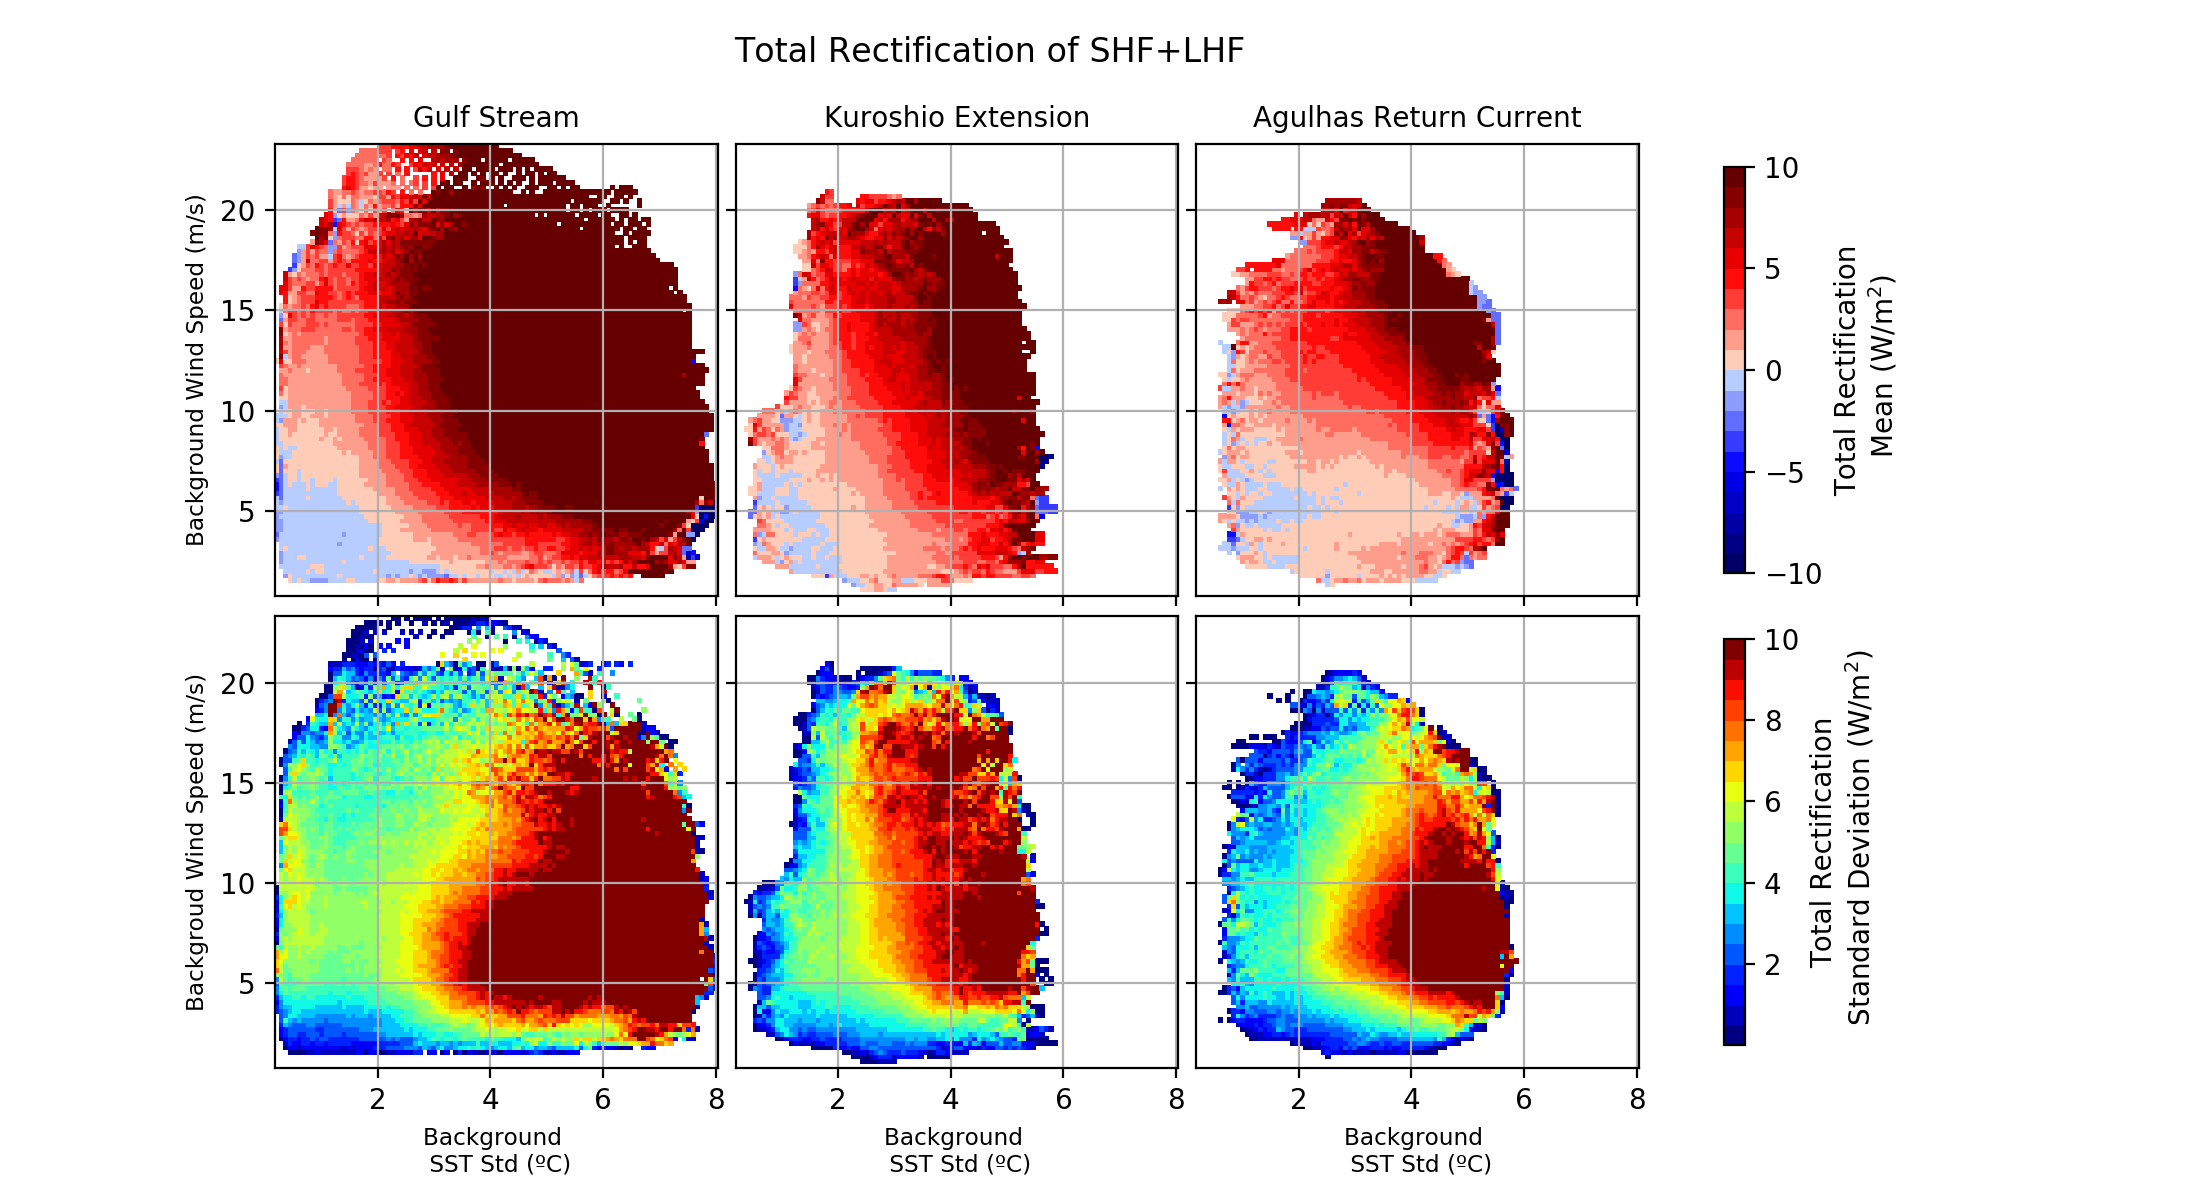

In [31]:
fig, axs = plt.subplots(2,3,figsize=(11,6))
fig.subplots_adjust(wspace=.04,hspace=0.045)
fig.suptitle('Total Rectification of SHF+LHF', fontsize=12,x=0.45, y=.97)

ax = axs[0,0]
pc = ax.pcolormesh(h,r,hist_GS,cmap=cm.get_cmap('BlueRed3', 20),vmin=-10,vmax=10)
ax.set_title("Gulf Stream",fontsize='medium')
ax.set_ylabel("Background Wind Speed (m/s)",fontsize='small')
plt.setp(ax.get_xticklabels(), visible=False)
ax.grid()

ax = axs[0,1]
pc = ax.pcolormesh(h,r,hist_K,cmap=cm.get_cmap('BlueRed3', 20),vmin=-10,vmax=10)
ax.set_title("Kuroshio Extension",fontsize='medium')
plt.setp(ax.get_xticklabels(), visible=False)
plt.setp(ax.get_yticklabels(), visible=False)
ax.grid()

ax = axs[0,2]
pc = ax.pcolormesh(h,r,hist_A,cmap=cm.get_cmap('BlueRed3', 20),vmin=-10,vmax=10)
ax.set_title("Agulhas Return Current",fontsize='medium')
fig.colorbar(pc,ax=axs[0],label="Total Rectification\n Mean (W/m$^2$)",shrink=.9)
plt.setp(ax.get_xticklabels(), visible=False)
plt.setp(ax.get_yticklabels(), visible=False)
ax.grid()

######

ax = axs[1,0]
pc = ax.pcolormesh(h,r,histstd_GS,cmap=cm.get_cmap('jet', 20),vmax=10)
ax.set_ylabel("Backgroud Wind Speed (m/s)",fontsize='small')
ax.set_xlabel("Background \n SST Std (ºC)",fontsize='small')
ax.grid()

ax = axs[1,1]
pc = ax.pcolormesh(h,r,histstd_K,cmap=cm.get_cmap('jet', 20),vmax=10)
plt.setp(ax.get_yticklabels(), visible=False)
ax.set_xlabel("Background \n SST Std (ºC)",fontsize='small')
ax.grid()

ax = axs[1,2]
pc = ax.pcolormesh(h,r,histstd_A,cmap=cm.get_cmap('jet', 20),vmax=10)
fig.colorbar(pc,ax=axs[1],label="Total Rectification\n Standard Deviation (W/m$^2$)",shrink=.9)
ax.set_xlabel("Background \n SST Std (ºC)",fontsize='small')
plt.setp(ax.get_yticklabels(), visible=False)
ax.grid()


In [28]:
r2, h2, hist_GS2, hist_K2, hist_A2 = makehistavg3x(sstsm_GS,sstsm_K,sstsm_A,SSTstd_GS,SSTstd_K,SSTstd_A,LSsum_GS,LSsum_K,LSsum_A,100,100)
r2, h2, histstd_GS2, histstd_K2, histstd_A2 = makehiststd3x(sstsm_GS,sstsm_K,sstsm_A,SSTstd_GS,SSTstd_K,SSTstd_A,LSsum_GS,LSsum_K,LSsum_A,100,100)

hist_GS2[np.where(hist_GS2  == 0.0)] = None
hist_K2[np.where(hist_K2 == 0.0)] = None
hist_A2[np.where(hist_A2 == 0.0)] = None

histstd_GS2[np.where(histstd_GS2  == 0.0)] = None
histstd_K2[np.where(histstd_K2 == 0.0)] = None
histstd_A2[np.where(histstd_A2 == 0.0)] = None


/Users/baileydonaldson/Python/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in greater_equal
/Users/baileydonaldson/Python/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in less
/Users/baileydonaldson/Python/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/Users/baileydonaldson/Python/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/Users/baileydonaldson/Python/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in greater_equal
/Users/baileydonaldson/Python/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in less


<IPython.core.display.Javascript object>


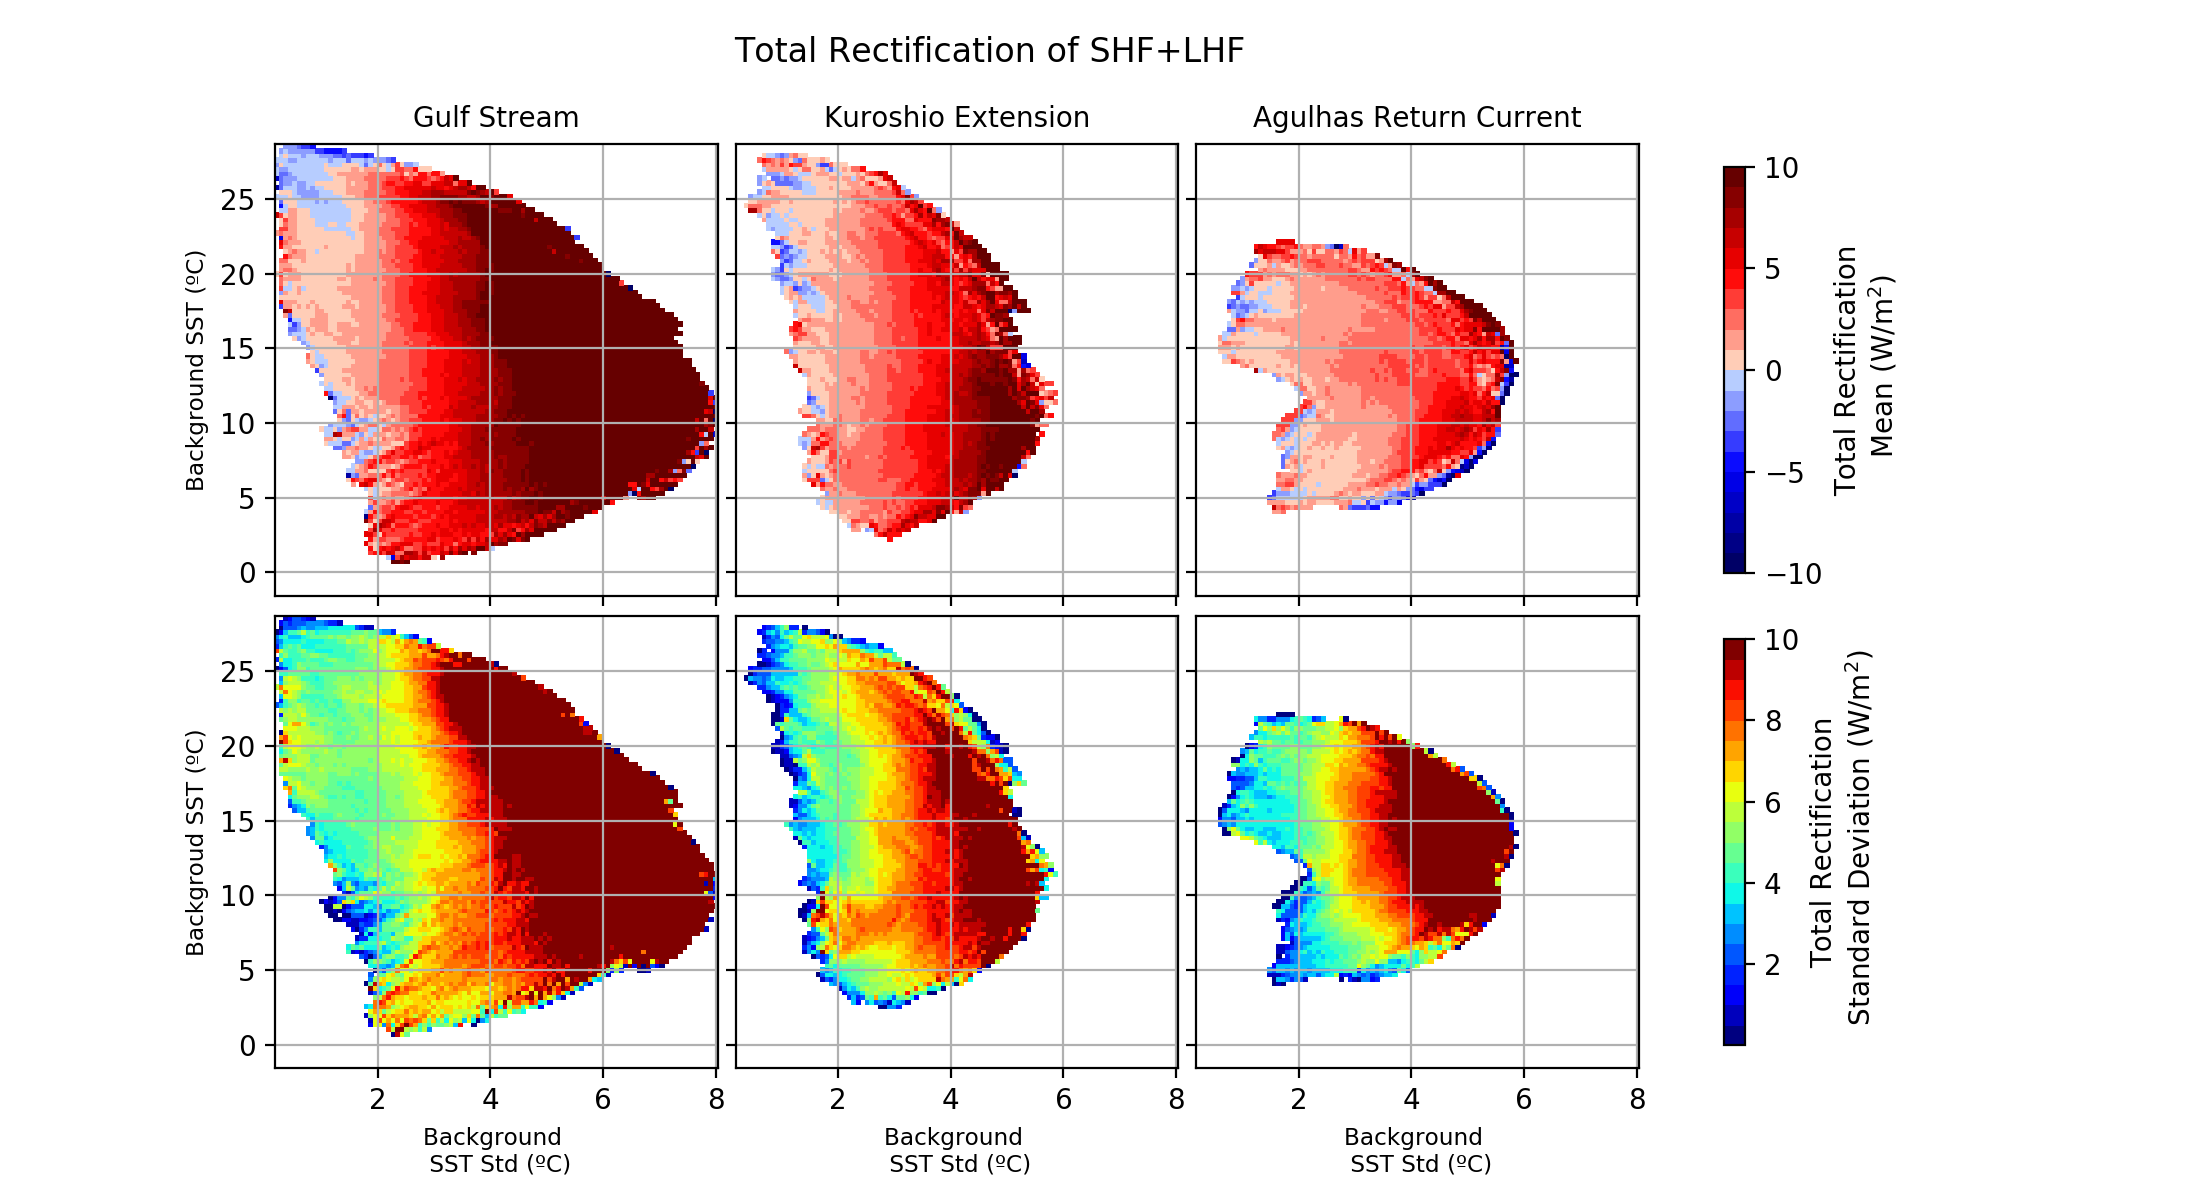

In [30]:
fig, axs = plt.subplots(2,3,figsize=(11,6))
fig.subplots_adjust(wspace=.04,hspace=0.045)
fig.suptitle('Total Rectification of SHF+LHF', fontsize=12,x=0.45, y=.97)

ax = axs[0,0]
pc = ax.pcolormesh(h2,r2,hist_GS2,cmap=cm.get_cmap('BlueRed3', 20),vmin=-10,vmax=10)
ax.set_title("Gulf Stream",fontsize='medium')
ax.set_ylabel("Background SST (ºC)",fontsize='small')
plt.setp(ax.get_xticklabels(), visible=False)
ax.grid()

ax = axs[0,1]
pc = ax.pcolormesh(h2,r2,hist_K2,cmap=cm.get_cmap('BlueRed3', 20),vmin=-10,vmax=10)
ax.set_title("Kuroshio Extension",fontsize='medium')
plt.setp(ax.get_xticklabels(), visible=False)
plt.setp(ax.get_yticklabels(), visible=False)
ax.grid()

ax = axs[0,2]
pc = ax.pcolormesh(h2,r2,hist_A2,cmap=cm.get_cmap('BlueRed3', 20),vmin=-10,vmax=10)
ax.set_title("Agulhas Return Current",fontsize='medium')
fig.colorbar(pc,ax=axs[0],label="Total Rectification\n Mean (W/m$^2$)",shrink=.9)
plt.setp(ax.get_xticklabels(), visible=False)
plt.setp(ax.get_yticklabels(), visible=False)
ax.grid()

######

ax = axs[1,0]
pc = ax.pcolormesh(h2,r2,histstd_GS2,cmap=cm.get_cmap('jet', 20),vmax=10)
ax.set_ylabel("Backgroud SST (ºC)",fontsize='small')
ax.set_xlabel("Background \n SST Std (ºC)",fontsize='small')
ax.grid()

ax = axs[1,1]
pc = ax.pcolormesh(h2,r2,histstd_K2,cmap=cm.get_cmap('jet', 20),vmax=10)
plt.setp(ax.get_yticklabels(), visible=False)
ax.set_xlabel("Background \n SST Std (ºC)",fontsize='small')
ax.grid()

ax = axs[1,2]
pc = ax.pcolormesh(h2,r2,histstd_A2,cmap=cm.get_cmap('jet', 20),vmax=10)
fig.colorbar(pc,ax=axs[1],label="Total Rectification\n Standard Deviation (W/m$^2$)",shrink=.9)
ax.set_xlabel("Background \n SST Std (ºC)",fontsize='small')
plt.setp(ax.get_yticklabels(), visible=False)
ax.grid()

## Historgrams with Temperature

In [ ]:
r_GS, h_GS, hist_GS = makehistavg(sstsm_GS,tasm_GS,Qtsu_GS,100,100)
#r_K, h_K, hist_K = makehistavg(sstsm_K,tasm_K,Qtsu_K,100,100)
#r_A, h_A, hist_A = makehistavg(sstsm_A,tasm_A,Qtsu_A,100,100)


In [ ]:
fig, ax = plt.subplots()

hist_GS[np.where(hist_GS == 0.0)] = None

pc = ax.pcolormesh(h_GS,r_GS,hist_GS,cmap=plt.cm.get_cmap('BlueRed3'),vmin=-8,vmax=8)
fig.colorbar(pc,ax=ax,label="$Q_{TsU}$ (W/m^2)")
ax.set_xlabel("Air Temperature Low Pass (m/s)")
ax.set_ylabel("SST Low Pass (ºC)")
ax.set_title("Gulf Stream $Q_{TsU}$ Mean Reanalysis")
#plt.xticks(rotation = 10)
ax.grid()



In [ ]:
plt.savefig('QS_QTSUmean_temp_GS_era.png', dpi=300, bbox_inches='tight')


In [ ]:
r_GS, h_GS, hist_GS = makehiststd(sstsm_GS,tasm_GS,Qtsu_GS,100,100)
#r_K, h_K, hist_K = makehiststd(sstsm_K,tasm_K,Qtsu_K,100,100)
#r_A, h_A, hist_A = makehiststd(sstsm_A,tasm_A,Qtsu_A,100,100)


In [ ]:
fig, ax = plt.subplots()

hist_GS[np.where(hist_GS == 0.0)] = None

pc = ax.pcolormesh(h_GS,r_GS,hist_GS,cmap='gist_ncar')#vmin=-8,vmax=8)
fig.colorbar(pc,ax=ax,label="$Q_{TaU}$ (W/m^2)")
ax.set_xlabel("Air Temperature Low Pass (m/s)")
ax.set_ylabel("SST Low Pass (ºC)")
ax.set_title("Gulf Stream $Q_{TsU}$ Standard Deviation Reanalysis")
#plt.xticks(rotation = 10)
ax.grid()


In [ ]:
plt.savefig('QS_QTSUstd_temp_GS_era.png', dpi=300, bbox_inches='tight')


In [ ]:
r_GS, h_GS, hist_GS = makehistavg(sstsm_GS,tasm_GS,Qtau_GS,100,100)
#r_K, h_K, hist_K = makehistavg(sstsm_K,tasm_K,Qtau_K,100,100)
#r_A, h_A, hist_A = makehistavg(sstsm_A,tasm_A,Qtau_A,100,100)


In [ ]:
fig, ax = plt.subplots()

hist_GS[np.where(hist_GS == 0.0)] = None

pc = ax.pcolormesh(h_GS,r_GS,hist_GS,cmap=plt.cm.get_cmap('BlueRed3'),vmin=-17,vmax=17)
fig.colorbar(pc,ax=ax,label="$Q_{TaU}$ (W/m^2)")
ax.set_xlabel("Air Temperature Low Pass (m/s)")
ax.set_ylabel("SST Low Pass (ºC)")
ax.set_title("Gulf Stream $Q_{TaU}$ Mean Reanalysis")
#plt.xticks(rotation = 10)
ax.grid()



In [ ]:
plt.savefig('QS_QTAUmean_temp_GS_era.png', dpi=300, bbox_inches='tight')


In [ ]:
r_GS, h_GS, hist_GS = makehiststd(sstsm_GS,tasm_GS,Qtau_GS,100,100)
#r_K, h_K, hist_K = makehiststd(sstsm_K,tasm_K,Qtau_K,100,100)
#r_A, h_A, hist_A = makehiststd(sstsm_A,tasm_A,Qtau_A,100,100)


In [ ]:
fig, ax = plt.subplots()

hist_GS[np.where(hist_GS == 0.0)] = None

pc = ax.pcolormesh(h_GS,r_GS,hist_GS,cmap='gist_ncar')#vmin=-8,vmax=8)
fig.colorbar(pc,ax=ax,label="$Q_{TaU}$ (W/m^2)")
ax.set_xlabel("Air Temperature Low Pass (m/s)")
ax.set_ylabel("SST Low Pass (ºC)")
ax.set_title("Gulf Stream $Q_{TaU}$ Standard Deviation Reanalysis")
ax.grid()


In [ ]:
plt.savefig('QS_QTAUstd_temp_GS_era.png', dpi=300, bbox_inches='tight')


## Histograms with Wind

In [75]:
r_GS, h_GS, hist_GS = makehistavg(wspdsm_GS,wdirsm_GS,Qtsu_GS,100,100)
#r_K, h_K, hist_K = makehistavg(wspdsm_K,wdirsm_K,Qtsu_K,100,100)
#r_A, h_A, hist_A = makehistavg(wspdsm_A,wdirsm_A,Qtsu_A,100,100)


/Users/baileydonaldson/Python/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: Mean of empty slice


<IPython.core.display.Javascript object>


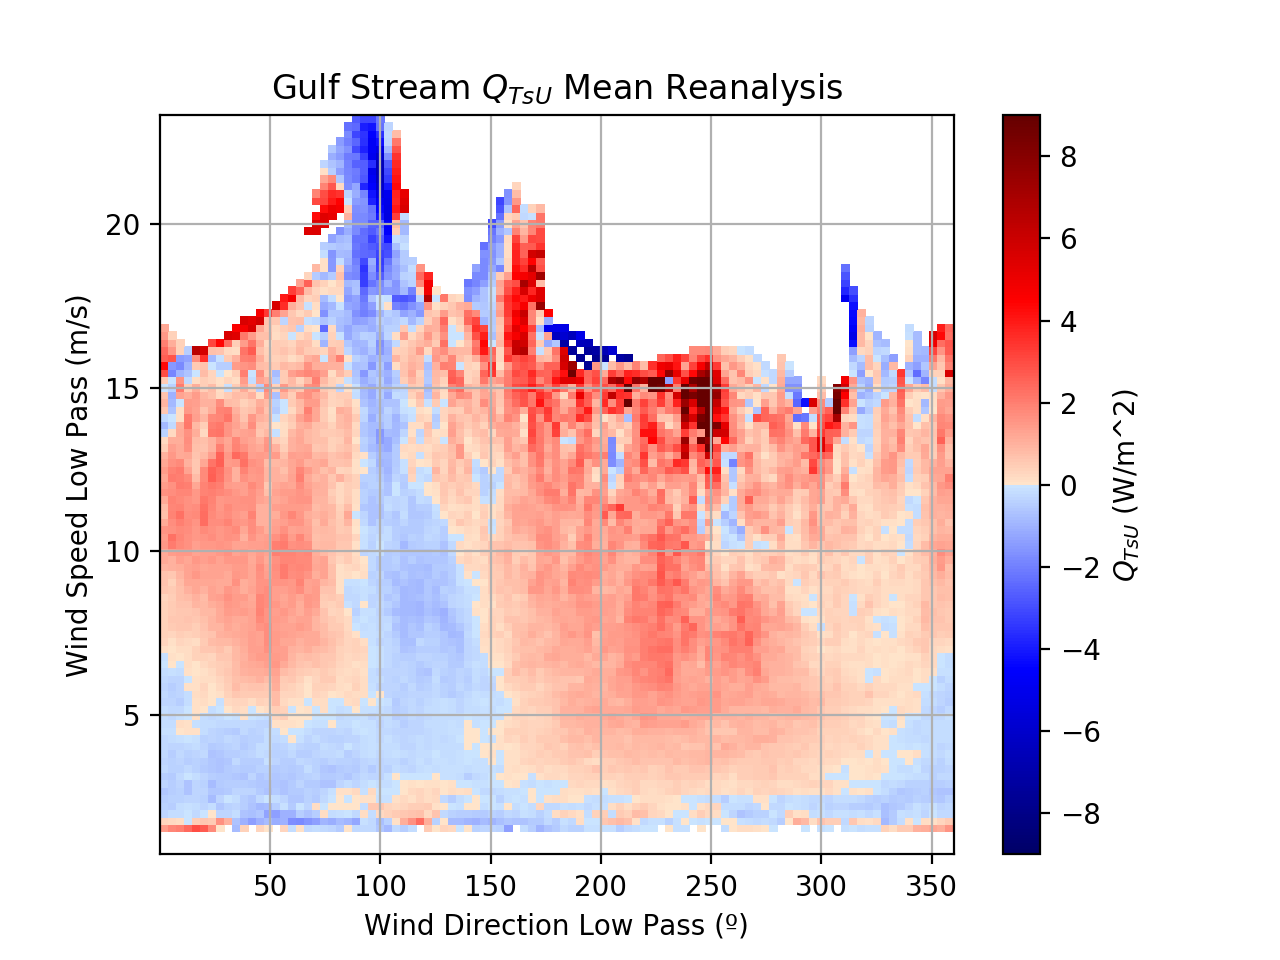

In [76]:
fig, ax = plt.subplots()

hist_GS[np.where(hist_GS == 0.0)] = None

pc = ax.pcolormesh(h_GS,r_GS,hist_GS,cmap=plt.cm.get_cmap('BlueRed3'),vmin=-9,vmax=9)
fig.colorbar(pc,ax=ax,label="$Q_{TsU}$ (W/m^2)")
ax.set_xlabel("Wind Direction Low Pass (º)")
ax.set_ylabel("Wind Speed Low Pass (m/s)")
ax.set_title("Gulf Stream $Q_{TsU}$ Mean Reanalysis")
#plt.xticks(rotation = 10)
ax.grid()


In [ ]:
plt.savefig('QS_QTSUmean_wind_GS_era.png', dpi=300, bbox_inches='tight')


In [ ]:
r_GS, h_GS, hist_GS = makehiststd(wspdsm_GS,wdirsm_GS,Qtsu_GS,100,100)
#r_K, h_K, hist_K = makehiststd(wspdsm_K,wdirsm_K,Qtsu_K,100,100)
#r_A, h_A, hist_A = makehiststd(wspdsm_A,wdirsm_A,Qtsu_A,100,100)


In [ ]:
fig, ax = plt.subplots()

hist_GS[np.where(hist_GS == 0.0)] = None

pc = ax.pcolormesh(h_GS,r_GS,hist_GS,cmap='gist_ncar')#,vmin=-9,vmax=9)
fig.colorbar(pc,ax=ax,label="$Q_{TsU}$ (W/m^2)")
ax.set_xlabel("Wind Direction Low Pass (º)")
ax.set_ylabel("Wind Speed Low Pass (m/s)")
ax.set_title("Gulf Stream $Q_{TsU}$ Standard Deviation Reanalysis")
#plt.xticks(rotation = 10)
ax.grid()


In [ ]:
plt.savefig('QS_QTSUstd_wind_GS_era.png', dpi=300, bbox_inches='tight')


In [ ]:
r_GS, h_GS, hist_GS = makehistavg(wspdsm_GS,wdirsm_GS,Qtau_GS,100,100)
#r_K, h_K, hist_K = makehistavg(wspdsm_K,wdirsm_K,Qtau_K,100,100)
#r_A, h_A, hist_A = makehistavg(wspdsm_A,wdirsm_A,Qtau_A,100,100)


In [ ]:
fig, ax = plt.subplots()

hist_GS[np.where(hist_GS == 0.0)] = None

pc = ax.pcolormesh(h_GS,r_GS,hist_GS,cmap='BlueRed3',vmin=-20,vmax=20)
fig.colorbar(pc,ax=ax,label="$Q_{TaU}$ (W/m^2)")
ax.set_xlabel("Wind Direction Low Pass (º)")
ax.set_ylabel("Wind Speed Low Pass (m/s)")
ax.set_title("Gulf Stream $Q_{TaU}$ Mean Reanalysis")
#plt.xticks(rotation = 10)
ax.grid()


In [ ]:
plt.savefig('QS_QTAUmean_wind_GS_era.png', dpi=300, bbox_inches='tight')


In [ ]:
r_GS, h_GS, hist_GS = makehiststd(wspdsm_GS,wdirsm_GS,Qtau_GS,100,100)
#r_K, h_K, hist_K = makehiststd(wspdsm_K,wdirsm_K,Qtau_K,100,100)
#r_A, h_A, hist_A = makehiststd(wspdsm_A,wdirsm_A,Qtau_A,100,100)


In [ ]:
fig, ax = plt.subplots()

hist_GS[np.where(hist_GS == 0.0)] = None

pc = ax.pcolormesh(h_GS,r_GS,hist_GS,cmap='gist_ncar')#,vmin=-9,vmax=9)
fig.colorbar(pc,ax=ax,label="$Q_{TaU}$ (W/m^2)")
ax.set_xlabel("Wind Direction Low Pass (º)")
ax.set_ylabel("Wind Speed Low Pass (m/s)")
ax.set_title("Gulf Stream $Q_{TaU}$ Standard Deviation Reanalysis")
#plt.xticks(rotation = 10)
ax.grid()


In [ ]:
plt.savefig('QS_QTAUstd_wind_GS_era.png', dpi=300, bbox_inches='tight')


## Plots for Paper

In [131]:
wGS=np.empty(wdirsm_GS.shape)
wGS[np.where(wdirsm_GS <= 180)]=wdirsm_GS[np.where(wdirsm_GS <= 180)]+180
wGS[np.where(wdirsm_GS > 180)]=wdirsm_GS[np.where(wdirsm_GS > 180)]-180

wK=np.empty(wdirsm_K.shape)
wK[np.where(wdirsm_K <= 180)]=wdirsm_K[np.where(wdirsm_K <= 180)]+180
wK[np.where(wdirsm_K > 180)]=wdirsm_K[np.where(wdirsm_K > 180)]-180

wA=np.empty(wdirsm_A.shape)
wA[np.where(wdirsm_A <= 180)]=wdirsm_A[np.where(wdirsm_A <= 180)]+180
wA[np.where(wdirsm_A > 180)]=wdirsm_A[np.where(wdirsm_A > 180)]-180


In [132]:
r, h, hist_GStsu, hist_Ktsu, hist_Atsu = makehistavg3x(wspdsm_GS,wspdsm_K,wspdsm_A,wGS,wK,wA,Qtsu_GS,Qtsu_K,Qtsu_A,100,100)
r, h, hist_GStau, hist_Ktau, hist_Atau = makehistavg3x(wspdsm_GS,wspdsm_K,wspdsm_A,wGS,wK,wA,Qtau_GS,Qtau_K,Qtau_A,100,100)

hist_GStsu[np.where(hist_GStsu == 0.0)] = None
hist_Ktsu[np.where(hist_Ktsu == 0.0)] = None
hist_Atsu[np.where(hist_Atsu == 0.0)] = None

hist_GStau[np.where(hist_GStau == 0.0)] = None
hist_Ktau[np.where(hist_Ktau == 0.0)] = None
hist_Atau[np.where(hist_Atau == 0.0)] = None


r, h, hist_GStsu_std, hist_Ktsu_std, hist_Atsu_std = makehiststd3x(wspdsm_GS,wspdsm_K,wspdsm_A,wGS,wK,wA,Qtsu_GS,Qtsu_K,Qtsu_A,100,100)
r, h, hist_GStau_std, hist_Ktau_std, hist_Atau_std = makehiststd3x(wspdsm_GS,wspdsm_K,wspdsm_A,wGS,wK,wA,Qtau_GS,Qtau_K,Qtau_A,100,100)

hist_GStsu_std[np.where(hist_GStsu_std == 0.0)] = None
hist_Ktsu_std[np.where(hist_Ktsu_std == 0.0)] = None
hist_Atsu_std[np.where(hist_Atsu_std == 0.0)] = None

hist_GStau_std[np.where(hist_GStau_std == 0.0)] = None
hist_Ktau_std[np.where(hist_Ktau_std == 0.0)] = None
hist_Atau_std[np.where(hist_Atau_std == 0.0)] = None


/Users/baileydonaldson/Python/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:96: RuntimeWarning: Mean of empty slice
/Users/baileydonaldson/Python/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:99: RuntimeWarning: Mean of empty slice


<IPython.core.display.Javascript object>


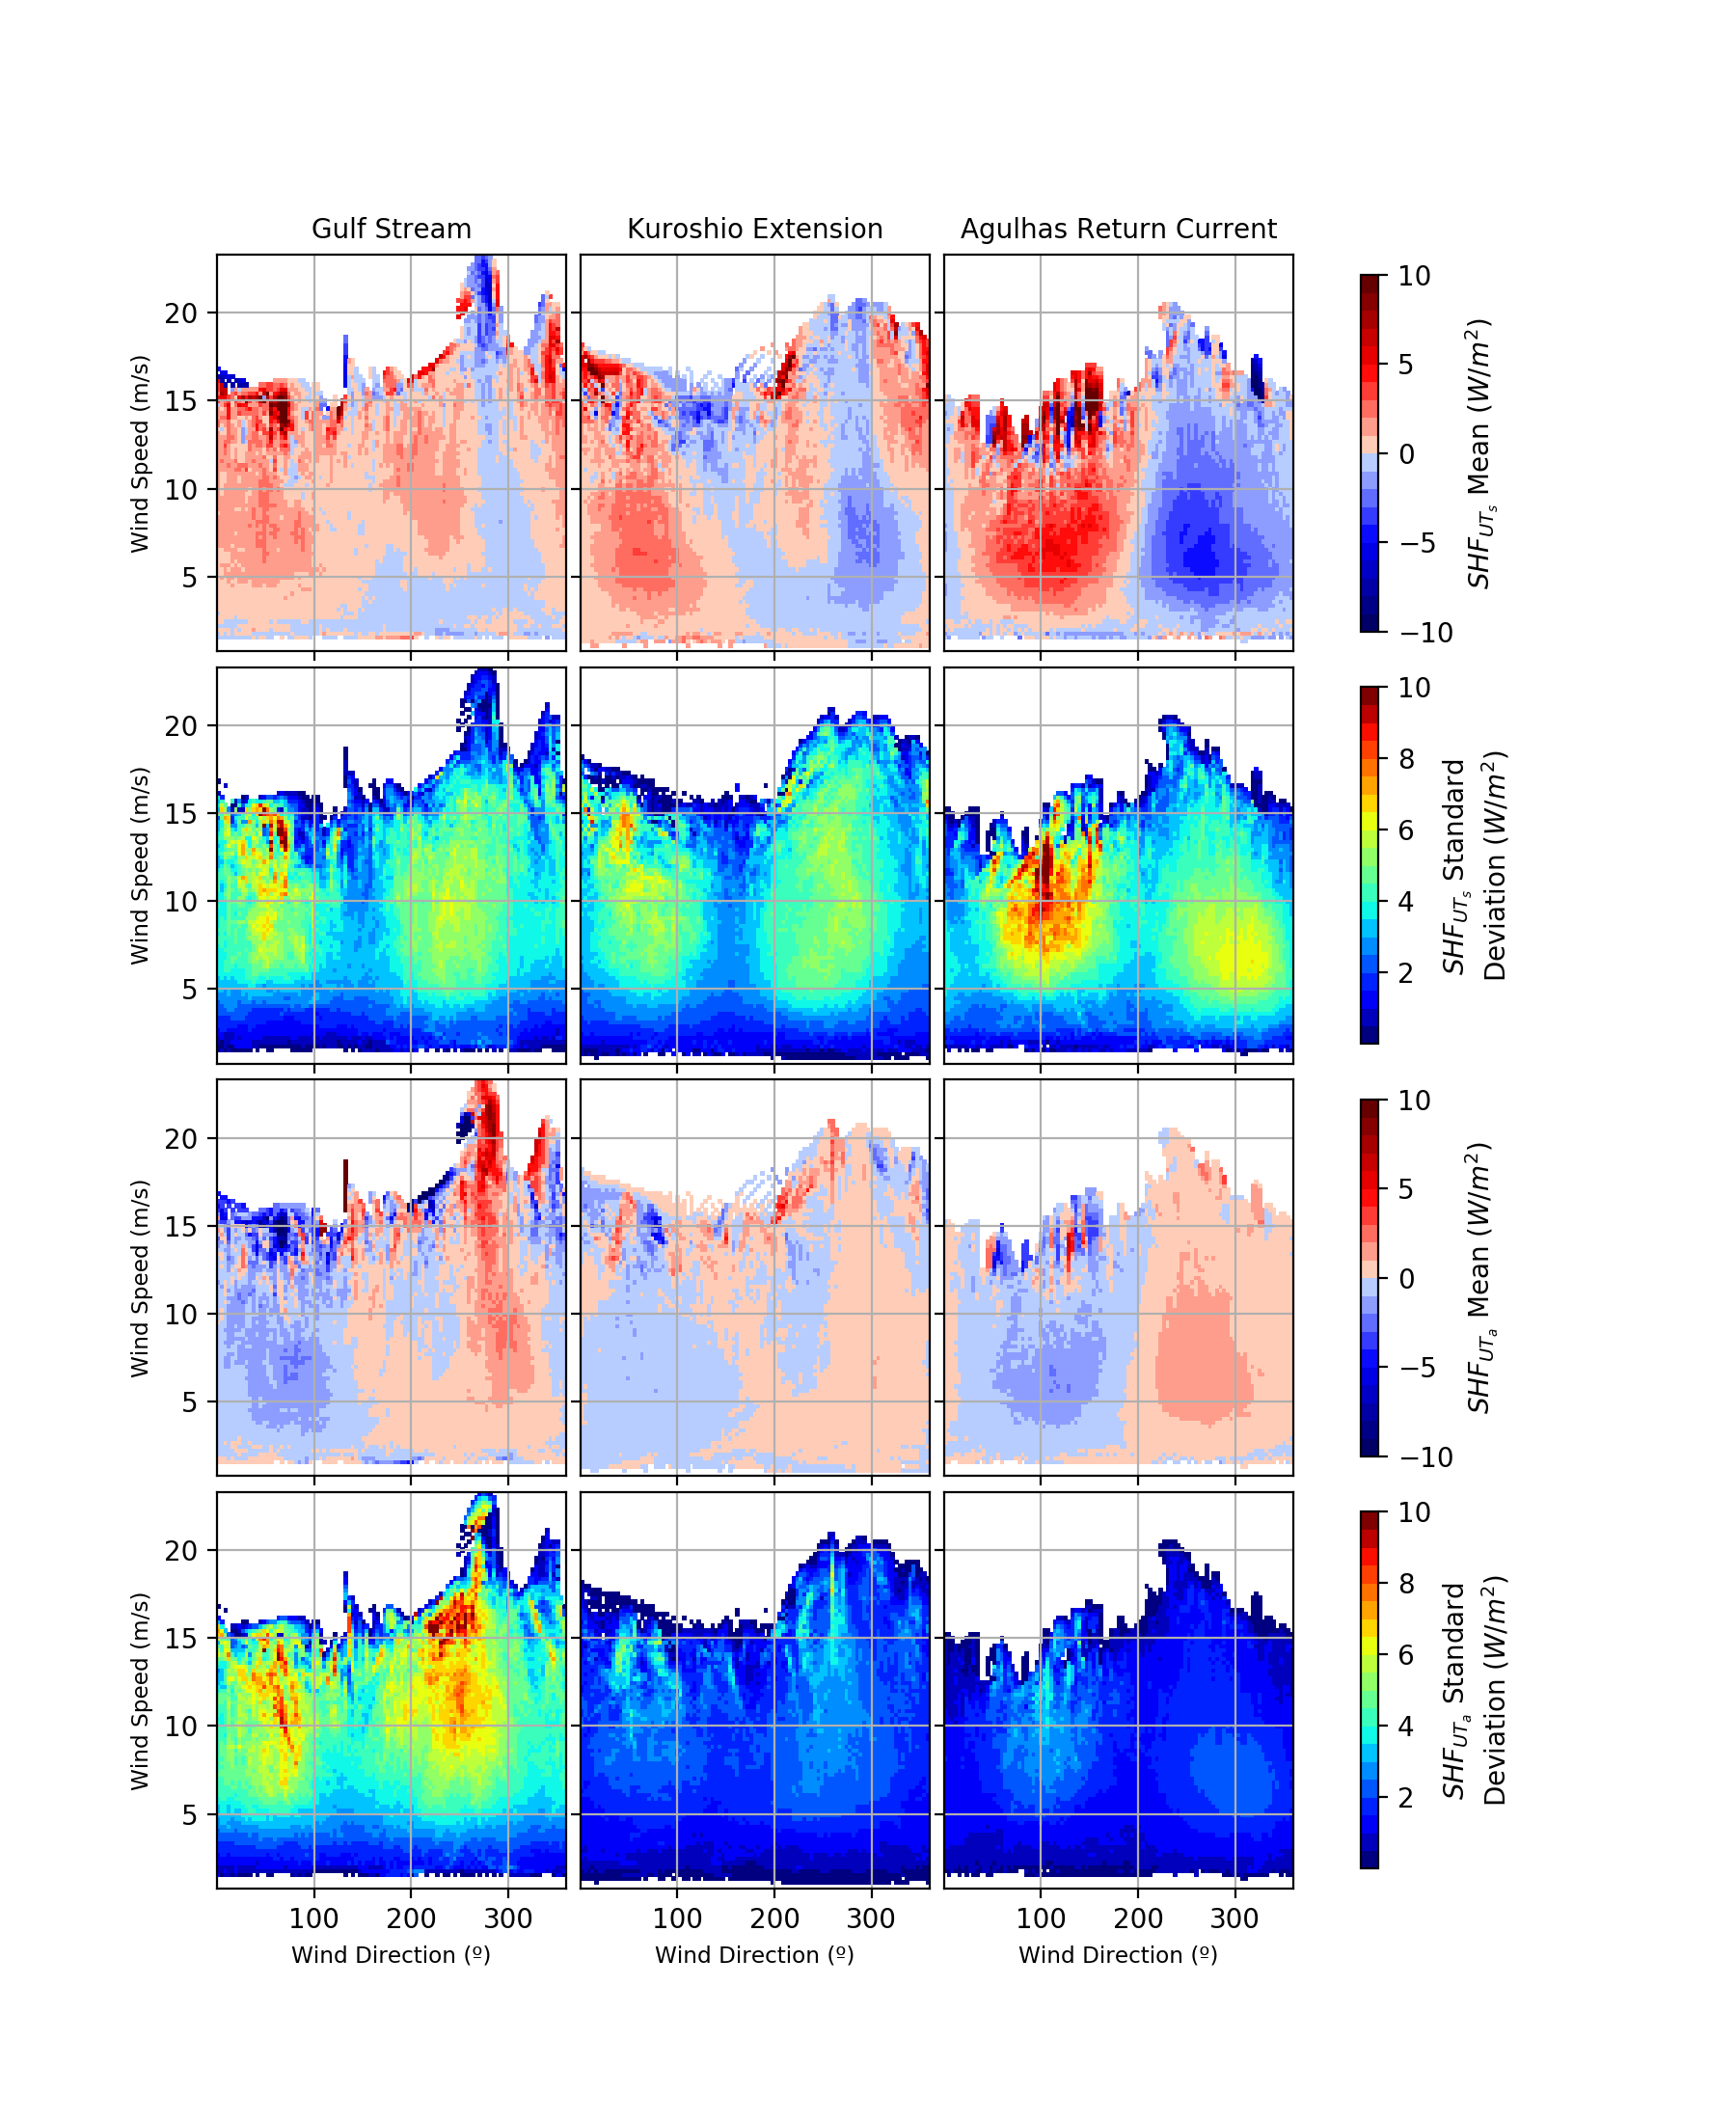

In [133]:
fig, axs = plt.subplots(4,3,figsize=(9,11))
fig.subplots_adjust(wspace=.04,hspace=0.04)

ax = axs[0,0]
pc = ax.pcolormesh(h,r,hist_GStsu,cmap=cm.get_cmap('BlueRed3', 20),vmin=-10,vmax=10)
ax.set_title("Gulf Stream",fontsize='medium')
ax.set_ylabel("Wind Speed (m/s)",fontsize='small')
plt.setp(ax.get_xticklabels(), visible=False)
ax.grid()

ax = axs[0,1]
pc = ax.pcolormesh(h,r,hist_Ktsu,cmap=cm.get_cmap('BlueRed3', 20),vmin=-10,vmax=10)
ax.set_title("Kuroshio Extension",fontsize='medium')
plt.setp(ax.get_xticklabels(), visible=False)
plt.setp(ax.get_yticklabels(), visible=False)
ax.grid()

ax = axs[0,2]
pc = ax.pcolormesh(h,r,hist_Atsu,cmap=cm.get_cmap('BlueRed3', 20),vmin=-10,vmax=10)
ax.set_title("Agulhas Return Current",fontsize='medium')
fig.colorbar(pc,ax=axs[0],label="$SHF_{UT_s}$ Mean ($W/m^2$)",shrink=.9)
plt.setp(ax.get_xticklabels(), visible=False)
plt.setp(ax.get_yticklabels(), visible=False)
ax.grid()

######

ax = axs[1,0]
pc = ax.pcolormesh(h,r,hist_GStsu_std,cmap=cm.get_cmap('jet', 20),vmax=10)
ax.set_ylabel("Wind Speed (m/s)",fontsize='small')
plt.setp(ax.get_xticklabels(), visible=False)
ax.grid()

ax = axs[1,1]
pc = ax.pcolormesh(h,r,hist_Ktsu_std,cmap=cm.get_cmap('jet', 20),vmax=10)
plt.setp(ax.get_xticklabels(), visible=False)
plt.setp(ax.get_yticklabels(), visible=False)
ax.grid()

ax = axs[1,2]
pc = ax.pcolormesh(h,r,hist_Atsu_std,cmap=cm.get_cmap('jet', 20),vmax=10)
fig.colorbar(pc,ax=axs[1],label="$SHF_{UT_s}$ Standard \nDeviation ($W/m^2$)",shrink=.9)
plt.setp(ax.get_xticklabels(), visible=False)
plt.setp(ax.get_yticklabels(), visible=False)
ax.grid()

#####

ax = axs[2,0]
pc = ax.pcolormesh(h,r,hist_GStau,cmap=cm.get_cmap('BlueRed3', 20),vmin=-10,vmax=10)
ax.set_ylabel("Wind Speed (m/s)",fontsize='small')
plt.setp(ax.get_xticklabels(), visible=False)
ax.grid()

ax = axs[2,1]
pc = ax.pcolormesh(h,r,hist_Ktau,cmap=cm.get_cmap('BlueRed3', 20),vmin=-10,vmax=10)
plt.setp(ax.get_xticklabels(), visible=False)
plt.setp(ax.get_yticklabels(), visible=False)
ax.grid()

ax = axs[2,2]
pc = ax.pcolormesh(h,r,hist_Atau,cmap=cm.get_cmap('BlueRed3', 20),vmin=-10,vmax=10)
fig.colorbar(pc,ax=axs[2],label="$SHF_{UT_a}$ Mean ($W/m^2$)",shrink=.9)
plt.setp(ax.get_xticklabels(), visible=False)
plt.setp(ax.get_yticklabels(), visible=False)
ax.grid()

######

ax = axs[3,0]
pc = ax.pcolormesh(h,r,hist_GStau_std,cmap=cm.get_cmap('jet',20),vmax=10)
ax.set_xlabel("Wind Direction (º)",fontsize='small')
ax.set_ylabel("Wind Speed (m/s)",fontsize='small')
ax.grid()

ax = axs[3,1]
pc = ax.pcolormesh(h,r,hist_Ktau_std,cmap=cm.get_cmap('jet', 20),vmax=10)
ax.set_xlabel("Wind Direction (º)",fontsize='small')
plt.setp(ax.get_yticklabels(), visible=False)
ax.grid()

ax = axs[3,2]
pc = ax.pcolormesh(h,r,hist_Atau_std,cmap=cm.get_cmap('jet',20),vmax=10)
fig.colorbar(pc,ax=axs[3],label="$SHF_{UT_a}$ Standard \nDeviation ($W/m^2$)",shrink=.9)
ax.set_xlabel("Wind Direction (º)",fontsize='small')
plt.setp(ax.get_yticklabels(), visible=False)
ax.grid()



In [134]:
plt.savefig('PAPER_windpdf_dirfrom_SHF.png', dpi=300, bbox_inches='tight')


In [96]:
r, h, hist_GStsu, hist_Ktsu, hist_Atsu = makehistavg3x(tasm_GS,tasm_K,tasm_A,sstsm_GS,sstsm_K,sstsm_A,Qtsu_GS,Qtsu_K,Qtsu_A,100,100)
r, h, hist_GStau, hist_Ktau, hist_Atau = makehistavg3x(tasm_GS,tasm_K,tasm_A,sstsm_GS,sstsm_K,sstsm_A,Qtau_GS,Qtau_K,Qtau_A,100,100)

hist_GStsu[np.where(hist_GStsu == 0.0)] = None
hist_Ktsu[np.where(hist_Ktsu == 0.0)] = None
hist_Atsu[np.where(hist_Atsu == 0.0)] = None

hist_GStau[np.where(hist_GStau == 0.0)] = None
hist_Ktau[np.where(hist_Ktau == 0.0)] = None
hist_Atau[np.where(hist_Atau == 0.0)] = None


r, h, hist_GStsu_std, hist_Ktsu_std, hist_Atsu_std = makehiststd3x(tasm_GS,tasm_K,tasm_A,sstsm_GS,sstsm_K,sstsm_A,Qtsu_GS,Qtsu_K,Qtsu_A,100,100)
r, h, hist_GStau_std, hist_Ktau_std, hist_Atau_std = makehiststd3x(tasm_GS,tasm_K,tasm_A,sstsm_GS,sstsm_K,sstsm_A,Qtau_GS,Qtau_K,Qtau_A,100,100)

hist_GStsu_std[np.where(hist_GStsu_std == 0.0)] = None
hist_Ktsu_std[np.where(hist_Ktsu_std == 0.0)] = None
hist_Atsu_std[np.where(hist_Atsu_std == 0.0)] = None

hist_GStau_std[np.where(hist_GStau_std == 0.0)] = None
hist_Ktau_std[np.where(hist_Ktau_std == 0.0)] = None
hist_Atau_std[np.where(hist_Atau_std == 0.0)] = None


/Users/baileydonaldson/Python/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:95: RuntimeWarning: invalid value encountered in greater_equal
/Users/baileydonaldson/Python/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:95: RuntimeWarning: invalid value encountered in less
/Users/baileydonaldson/Python/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:96: RuntimeWarning: Mean of empty slice
/Users/baileydonaldson/Python/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:99: RuntimeWarning: Mean of empty slice


<IPython.core.display.Javascript object>


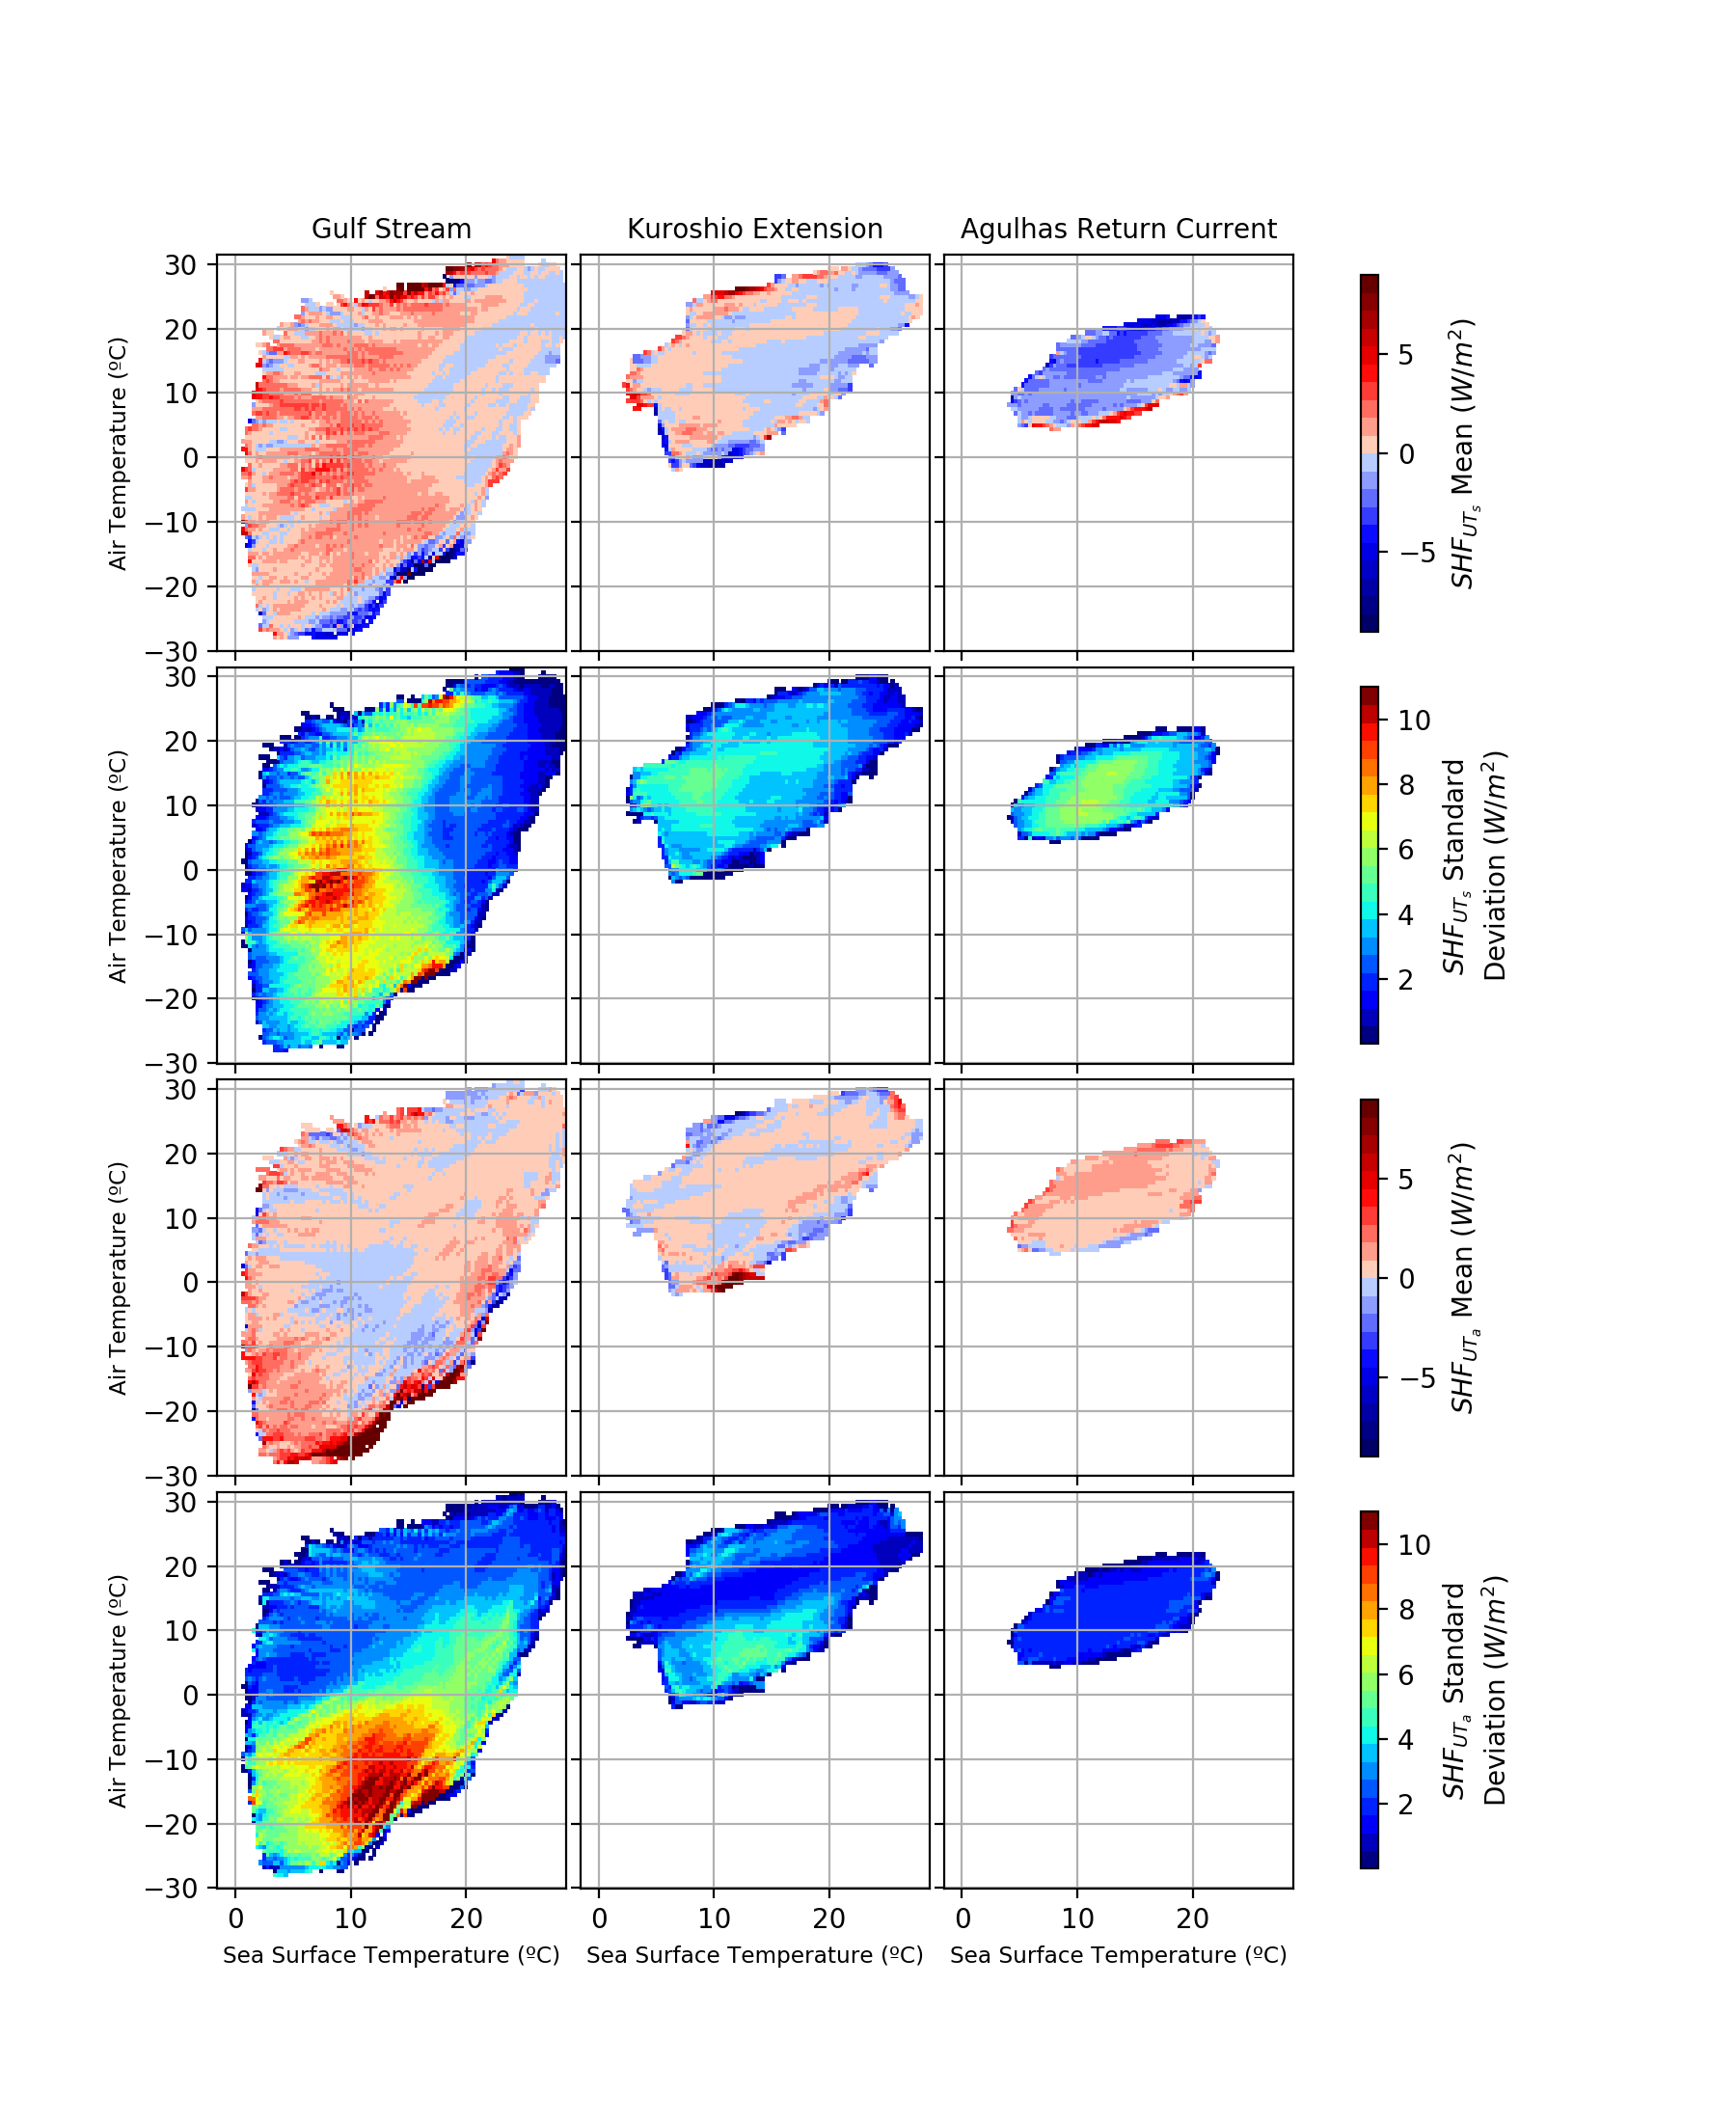

In [110]:
fig, axs = plt.subplots(4,3,figsize=(9,11))
fig.subplots_adjust(wspace=.04,hspace=0.04)

ax = axs[0,0]
pc = ax.pcolormesh(h,r,hist_GStsu,cmap=cm.get_cmap('BlueRed3', 20),vmin=-9,vmax=9)
ax.set_title("Gulf Stream",fontsize='medium')
ax.set_ylabel("Air Temperature (ºC)",fontsize='small')
plt.setp(ax.get_xticklabels(), visible=False)
ax.grid()

ax = axs[0,1]
pc = ax.pcolormesh(h,r,hist_Ktsu,cmap=cm.get_cmap('BlueRed3', 20),vmin=-9,vmax=9)
ax.set_title("Kuroshio Extension",fontsize='medium')
plt.setp(ax.get_xticklabels(), visible=False)
plt.setp(ax.get_yticklabels(), visible=False)
ax.grid()

ax = axs[0,2]
pc = ax.pcolormesh(h,r,hist_Atsu,cmap=cm.get_cmap('BlueRed3', 20),vmin=-9,vmax=9)
ax.set_title("Agulhas Return Current",fontsize='medium')
fig.colorbar(pc,ax=axs[0],label="$SHF_{UT_s}$ Mean ($W/m^2$)",shrink=.9)
plt.setp(ax.get_xticklabels(), visible=False)
plt.setp(ax.get_yticklabels(), visible=False)
ax.grid()

######

ax = axs[1,0]
pc = ax.pcolormesh(h,r,hist_GStsu_std,cmap=cm.get_cmap('jet', 20),vmax=11)
ax.set_ylabel("Air Temperature (ºC)",fontsize='small')
plt.setp(ax.get_xticklabels(), visible=False)
ax.grid()

ax = axs[1,1]
pc = ax.pcolormesh(h,r,hist_Ktsu_std,cmap=cm.get_cmap('jet', 20),vmax=11)
plt.setp(ax.get_xticklabels(), visible=False)
plt.setp(ax.get_yticklabels(), visible=False)
ax.grid()

ax = axs[1,2]
pc = ax.pcolormesh(h,r,hist_Atsu_std,cmap=cm.get_cmap('jet', 20),vmax=11)
fig.colorbar(pc,ax=axs[1],label="$SHF_{UT_s}$ Standard \nDeviation ($W/m^2$)",shrink=.9)
plt.setp(ax.get_xticklabels(), visible=False)
plt.setp(ax.get_yticklabels(), visible=False)
ax.grid()

#####

ax = axs[2,0]
pc = ax.pcolormesh(h,r,hist_GStau,cmap=cm.get_cmap('BlueRed3', 20),vmin=-9,vmax=9)
ax.set_ylabel("Air Temperature (ºC)",fontsize='small')
plt.setp(ax.get_xticklabels(), visible=False)
ax.grid()

ax = axs[2,1]
pc = ax.pcolormesh(h,r,hist_Ktau,cmap=cm.get_cmap('BlueRed3', 20),vmin=-9,vmax=9)
plt.setp(ax.get_xticklabels(), visible=False)
plt.setp(ax.get_yticklabels(), visible=False)
ax.grid()

ax = axs[2,2]
pc = ax.pcolormesh(h,r,hist_Atau,cmap=cm.get_cmap('BlueRed3', 20),vmin=-9,vmax=9)
fig.colorbar(pc,ax=axs[2],label="$SHF_{UT_a}$ Mean ($W/m^2$)",shrink=.9)
plt.setp(ax.get_xticklabels(), visible=False)
plt.setp(ax.get_yticklabels(), visible=False)
ax.grid()

######

ax = axs[3,0]
pc = ax.pcolormesh(h,r,hist_GStau_std,cmap=cm.get_cmap('jet',20),vmax=11)
ax.set_xlabel("Sea Surface Temperature (ºC)",fontsize='small')
ax.set_ylabel("Air Temperature (ºC)",fontsize='small')
ax.grid()

ax = axs[3,1]
pc = ax.pcolormesh(h,r,hist_Ktau_std,cmap=cm.get_cmap('jet', 20),vmax=11)
ax.set_xlabel("Sea Surface Temperature (ºC)",fontsize='small')
plt.setp(ax.get_yticklabels(), visible=False)
ax.grid()

ax = axs[3,2]
pc = ax.pcolormesh(h,r,hist_Atau_std,cmap=cm.get_cmap('jet',20),vmax=11)
fig.colorbar(pc,ax=axs[3],label="$SHF_{UT_a}$ Standard \nDeviation ($W/m^2$)",shrink=.9)
ax.set_xlabel("Sea Surface Temperature (ºC)",fontsize='small')
plt.setp(ax.get_yticklabels(), visible=False)
ax.grid()



In [111]:
plt.savefig('PAPER_temppdf_SHF.png', dpi=300, bbox_inches='tight')


In [97]:
r, h, hist_GStsu, hist_Ktsu, hist_Atsu = makehistavg3x(SSTstd_GS,SSTstd_K,SSTstd_A,sstsm_GS,sstsm_K,sstsm_A,Qtsu_GS,Qtsu_K,Qtsu_A,100,100)
r, h, hist_GStau, hist_Ktau, hist_Atau = makehistavg3x(SSTstd_GS,SSTstd_K,SSTstd_A,sstsm_GS,sstsm_K,sstsm_A,Qtau_GS,Qtau_K,Qtau_A,100,100)

hist_GStsu[np.where(hist_GStsu == 0.0)] = None
hist_Ktsu[np.where(hist_Ktsu == 0.0)] = None
hist_Atsu[np.where(hist_Atsu == 0.0)] = None

hist_GStau[np.where(hist_GStau == 0.0)] = None
hist_Ktau[np.where(hist_Ktau == 0.0)] = None
hist_Atau[np.where(hist_Atau == 0.0)] = None


r, h, hist_GStsu_std, hist_Ktsu_std, hist_Atsu_std = makehiststd3x(SSTstd_GS,SSTstd_K,SSTstd_A,sstsm_GS,sstsm_K,sstsm_A,Qtsu_GS,Qtsu_K,Qtsu_A,100,100)
r, h, hist_GStau_std, hist_Ktau_std, hist_Atau_std = makehiststd3x(SSTstd_GS,SSTstd_K,SSTstd_A,sstsm_GS,sstsm_K,sstsm_A,Qtau_GS,Qtau_K,Qtau_A,100,100)

hist_GStsu_std[np.where(hist_GStsu_std == 0.0)] = None
hist_Ktsu_std[np.where(hist_Ktsu_std == 0.0)] = None
hist_Atsu_std[np.where(hist_Atsu_std == 0.0)] = None

hist_GStau_std[np.where(hist_GStau_std == 0.0)] = None
hist_Ktau_std[np.where(hist_Ktau_std == 0.0)] = None
hist_Atau_std[np.where(hist_Atau_std == 0.0)] = None


/Users/baileydonaldson/Python/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in greater_equal
/Users/baileydonaldson/Python/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in less
/Users/baileydonaldson/Python/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in greater_equal
/Users/baileydonaldson/Python/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in less


<IPython.core.display.Javascript object>


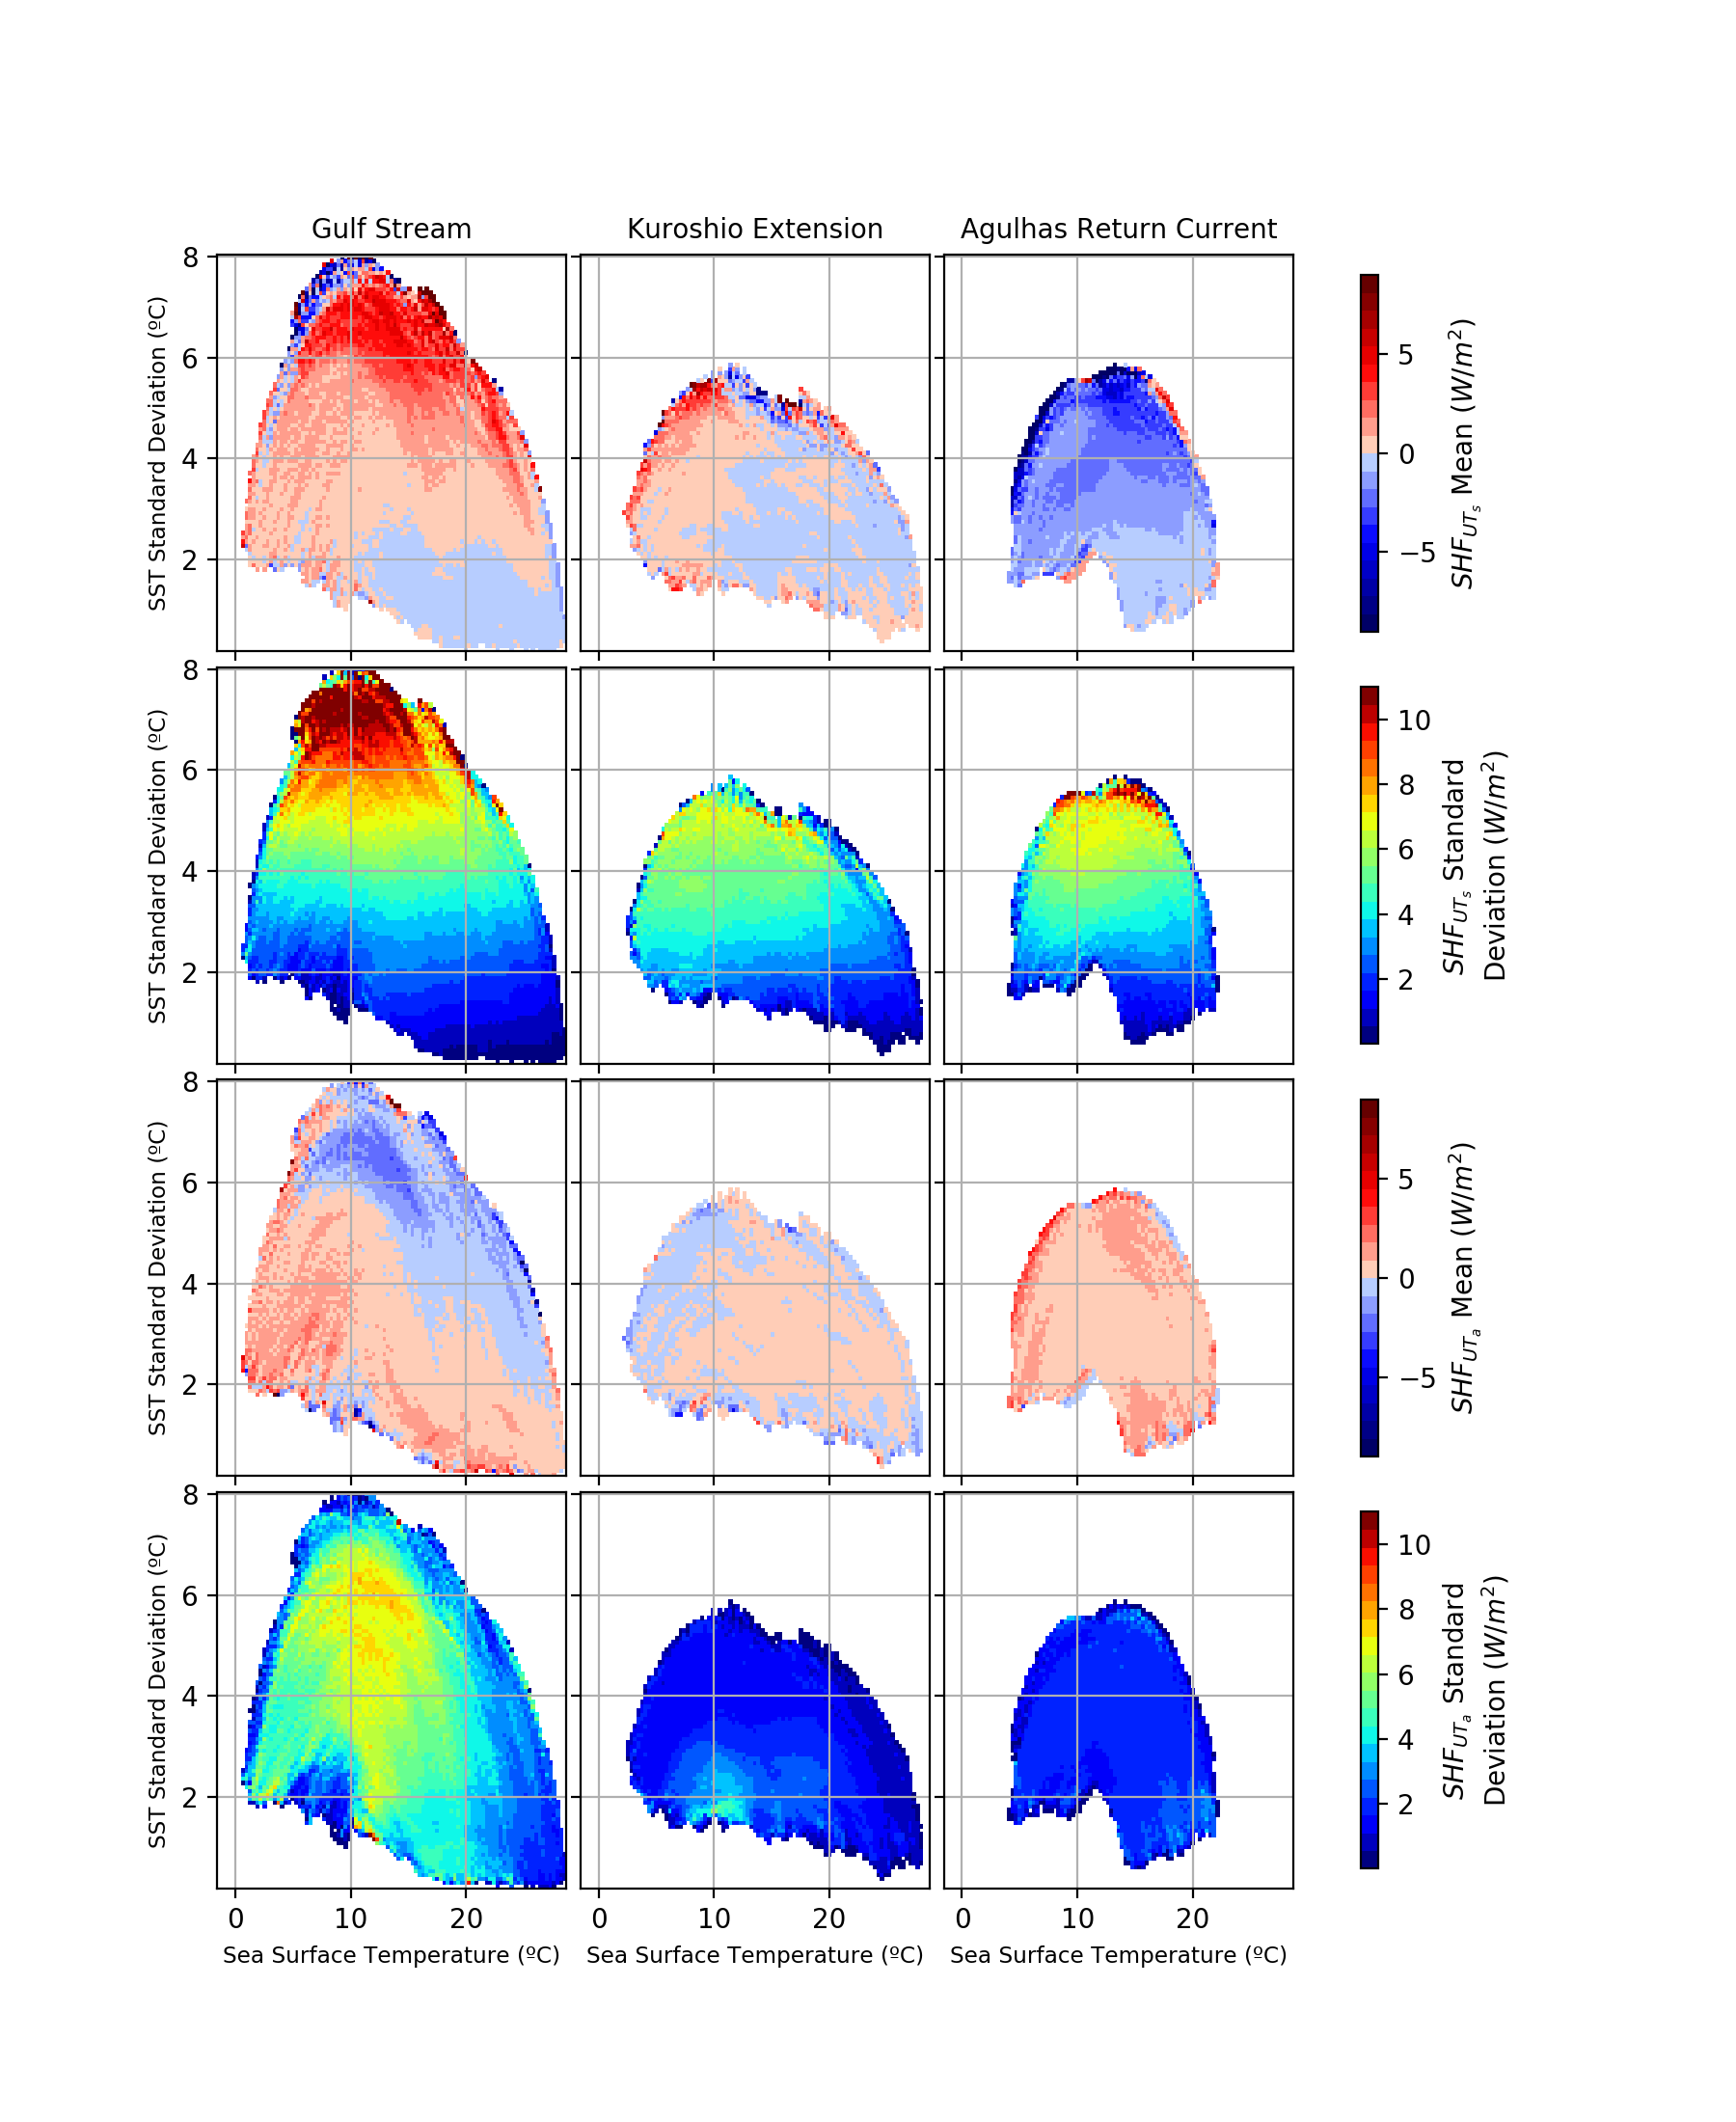

In [98]:
fig, axs = plt.subplots(4,3,figsize=(9,11))
fig.subplots_adjust(wspace=.04,hspace=0.04)

ax = axs[0,0]
pc = ax.pcolormesh(h,r,hist_GStsu,cmap=cm.get_cmap('BlueRed3', 20),vmin=-9,vmax=9)
ax.set_title("Gulf Stream",fontsize='medium')
ax.set_ylabel("SST Standard Deviation (ºC)",fontsize='small')
plt.setp(ax.get_xticklabels(), visible=False)
ax.grid()

ax = axs[0,1]
pc = ax.pcolormesh(h,r,hist_Ktsu,cmap=cm.get_cmap('BlueRed3', 20),vmin=-9,vmax=9)
ax.set_title("Kuroshio Extension",fontsize='medium')
plt.setp(ax.get_xticklabels(), visible=False)
plt.setp(ax.get_yticklabels(), visible=False)
ax.grid()

ax = axs[0,2]
pc = ax.pcolormesh(h,r,hist_Atsu,cmap=cm.get_cmap('BlueRed3', 20),vmin=-9,vmax=9)
ax.set_title("Agulhas Return Current",fontsize='medium')
fig.colorbar(pc,ax=axs[0],label="$SHF_{UT_s}$ Mean ($W/m^2$)",shrink=.9)
plt.setp(ax.get_xticklabels(), visible=False)
plt.setp(ax.get_yticklabels(), visible=False)
ax.grid()

######

ax = axs[1,0]
pc = ax.pcolormesh(h,r,hist_GStsu_std,cmap=cm.get_cmap('jet', 20),vmax=11)
ax.set_ylabel("SST Standard Deviation (ºC)",fontsize='small')
plt.setp(ax.get_xticklabels(), visible=False)
ax.grid()

ax = axs[1,1]
pc = ax.pcolormesh(h,r,hist_Ktsu_std,cmap=cm.get_cmap('jet', 20),vmax=11)
plt.setp(ax.get_xticklabels(), visible=False)
plt.setp(ax.get_yticklabels(), visible=False)
ax.grid()

ax = axs[1,2]
pc = ax.pcolormesh(h,r,hist_Atsu_std,cmap=cm.get_cmap('jet', 20),vmax=11)
fig.colorbar(pc,ax=axs[1],label="$SHF_{UT_s}$ Standard \nDeviation ($W/m^2$)",shrink=.9)
plt.setp(ax.get_xticklabels(), visible=False)
plt.setp(ax.get_yticklabels(), visible=False)
ax.grid()

#####

ax = axs[2,0]
pc = ax.pcolormesh(h,r,hist_GStau,cmap=cm.get_cmap('BlueRed3', 20),vmin=-9,vmax=9)
ax.set_ylabel("SST Standard Deviation (ºC)",fontsize='small')
plt.setp(ax.get_xticklabels(), visible=False)
ax.grid()

ax = axs[2,1]
pc = ax.pcolormesh(h,r,hist_Ktau,cmap=cm.get_cmap('BlueRed3', 20),vmin=-9,vmax=9)
plt.setp(ax.get_xticklabels(), visible=False)
plt.setp(ax.get_yticklabels(), visible=False)
ax.grid()

ax = axs[2,2]
pc = ax.pcolormesh(h,r,hist_Atau,cmap=cm.get_cmap('BlueRed3', 20),vmin=-9,vmax=9)
fig.colorbar(pc,ax=axs[2],label="$SHF_{UT_a}$ Mean ($W/m^2$)",shrink=.9)
plt.setp(ax.get_xticklabels(), visible=False)
plt.setp(ax.get_yticklabels(), visible=False)
ax.grid()

######

ax = axs[3,0]
pc = ax.pcolormesh(h,r,hist_GStau_std,cmap=cm.get_cmap('jet',20),vmax=11)
ax.set_xlabel("Sea Surface Temperature (ºC)",fontsize='small')
ax.set_ylabel("SST Standard Deviation (ºC)",fontsize='small')
ax.grid()

ax = axs[3,1]
pc = ax.pcolormesh(h,r,hist_Ktau_std,cmap=cm.get_cmap('jet', 20),vmax=11)
ax.set_xlabel("Sea Surface Temperature (ºC)",fontsize='small')
plt.setp(ax.get_yticklabels(), visible=False)
ax.grid()

ax = axs[3,2]
pc = ax.pcolormesh(h,r,hist_Atau_std,cmap=cm.get_cmap('jet',20),vmax=11)
fig.colorbar(pc,ax=axs[3],label="$SHF_{UT_a}$ Standard \nDeviation ($W/m^2$)",shrink=.9)
ax.set_xlabel("Sea Surface Temperature (ºC)",fontsize='small')
plt.setp(ax.get_yticklabels(), visible=False)
ax.grid()


In [99]:
plt.savefig('sststdpdf_SHF.png', dpi=300, bbox_inches='tight')


In [93]:
r, h, hist_GStsu, hist_Ktsu, hist_Atsu = makehistcount3x(Qtsu_GS,Qtsu_K,Qtsu_A,SSTstd_GS,SSTstd_K,SSTstd_A,100,100)
r, h, hist_GStau, hist_Ktau, hist_Atau = makehistcount3x(Qtau_GS,Qtau_K,Qtau_A,SSTstd_GS,SSTstd_K,SSTstd_A,100,100)

hist_GStsu[np.where(hist_GStsu == 0.0)] = None
hist_GStau[np.where(hist_GStau == 0.0)] = None

hist_Ktsu[np.where(hist_Ktsu == 0.0)] = None
hist_Ktau[np.where(hist_Ktau == 0.0)] = None

hist_Atsu[np.where(hist_Atsu == 0.0)] = None
hist_Atau[np.where(hist_Atau == 0.0)] = None


/Users/baileydonaldson/Python/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in greater_equal
/Users/baileydonaldson/Python/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in less
/Users/baileydonaldson/Python/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in greater_equal
/Users/baileydonaldson/Python/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in less


<IPython.core.display.Javascript object>


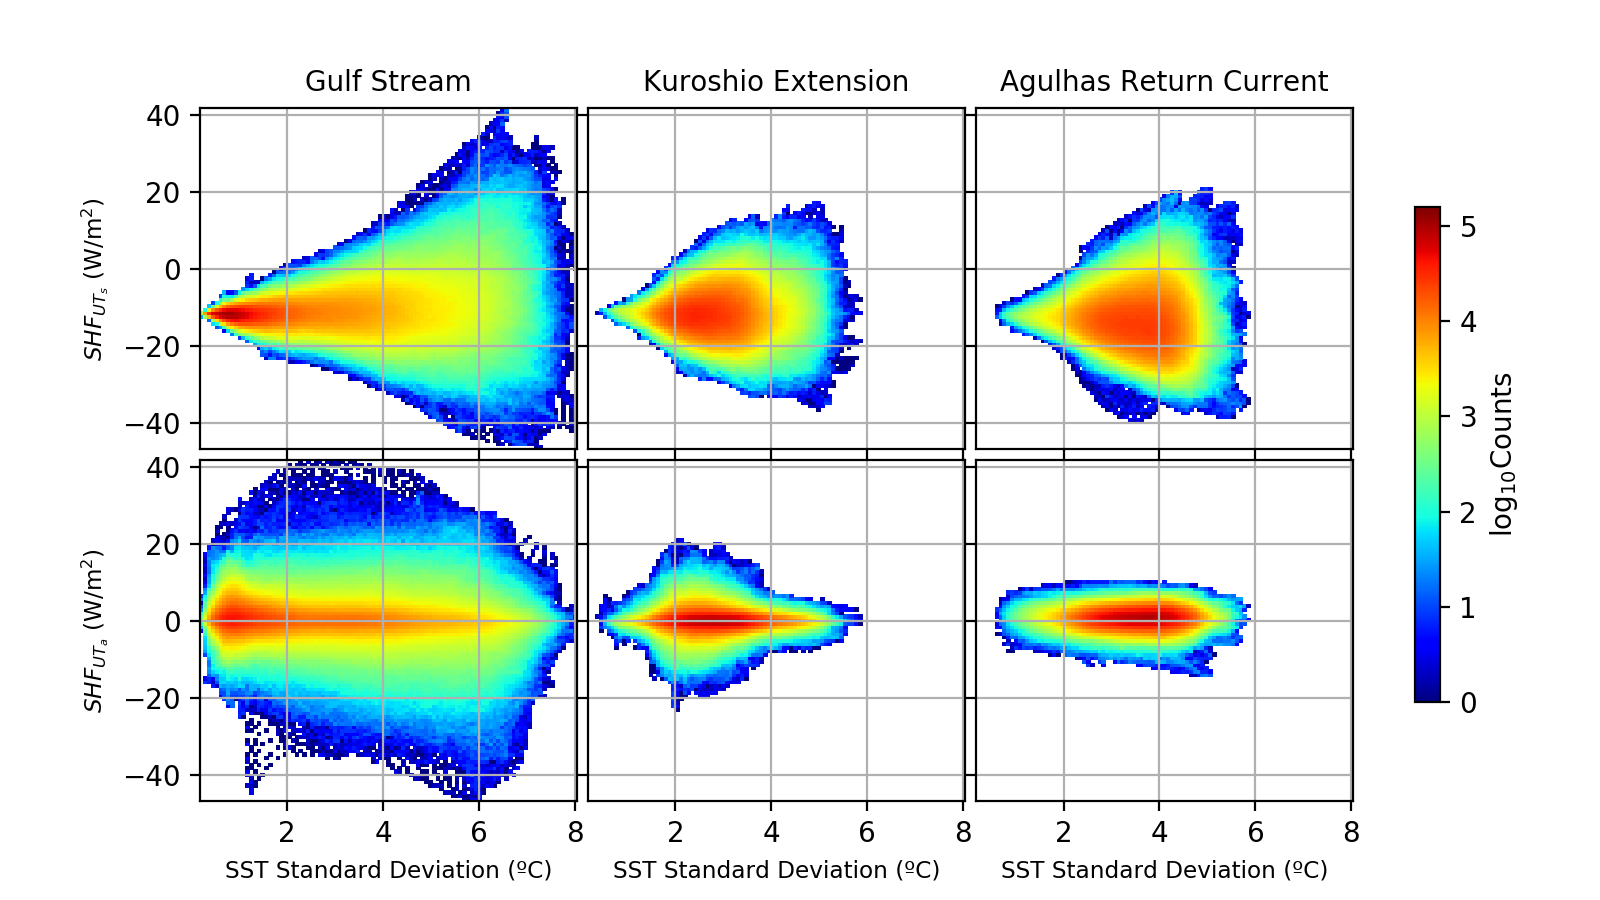

In [94]:
fig, axs = plt.subplots(2,3,figsize=(8,4.5))
fig.subplots_adjust(wspace=.03,hspace=0.03)

ax = axs[0,0]
pc = ax.pcolormesh(h,r,np.log10(hist_GStsu),cmap=cm.get_cmap('jet'),vmax=5.2)
ax.set_title("Gulf Stream",fontsize='medium')
ax.set_ylabel("$SHF_{UT_s}$ (W/m$^2$)",fontsize='small')
plt.setp(ax.get_xticklabels(), visible=False)
ax.grid()

ax = axs[0,1]
pc = ax.pcolormesh(h,r,np.log10(hist_Ktsu),cmap=cm.get_cmap('jet'),vmax=5.2)
ax.set_title("Kuroshio Extension",fontsize='medium')
plt.setp(ax.get_xticklabels(), visible=False)
plt.setp(ax.get_yticklabels(), visible=False)
ax.grid()

ax = axs[0,2]
pc = ax.pcolormesh(h,r,np.log10(hist_Atsu),cmap=cm.get_cmap('jet'),vmax=5.2)
ax.set_title("Agulhas Return Current",fontsize='medium')
plt.setp(ax.get_xticklabels(), visible=False)
plt.setp(ax.get_yticklabels(), visible=False)
ax.grid()

####

ax = axs[1,0]
pc = ax.pcolormesh(h,r,np.log10(hist_GStau),cmap=cm.get_cmap('jet'),vmax=5.2)
ax.set_xlabel("SST Standard Deviation (ºC)",fontsize='small')
ax.set_ylabel("$SHF_{UT_a}$ (W/m$^2$)",fontsize='small')
#plt.setp(ax.get_xticklabels(), visible=False)
ax.grid()

ax = axs[1,1]
pc = ax.pcolormesh(h,r,np.log10(hist_Ktau),cmap=cm.get_cmap('jet'),vmax=5.2)
ax.set_xlabel("SST Standard Deviation (ºC)",fontsize='small')
#plt.setp(ax.get_xticklabels(), visible=False)
plt.setp(ax.get_yticklabels(), visible=False)
ax.grid()

ax = axs[1,2]
pc = ax.pcolormesh(h,r,np.log10(hist_Atau),cmap=cm.get_cmap('jet'),vmax=5.2)
ax.set_xlabel("SST Standard Deviation (ºC)",fontsize='small')
fig.colorbar(pc,ax=axs,label="log$_{10}$Counts",fraction=0.02)
#plt.setp(ax.get_xticklabels(), visible=False)
plt.setp(ax.get_yticklabels(), visible=False)
ax.grid()



In [ ]:
plt.savefig('PAPER_sststdpdf_SHF.png', dpi=300, bbox_inches='tight')


In [32]:
r, h, h_GS, h_K, h_A = makehistcount3x(LSsum_GS,LSsum_K,LSsum_A,SSTstd_GS,SSTstd_K,SSTstd_A,100,100)

h_GS[np.where(h_GS == 0.0)] = None
h_K[np.where(h_K == 0.0)] = None
h_A[np.where(h_A == 0.0)] = None


/Users/baileydonaldson/Python/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in greater_equal
/Users/baileydonaldson/Python/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in less
/Users/baileydonaldson/Python/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in greater_equal
/Users/baileydonaldson/Python/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in less


<IPython.core.display.Javascript object>


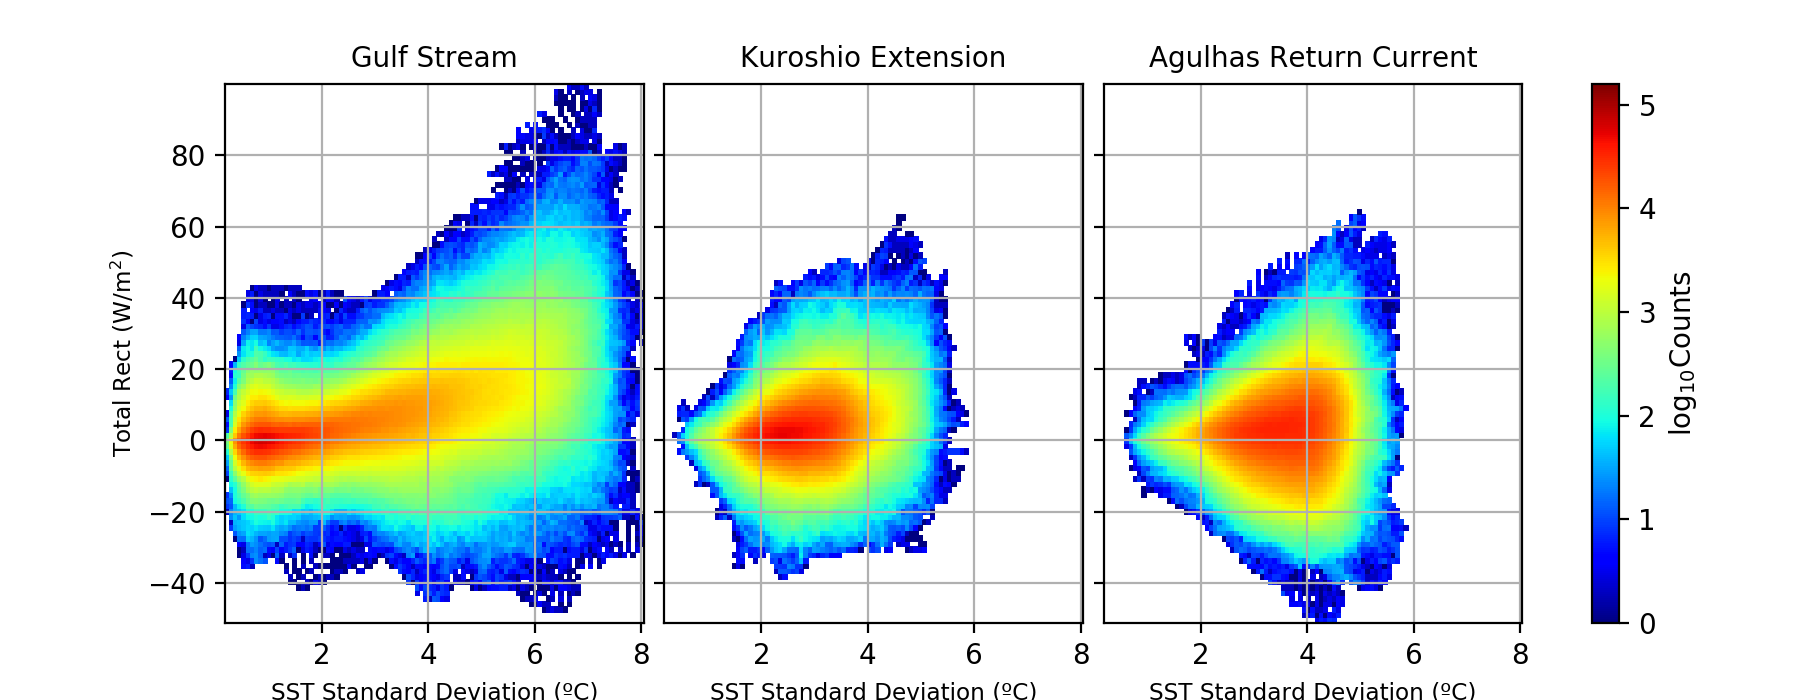

In [42]:
fig, axs = plt.subplots(ncols=3,figsize=(9,3.5))
fig.subplots_adjust(wspace=.05)

ax = axs[0]
pc = ax.pcolormesh(h,r,np.log10(h_GS),cmap=cm.get_cmap('jet'),vmax=5.2)
ax.set_title("Gulf Stream",fontsize='medium')
ax.set_ylabel("Total Rect (W/m$^2$)",fontsize='small')
ax.set_xlabel("SST Standard Deviation (ºC)",fontsize='small')
ax.grid()

ax = axs[1]
pc = ax.pcolormesh(h,r,np.log10(h_K),cmap=cm.get_cmap('jet'),vmax=5.2)
ax.set_title("Kuroshio Extension",fontsize='medium')
ax.set_xlabel("SST Standard Deviation (ºC)",fontsize='small')
plt.setp(ax.get_yticklabels(), visible=False)
ax.grid()

ax = axs[2]
pc = ax.pcolormesh(h,r,np.log10(h_A),cmap=cm.get_cmap('jet'),vmax=5.2)
ax.set_title("Agulhas Return Current",fontsize='medium')
ax.set_xlabel("SST Standard Deviation (ºC)",fontsize='small')
fig.colorbar(pc,ax=axs,label="log$_{10}$Counts",fraction=0.02)
plt.setp(ax.get_yticklabels(), visible=False)
ax.grid()


In [56]:
#in conditions where SST std is less than or equal to 3ºC, how often does the rectification exceed 10?
temp = LSsum_GS[np.where(SSTstd_GS <= 3)]
tempoverten = temp[np.where(temp >= 10)]
print(100*len(tempoverten)/len(temp))

temp = LSsum_K[np.where(SSTstd_K <= 3)]
tempoverten = temp[np.where(temp >= 10)]
print(100*len(tempoverten)/len(temp))

temp = LSsum_A[np.where(SSTstd_A <= 3)]
tempoverten = temp[np.where(temp >= 10)]
print(100*len(tempoverten)/len(temp))

/Users/baileydonaldson/Python/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in less_equal
  """Entry point for launching an IPython kernel.


6.091977240490901
7.773190517770861


/Users/baileydonaldson/Python/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in less_equal
  """


7.029153887837447


In [57]:
#in conditions where SST std is less than or equal to 3ºC, how often is the rectification less than 10?
temp = LSsum_GS[np.where(SSTstd_GS <= 3)]
tempoverten = temp[np.where(temp < 10)]
print(100*len(tempoverten)/len(temp))

temp = LSsum_K[np.where(SSTstd_K <= 3)]
tempoverten = temp[np.where(temp < 10)]
print(100*len(tempoverten)/len(temp))

temp = LSsum_A[np.where(SSTstd_A <= 3)]
tempoverten = temp[np.where(temp < 10)]
print(100*len(tempoverten)/len(temp))

/Users/baileydonaldson/Python/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in less_equal
  


93.9080227595091
92.22680948222914


/Users/baileydonaldson/Python/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in less_equal
  


92.97084611216255


In [58]:
# if the SST is greater than 3ºC, how often does the rectification exceed 10?
temp = LSsum_GS[np.where(SSTstd_GS > 3)]
tempoverten = temp[np.where(temp >= 10)]
print(100*len(tempoverten)/len(temp))

temp = LSsum_K[np.where(SSTstd_K > 3)]
tempoverten = temp[np.where(temp >= 10)]
print(100*len(tempoverten)/len(temp))

temp = LSsum_A[np.where(SSTstd_A > 3)]
tempoverten = temp[np.where(temp >= 10)]
print(100*len(tempoverten)/len(temp))


/Users/baileydonaldson/Python/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in greater
  
/Users/baileydonaldson/Python/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in greater
  


51.944449110954
22.749241691943602
20.039627101127614


## Cold Air Outbreaks

In [84]:
#get winter months for GS and Kuroshio. Need total rect, humidity, wdir
test,ym,m_str = monthly_avg(Q4_GS, day)

LSsum_GS_DJF = LSsum_GS[(ym[:,1] == 12) | (ym[:,1] == 1) | (ym[:,1] == 2),:,:]
LSsum_K_DJF = LSsum_K[(ym[:,1] == 12) | (ym[:,1] == 1) | (ym[:,1] == 2),:,:]
wGS_DJF = wGS[(ym[:,1] == 12) | (ym[:,1] == 1) | (ym[:,1] == 2),:,:]
wK_DJF = wK[(ym[:,1] == 12) | (ym[:,1] == 1) | (ym[:,1] == 2),:,:]
sphsm_GS_DJF = sphsm_GS[(ym[:,1] == 12) | (ym[:,1] == 1) | (ym[:,1] == 2),:,:]
sphsm_K_DJF = sphsm_K[(ym[:,1] == 12) | (ym[:,1] == 1) | (ym[:,1] == 2),:,:]




In [85]:
r_GS, h_GS, hist_GS = makehistavg(sphsm_GS_DJF,wGS_DJF,LSsum_GS_DJF,100,100)
r_GS, h_GS, hist_GSstd = makehiststd(sphsm_GS_DJF,wGS_DJF,LSsum_GS_DJF,100,100)

r_K, h_K, hist_K = makehistavg(sphsm_K_DJF,wK_DJF,LSsum_K_DJF,100,100)
r_K, h_K, hist_Kstd = makehiststd(sphsm_K_DJF,wK_DJF,LSsum_K_DJF,100,100)

hist_GS[np.where(hist_GS == 0.0)] = None
hist_GSstd[np.where(hist_GSstd == 0.0)] = None

hist_K[np.where(hist_K == 0.0)] = None
hist_Kstd[np.where(hist_Kstd == 0.0)] = None


/Users/baileydonaldson/Python/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: Mean of empty slice


<IPython.core.display.Javascript object>


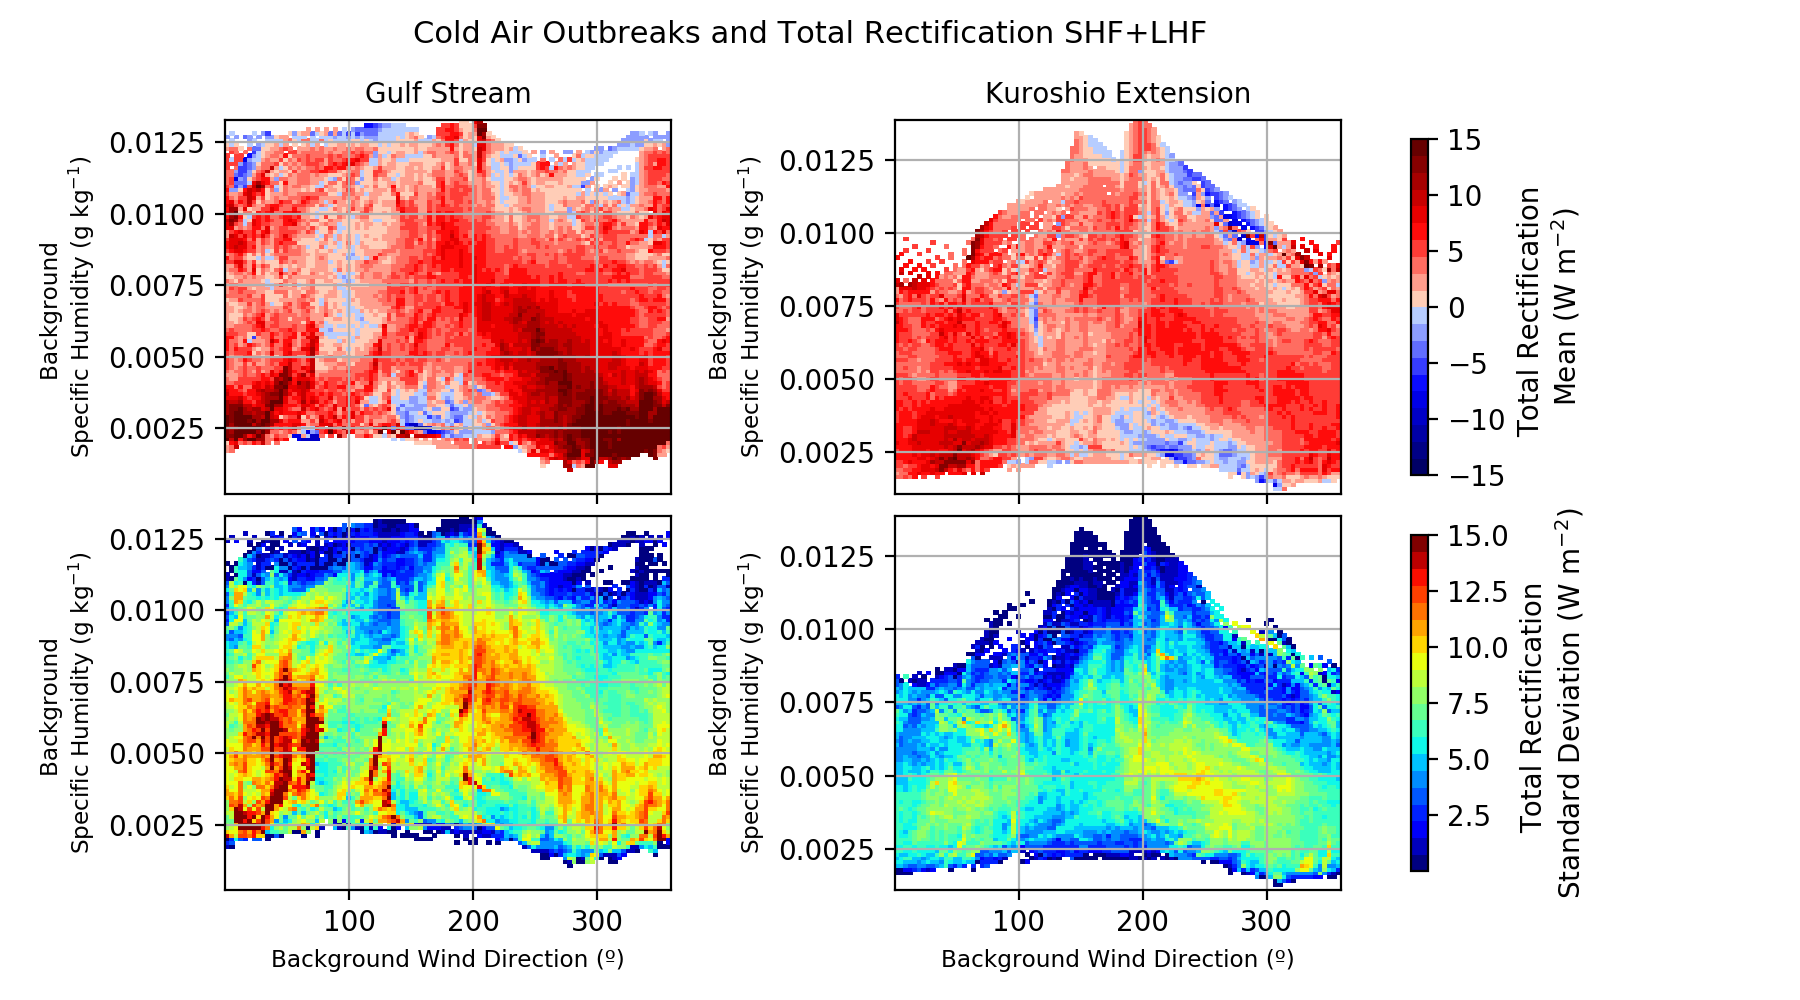

In [88]:
fig, axs = plt.subplots(2,2,figsize=(9,5))
fig.subplots_adjust(wspace=.5,hspace=0.06)
fig.suptitle('Cold Air Outbreaks and Total Rectification SHF+LHF', fontsize=11,x=0.45, y=.98)

ax = axs[0,0]
pc = ax.pcolormesh(h_GS,r_GS,hist_GS,cmap=cm.get_cmap('BlueRed3', 20),vmin=-15,vmax=15)
plt.setp(ax.get_xticklabels(), visible=False)
ax.set_title("Gulf Stream",fontsize='medium')
ax.set_ylabel("Background \nSpecific Humidity (g kg$^{-1}$)",fontsize='small')
ax.grid()

ax = axs[0,1]
pc = ax.pcolormesh(h_K,r_K,hist_K,cmap=cm.get_cmap('BlueRed3', 20),vmin=-15,vmax=15)
plt.setp(ax.get_xticklabels(), visible=False)
ax.set_ylabel("Background \nSpecific Humidity (g kg$^{-1}$)",fontsize='small')
fig.colorbar(pc,ax=axs[0],label="Total Rectification \nMean (W m$^{-2}$)",shrink=.9)
ax.set_title("Kuroshio Extension",fontsize='medium')
ax.grid()

######

ax = axs[1,0]
pc = ax.pcolormesh(h_GS,r_GS,hist_GSstd,cmap=cm.get_cmap('jet', 20),vmax=15)
ax.set_ylabel("Background \nSpecific Humidity (g kg$^{-1}$)",fontsize='small')
ax.set_xlabel("Background Wind Direction (º)",fontsize='small')
ax.grid()

ax = axs[1,1]
pc = ax.pcolormesh(h_K,r_K,hist_Kstd,cmap=cm.get_cmap('jet', 20),vmax=15)
fig.colorbar(pc,ax=axs[1],label="Total Rectification \nStandard Deviation (W m$^{-2}$)",shrink=.9)
ax.set_ylabel("Background \nSpecific Humidity (g kg$^{-1}$)",fontsize='small')
ax.set_xlabel("Background Wind Direction (º)",fontsize='small')
ax.grid()




In [76]:
plt.savefig('PAPER_coldair.png', dpi=300, bbox_inches='tight')


<IPython.core.display.Javascript object>


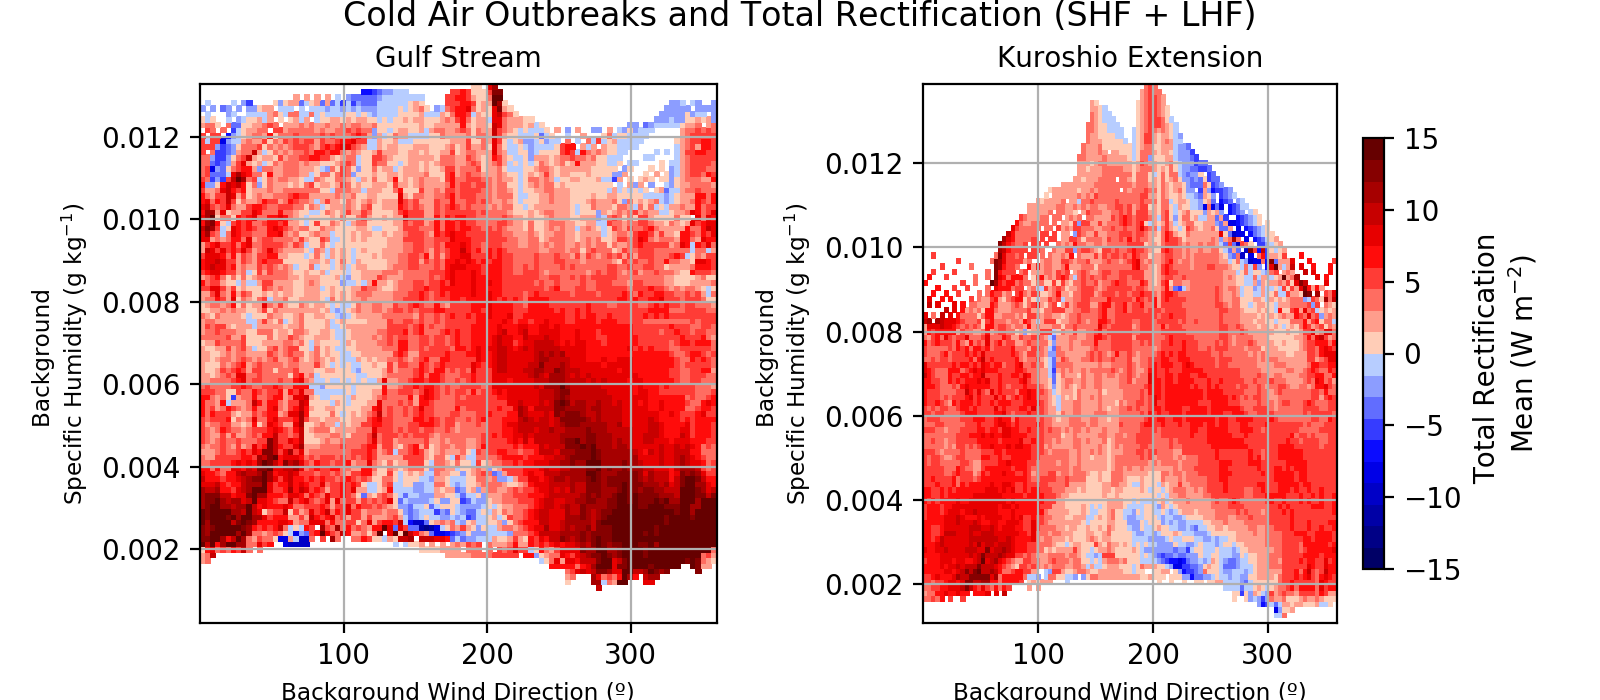

In [89]:
fig, axs = plt.subplots(ncols=2,figsize=(8,3.5))
fig.subplots_adjust(wspace=.4,hspace=0.06)
fig.suptitle('Cold Air Outbreaks and Total Rectification (SHF + LHF)', fontsize=12,x=0.5, y=1)

ax = axs[0]
pc = ax.pcolormesh(h_GS,r_GS,hist_GS,cmap=cm.get_cmap('BlueRed3', 20),vmin=-15,vmax=15)
ax.set_title("Gulf Stream",fontsize='medium')
ax.set_ylabel("Background \nSpecific Humidity (g kg$^{-1}$)",fontsize='small')
ax.set_xlabel("Background Wind Direction (º)",fontsize='small')
ax.grid()

ax = axs[1]
pc = ax.pcolormesh(h_K,r_K,hist_K,cmap=cm.get_cmap('BlueRed3', 20),vmin=-15,vmax=15)
ax.set_ylabel("Background \nSpecific Humidity (g kg$^{-1}$)",fontsize='small')
fig.colorbar(pc,ax=axs[1],label="Total Rectification \nMean (W m$^{-2}$)",shrink=.8)
ax.set_title("Kuroshio Extension",fontsize='medium')
ax.set_xlabel("Background Wind Direction (º)",fontsize='small')
ax.grid()



In [90]:
plt.savefig('PAPER_coldair2.png', dpi=300, bbox_inches='tight')
